In [1]:
%matplotlib inline
from torch.utils.data import Dataset 
import glob
import torchvision.models as models
from torchvision import transforms
from torch import nn
import torch
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm
import os
from skimage import io, transform
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
width = 36
height = 64
emb_w = width // 4
emb_h = height // 4

In [3]:
MODEL_PATH = '/run/media/backman/yay/uiD'
MODEL2_PATH = '/run/media/backman/yay/uiG'

def save_model():
    torch.save(netD.state_dict(), MODEL_PATH)
    torch.save(netG.state_dict(), MODEL2_PATH)
    
def load_model():
    netD.load_state_dict(torch.load(MODEL_PATH))
    netG.load_state_dict(torch.load(MODEL2_PATH))

In [4]:
def resize_images():
    root_dir = '/run/media/backman/yay/unique_uis/combined/'
    new_dir = '/run/media/backman/yay/unique_uis/resized2/'
    files = glob.glob(root_dir + '*.jpg')
    for file in tqdm(files):
        try:
            im = Image.open(file)
            im.thumbnail((width,height), Image.ANTIALIAS)
            assert im.size == (width,height)
            im.save(new_dir+os.path.basename(file),"JPEG")
        except IOError:
            pass
        except AssertionError:
            pass

In [5]:
#resize_images()

In [6]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
bs = 4

In [7]:
class GoogleUIDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.files = glob.glob(root_dir + '*.jpg')
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.files[idx])
        image = io.imread(img_name)
        if self.transform:
            image = self.transform(image)
        return image

In [8]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, tuple)
        self.output_size = output_size

    def __call__(self, image):

        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w), mode='constant')
        return img

In [9]:
g = GoogleUIDataset('/run/media/backman/yay/unique_uis/special/',
                                                   transform=transforms.Compose([
#                                                     Rescale((36, 64)),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                                   ]))
guid = torch.utils.data.DataLoader(g,
                                   bs, True, num_workers = 1)

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [11]:
class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
    
class Reshape(nn.Module):
    def forward(self, x):
        x = x.view(-1, 128, emb_h, emb_w)
        return x

In [12]:
class D(nn.Module):

    def conv_sub_block(self, in_c, out_c, sub = False):
        conv_sub_arr = []
        conv_sub_arr.append(nn.Conv2d(in_c, in_c, 3, padding=1))
        conv_sub_arr.append(nn.ELU())
        conv_sub_arr.append(nn.Conv2d(in_c, out_c, 3, padding=1))
        conv_sub_arr.append(nn.ELU())
        if sub:
            conv_sub_arr.append(nn.Conv2d(out_c, out_c, 3, stride = 2, padding=1))
            conv_sub_arr.append(nn.ELU())
        return conv_sub_arr
    
    def deconv_up_block(self, in_c, out_c = None, up = False):
        if out_c is None:
            out_c = in_c
        deconv_sub_arr = []
        deconv_sub_arr.append(nn.Conv2d(in_c, in_c, 3, padding=1))
        deconv_sub_arr.append(nn.ELU())
        deconv_sub_arr.append(nn.Conv2d(in_c, out_c, 3, padding=1))
        deconv_sub_arr.append(nn.ELU())
        if up:
            deconv_sub_arr.append(nn.Upsample(scale_factor = 2, mode='nearest'))
            deconv_sub_arr.append(nn.ELU())
        return deconv_sub_arr



    def __init__(self):
        super(D, self).__init__()

        n = 128
        h = 64 #noise vector
        layers = []
        layers.append(nn.Conv2d(3, n, 3, padding=1)) #36x64x128
        layers += self.conv_sub_block(n, n*2, True) #18x32x256
        layers += self.conv_sub_block(n*2, n*3, True)#9x16x384
        layers += self.conv_sub_block(n*3, n*3)#9x16x384
        layers.append(Flatten())#15360
        layers.append(nn.Linear(3*emb_h*emb_w*n, h)) #64
 
        layers.append(nn.Linear(h,emb_h*emb_w*n)) #5120
        layers.append(Reshape()) #16x9x128
        layers += self.deconv_up_block(n, 2*n, up = True)#9x16x256
        layers += self.deconv_up_block(2*n, 2*n, True)#18x32x256
        layers += self.deconv_up_block(2*n, n)#36x64x128
        layers.append(nn.Conv2d(n, 3, 3, padding=1))#36x64x3
        
        self.model = nn.Sequential(*layers)

    def forward(self, input):
        return self.model(input)



In [13]:
class G(nn.Module):
    
    def deconv_up_block(self, in_c, out_c = None, up = False):
        if out_c is None:
            out_c = in_c
        deconv_sub_arr = []
        deconv_sub_arr.append(nn.Conv2d(in_c, in_c, 3, padding=1))
        deconv_sub_arr.append(nn.ELU())
        deconv_sub_arr.append(nn.Conv2d(in_c, out_c, 3, padding=1))
        deconv_sub_arr.append(nn.ELU())
        if up:
            deconv_sub_arr.append(nn.Upsample(scale_factor = 2, mode='nearest'))
            deconv_sub_arr.append(nn.ELU())
        return deconv_sub_arr

    def __init__(self):
        super(G, self).__init__()
        n = 128
        h = 64 #noise vector

        layers = []
        layers.append(nn.Linear(h,emb_h*emb_w*n)) 
        layers.append(Reshape())
        layers += self.deconv_up_block(n, 2*n, up = True)
        layers += self.deconv_up_block(2*n, 2*n, True)
        layers += self.deconv_up_block(2*n, n)
        layers.append(nn.Conv2d(n, 3, 3, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, input):
        return self.model(input)

In [14]:
netD = D()

In [15]:
netG = G()

In [16]:
noise = dtype(bs, 64)

In [17]:
if use_cuda:
    netG = netG.cuda()
    netD = netD.cuda()
netG.apply(weights_init)
netD.apply(weights_init)

D (
  (model): Sequential (
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ELU (alpha=1.0)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ELU (alpha=1.0)
    (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): ELU (alpha=1.0)
    (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ELU (alpha=1.0)
    (9): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ELU (alpha=1.0)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): ELU (alpha=1.0)
    (13): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ELU (alpha=1.0)
    (15): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ELU (alpha=1.0)
    (17): Flatten (
    )
    (18): Linear (55296 -> 64)
    (19): Linear 

In [18]:
optimizerG = optim.Adam(netG.parameters())
optimizerD = optim.Adam(netD.parameters())

In [19]:
noise = Variable(noise)

In [20]:
def get_real_image(batch):
    var = batch
    if use_cuda:
        var = var.cuda()
    return Variable(var)

In [21]:
def get_fake_image():
    noise.data.normal_(0, 1)
    return noise

In [22]:
def train(n_epochs = 1, k_t = 0, lambda_k = 0.001, gamma = 0.5):
    n_batches = len(guid)
    for epoch in tqdm(range(n_epochs)):
        for iteration in range(n_batches):
            data_iter = iter(guid)
            max_D_train = 5 if n_batches - iteration >= 5 else 1 
            for _ in range(max_D_train):
                #real image
                real = get_real_image(next(data_iter))
                netD.zero_grad()
                loss_real = torch.mean(torch.abs(netD(real) - real))
                
                #fake image
                fake = netG(get_fake_image())
                loss_fake = torch.mean(torch.abs(netD(fake) - fake))
                loss_discriminator = loss_real - k_t * loss_fake
                loss_discriminator.backward()
                optimizerD.step()
                
            netG.zero_grad()
            #discriminator should not be trainable here
            fake = get_fake_image()
            loss_generator = torch.mean(torch.abs(netG(fake) - netD(netG(fake))))
            loss_generator.backward()
            optimizerG.step()
            
            update = gamma * loss_real - loss_generator
            update = update.data[0]
            
            k_t += lambda_k * update 
            k_t = max(min(1, k_t), 0)
            
            if iteration % 500 == 0:
                print(f'step: {iteration} / {n_batches} (epoch: {epoch}); loss_generator: {loss_generator.data[0]}; loss_discriminator:  {loss_discriminator.data[0]}')
                
    return k_t
                
            
            
                
        

In [23]:
k_t = train()

  0%|          | 0/1 [00:00<?, ?it/s]

step: 0 / 61 (epoch: 0); loss_generator: 2.1959829330444336; loss_discriminator:  6.846884250640869


100%|██████████| 1/1 [00:55<00:00, 55.62s/it]


In [22]:
#load_model()

In [24]:
example =   netG(get_fake_image()).data.cpu()

In [25]:
from torchvision import utils

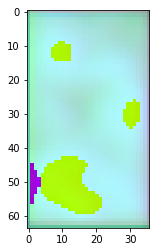

In [26]:
utils.make_grid(example)
im = example / 2 +0.5
im = im.numpy()
plt.imshow(np.transpose(im[2], (1,2,0)))

In [27]:
k_t = train(100, k_t)

  0%|          | 0/100 [00:00<?, ?it/s]

step: 0 / 61 (epoch: 0); loss_generator: 0.48712021112442017; loss_discriminator:  0.8782138228416443


  1%|          | 1/100 [00:54<1:30:31, 54.86s/it]

step: 0 / 61 (epoch: 1); loss_generator: 1.166221261024475; loss_discriminator:  0.5526058077812195


  2%|▏         | 2/100 [01:50<1:30:02, 55.12s/it]

step: 0 / 61 (epoch: 2); loss_generator: 0.7233197093009949; loss_discriminator:  0.6667134761810303


  3%|▎         | 3/100 [02:46<1:29:30, 55.37s/it]

step: 0 / 61 (epoch: 3); loss_generator: 0.49902594089508057; loss_discriminator:  0.9592349529266357


  4%|▍         | 4/100 [03:42<1:28:51, 55.54s/it]

step: 0 / 61 (epoch: 4); loss_generator: 0.6613966822624207; loss_discriminator:  0.6573041677474976


  5%|▌         | 5/100 [04:38<1:28:09, 55.68s/it]

step: 0 / 61 (epoch: 5); loss_generator: 0.8885241746902466; loss_discriminator:  1.0000736713409424


  6%|▌         | 6/100 [05:34<1:27:19, 55.74s/it]

step: 0 / 61 (epoch: 6); loss_generator: 0.16599979996681213; loss_discriminator:  0.7245994806289673


  7%|▋         | 7/100 [06:30<1:26:29, 55.80s/it]

step: 0 / 61 (epoch: 7); loss_generator: 0.7682297229766846; loss_discriminator:  0.6963740587234497


  8%|▊         | 8/100 [07:27<1:25:41, 55.88s/it]

step: 0 / 61 (epoch: 8); loss_generator: 0.9164451360702515; loss_discriminator:  0.7028070688247681


  9%|▉         | 9/100 [08:23<1:24:49, 55.93s/it]

step: 0 / 61 (epoch: 9); loss_generator: 1.1718993186950684; loss_discriminator:  0.9491785168647766


 10%|█         | 10/100 [09:19<1:23:58, 55.99s/it]

step: 0 / 61 (epoch: 10); loss_generator: 0.11529680341482162; loss_discriminator:  0.4454635977745056


 11%|█         | 11/100 [10:16<1:23:09, 56.06s/it]

step: 0 / 61 (epoch: 11); loss_generator: 0.9779766798019409; loss_discriminator:  0.7094493508338928


 12%|█▏        | 12/100 [11:13<1:22:16, 56.10s/it]

step: 0 / 61 (epoch: 12); loss_generator: 0.40047022700309753; loss_discriminator:  0.6181716918945312


 13%|█▎        | 13/100 [12:09<1:21:23, 56.14s/it]

step: 0 / 61 (epoch: 13); loss_generator: 0.5941287875175476; loss_discriminator:  0.8325157761573792


 14%|█▍        | 14/100 [13:06<1:20:29, 56.16s/it]

step: 0 / 61 (epoch: 14); loss_generator: 0.4758850634098053; loss_discriminator:  0.5240503549575806


 15%|█▌        | 15/100 [14:03<1:19:37, 56.20s/it]

step: 0 / 61 (epoch: 15); loss_generator: 0.7717263102531433; loss_discriminator:  0.6898078918457031


 16%|█▌        | 16/100 [14:59<1:18:43, 56.24s/it]

step: 0 / 61 (epoch: 16); loss_generator: 1.329208254814148; loss_discriminator:  0.6873310804367065


 17%|█▋        | 17/100 [15:56<1:17:50, 56.27s/it]

step: 0 / 61 (epoch: 17); loss_generator: 1.1430615186691284; loss_discriminator:  0.978364109992981


 18%|█▊        | 18/100 [16:53<1:16:56, 56.30s/it]

step: 0 / 61 (epoch: 18); loss_generator: 0.3814966380596161; loss_discriminator:  0.4983287453651428


 19%|█▉        | 19/100 [17:50<1:16:01, 56.32s/it]

step: 0 / 61 (epoch: 19); loss_generator: 0.21528097987174988; loss_discriminator:  0.7595759630203247


 20%|██        | 20/100 [18:46<1:15:07, 56.34s/it]

step: 0 / 61 (epoch: 20); loss_generator: 0.38640421628952026; loss_discriminator:  0.5898019075393677


 21%|██        | 21/100 [19:43<1:14:12, 56.36s/it]

step: 0 / 61 (epoch: 21); loss_generator: 0.4718206524848938; loss_discriminator:  0.6022478342056274


 22%|██▏       | 22/100 [20:38<1:13:10, 56.29s/it]

step: 0 / 61 (epoch: 22); loss_generator: 0.6001889705657959; loss_discriminator:  0.6707972884178162


 23%|██▎       | 23/100 [21:33<1:12:10, 56.24s/it]

step: 0 / 61 (epoch: 23); loss_generator: 0.23031502962112427; loss_discriminator:  0.3951934278011322


 24%|██▍       | 24/100 [22:28<1:11:09, 56.18s/it]

step: 0 / 61 (epoch: 24); loss_generator: 0.18021677434444427; loss_discriminator:  0.8814762234687805


 25%|██▌       | 25/100 [23:22<1:10:08, 56.12s/it]

step: 0 / 61 (epoch: 25); loss_generator: 0.6710311770439148; loss_discriminator:  0.6490692496299744


 26%|██▌       | 26/100 [24:17<1:09:08, 56.07s/it]

step: 0 / 61 (epoch: 26); loss_generator: 0.659008800983429; loss_discriminator:  0.38171812891960144


 27%|██▋       | 27/100 [25:12<1:08:09, 56.02s/it]

step: 0 / 61 (epoch: 27); loss_generator: 0.8610349297523499; loss_discriminator:  1.4089215993881226


 28%|██▊       | 28/100 [26:07<1:07:10, 55.98s/it]

step: 0 / 61 (epoch: 28); loss_generator: 0.5457859635353088; loss_discriminator:  0.7614123225212097


 29%|██▉       | 29/100 [27:02<1:06:12, 55.95s/it]

step: 0 / 61 (epoch: 29); loss_generator: 0.6580283045768738; loss_discriminator:  0.8037974238395691


 30%|███       | 30/100 [27:57<1:05:13, 55.91s/it]

step: 0 / 61 (epoch: 30); loss_generator: 1.586683750152588; loss_discriminator:  0.8261409997940063


 31%|███       | 31/100 [28:52<1:04:15, 55.87s/it]

step: 0 / 61 (epoch: 31); loss_generator: 0.6703139543533325; loss_discriminator:  0.7437644004821777


 32%|███▏      | 32/100 [29:46<1:03:16, 55.83s/it]

step: 0 / 61 (epoch: 32); loss_generator: 0.4759428799152374; loss_discriminator:  0.7460872530937195


 33%|███▎      | 33/100 [30:41<1:02:18, 55.80s/it]

step: 0 / 61 (epoch: 33); loss_generator: 1.616332769393921; loss_discriminator:  1.1370012760162354


 34%|███▍      | 34/100 [31:36<1:01:20, 55.77s/it]

step: 0 / 61 (epoch: 34); loss_generator: 0.20052896440029144; loss_discriminator:  0.7594171762466431


 35%|███▌      | 35/100 [32:30<1:00:22, 55.73s/it]

step: 0 / 61 (epoch: 35); loss_generator: 0.5638381242752075; loss_discriminator:  0.7078584432601929


 36%|███▌      | 36/100 [33:25<59:25, 55.70s/it]  

step: 0 / 61 (epoch: 36); loss_generator: 0.650714635848999; loss_discriminator:  0.5363978147506714


 37%|███▋      | 37/100 [34:19<58:27, 55.67s/it]

step: 0 / 61 (epoch: 37); loss_generator: 1.1613322496414185; loss_discriminator:  0.432057648897171


 38%|███▊      | 38/100 [35:14<57:29, 55.65s/it]

step: 0 / 61 (epoch: 38); loss_generator: 0.14126522839069366; loss_discriminator:  0.4590451717376709


 39%|███▉      | 39/100 [36:09<56:32, 55.62s/it]

step: 0 / 61 (epoch: 39); loss_generator: 0.34067752957344055; loss_discriminator:  0.669799268245697


 40%|████      | 40/100 [37:03<55:35, 55.60s/it]

step: 0 / 61 (epoch: 40); loss_generator: 0.5464882254600525; loss_discriminator:  0.8861187696456909


 41%|████      | 41/100 [37:58<54:39, 55.58s/it]

step: 0 / 61 (epoch: 41); loss_generator: 364784877568.0; loss_discriminator:  25765230592.0


 42%|████▏     | 42/100 [38:53<53:42, 55.56s/it]

step: 0 / 61 (epoch: 42); loss_generator: 132.57093811035156; loss_discriminator:  1.0541701316833496


 43%|████▎     | 43/100 [39:47<52:45, 55.53s/it]

step: 0 / 61 (epoch: 43); loss_generator: 99.91768646240234; loss_discriminator:  1.1132453680038452


 44%|████▍     | 44/100 [40:42<51:48, 55.51s/it]

step: 0 / 61 (epoch: 44); loss_generator: 62.45195388793945; loss_discriminator:  1.0704808235168457


 45%|████▌     | 45/100 [41:36<50:51, 55.49s/it]

step: 0 / 61 (epoch: 45); loss_generator: 81.76403045654297; loss_discriminator:  0.47041332721710205


 46%|████▌     | 46/100 [42:31<49:55, 55.47s/it]

step: 0 / 61 (epoch: 46); loss_generator: 83.95320892333984; loss_discriminator:  1.026981234550476


 47%|████▋     | 47/100 [43:26<48:58, 55.45s/it]

step: 0 / 61 (epoch: 47); loss_generator: 112.89590454101562; loss_discriminator:  0.7558959722518921


 48%|████▊     | 48/100 [44:20<48:02, 55.43s/it]

step: 0 / 61 (epoch: 48); loss_generator: 99.40721130371094; loss_discriminator:  0.7640689015388489


 49%|████▉     | 49/100 [45:14<47:05, 55.40s/it]

step: 0 / 61 (epoch: 49); loss_generator: 85.93785095214844; loss_discriminator:  1.063960075378418


 50%|█████     | 50/100 [46:07<46:07, 55.35s/it]

step: 0 / 61 (epoch: 50); loss_generator: 108.07569122314453; loss_discriminator:  0.6828181147575378


 51%|█████     | 51/100 [47:00<45:10, 55.31s/it]

step: 0 / 61 (epoch: 51); loss_generator: 103.41647338867188; loss_discriminator:  0.9460548162460327


 52%|█████▏    | 52/100 [47:53<44:12, 55.27s/it]

step: 0 / 61 (epoch: 52); loss_generator: 137.93006896972656; loss_discriminator:  0.6831889152526855


 53%|█████▎    | 53/100 [48:47<43:15, 55.23s/it]

step: 0 / 61 (epoch: 53); loss_generator: 49.50495910644531; loss_discriminator:  0.8700172305107117


 54%|█████▍    | 54/100 [49:40<42:18, 55.19s/it]

step: 0 / 61 (epoch: 54); loss_generator: 58.14134979248047; loss_discriminator:  0.7070624232292175


 55%|█████▌    | 55/100 [50:33<41:21, 55.15s/it]

step: 0 / 61 (epoch: 55); loss_generator: 40.33835983276367; loss_discriminator:  0.6015586256980896


 56%|█████▌    | 56/100 [51:26<40:25, 55.11s/it]

step: 0 / 61 (epoch: 56); loss_generator: 90.30247497558594; loss_discriminator:  0.7294842004776001


 57%|█████▋    | 57/100 [52:19<39:28, 55.08s/it]

step: 0 / 61 (epoch: 57); loss_generator: 93.75485229492188; loss_discriminator:  0.8667231202125549


 58%|█████▊    | 58/100 [53:12<38:31, 55.05s/it]

step: 0 / 61 (epoch: 58); loss_generator: 66.89251708984375; loss_discriminator:  0.6159119009971619


 59%|█████▉    | 59/100 [54:05<37:35, 55.02s/it]

step: 0 / 61 (epoch: 59); loss_generator: 61.27037048339844; loss_discriminator:  0.7800675630569458


 60%|██████    | 60/100 [54:59<36:39, 54.99s/it]

step: 0 / 61 (epoch: 60); loss_generator: 95.92230987548828; loss_discriminator:  0.7009254097938538


 61%|██████    | 61/100 [55:52<35:43, 54.96s/it]

step: 0 / 61 (epoch: 61); loss_generator: 129.44900512695312; loss_discriminator:  0.9531909823417664


 62%|██████▏   | 62/100 [56:45<34:47, 54.93s/it]

step: 0 / 61 (epoch: 62); loss_generator: 74.4264907836914; loss_discriminator:  0.8845522999763489


 63%|██████▎   | 63/100 [57:38<33:51, 54.90s/it]

step: 0 / 61 (epoch: 63); loss_generator: 97.16195678710938; loss_discriminator:  0.6124701499938965


 64%|██████▍   | 64/100 [58:31<32:55, 54.87s/it]

step: 0 / 61 (epoch: 64); loss_generator: 54.07085037231445; loss_discriminator:  0.6947202086448669


 65%|██████▌   | 65/100 [59:24<31:59, 54.84s/it]

step: 0 / 61 (epoch: 65); loss_generator: 88.02999114990234; loss_discriminator:  0.5797261595726013


 66%|██████▌   | 66/100 [1:00:17<31:03, 54.82s/it]

step: 0 / 61 (epoch: 66); loss_generator: 70.93377685546875; loss_discriminator:  0.7519090175628662


 67%|██████▋   | 67/100 [1:01:11<30:08, 54.79s/it]

step: 0 / 61 (epoch: 67); loss_generator: 79.51810455322266; loss_discriminator:  0.737346351146698


 68%|██████▊   | 68/100 [1:02:04<29:12, 54.77s/it]

step: 0 / 61 (epoch: 68); loss_generator: 65.34390258789062; loss_discriminator:  0.9144318103790283


 69%|██████▉   | 69/100 [1:02:56<28:16, 54.74s/it]

step: 0 / 61 (epoch: 69); loss_generator: 81.75466918945312; loss_discriminator:  0.6089257001876831


 70%|███████   | 70/100 [1:03:49<27:21, 54.71s/it]

step: 0 / 61 (epoch: 70); loss_generator: 70.69352722167969; loss_discriminator:  0.9314814209938049


 71%|███████   | 71/100 [1:04:42<26:25, 54.69s/it]

step: 0 / 61 (epoch: 71); loss_generator: 56.38707733154297; loss_discriminator:  0.7084448933601379


 72%|███████▏  | 72/100 [1:05:35<25:30, 54.67s/it]

step: 0 / 61 (epoch: 72); loss_generator: 94.75093078613281; loss_discriminator:  0.5732974410057068


 73%|███████▎  | 73/100 [1:06:29<24:35, 54.64s/it]

step: 0 / 61 (epoch: 73); loss_generator: 72.52955627441406; loss_discriminator:  0.7001044750213623


 74%|███████▍  | 74/100 [1:07:22<23:40, 54.62s/it]

step: 0 / 61 (epoch: 74); loss_generator: 86.25984954833984; loss_discriminator:  0.6876552104949951


 75%|███████▌  | 75/100 [1:08:15<22:45, 54.60s/it]

step: 0 / 61 (epoch: 75); loss_generator: 53.618656158447266; loss_discriminator:  0.304638534784317


 76%|███████▌  | 76/100 [1:09:08<21:50, 54.58s/it]

step: 0 / 61 (epoch: 76); loss_generator: 114.99391174316406; loss_discriminator:  0.750568151473999


 77%|███████▋  | 77/100 [1:10:01<20:54, 54.56s/it]

step: 0 / 61 (epoch: 77); loss_generator: 79.72042083740234; loss_discriminator:  0.8434028625488281


 78%|███████▊  | 78/100 [1:10:54<19:59, 54.54s/it]

step: 0 / 61 (epoch: 78); loss_generator: 53.23362350463867; loss_discriminator:  0.519995391368866


 79%|███████▉  | 79/100 [1:11:47<19:05, 54.53s/it]

step: 0 / 61 (epoch: 79); loss_generator: 55.988739013671875; loss_discriminator:  0.702789843082428


 80%|████████  | 80/100 [1:12:40<18:10, 54.51s/it]

step: 0 / 61 (epoch: 80); loss_generator: 96.22924041748047; loss_discriminator:  0.8114602565765381


 81%|████████  | 81/100 [1:13:33<17:15, 54.49s/it]

step: 0 / 61 (epoch: 81); loss_generator: 95.17533111572266; loss_discriminator:  0.7802889347076416


 82%|████████▏ | 82/100 [1:14:26<16:20, 54.47s/it]

step: 0 / 61 (epoch: 82); loss_generator: 91.10675811767578; loss_discriminator:  0.76857990026474


 83%|████████▎ | 83/100 [1:15:19<15:25, 54.45s/it]

step: 0 / 61 (epoch: 83); loss_generator: 73.65332794189453; loss_discriminator:  0.6581218242645264


 84%|████████▍ | 84/100 [1:16:12<14:30, 54.43s/it]

step: 0 / 61 (epoch: 84); loss_generator: 112.07416534423828; loss_discriminator:  0.6710528135299683


 85%|████████▌ | 85/100 [1:17:05<13:36, 54.42s/it]

step: 0 / 61 (epoch: 85); loss_generator: 96.13199615478516; loss_discriminator:  0.6671291589736938


 86%|████████▌ | 86/100 [1:17:58<12:41, 54.40s/it]

step: 0 / 61 (epoch: 86); loss_generator: 79.87835693359375; loss_discriminator:  0.5067338347434998


 87%|████████▋ | 87/100 [1:18:51<11:46, 54.38s/it]

step: 0 / 61 (epoch: 87); loss_generator: 81.16584014892578; loss_discriminator:  0.6715821027755737


 88%|████████▊ | 88/100 [1:19:44<10:52, 54.37s/it]

step: 0 / 61 (epoch: 88); loss_generator: 49.67692565917969; loss_discriminator:  0.8036767244338989


 89%|████████▉ | 89/100 [1:20:37<09:57, 54.35s/it]

step: 0 / 61 (epoch: 89); loss_generator: 113.61649322509766; loss_discriminator:  0.5390939116477966


 90%|█████████ | 90/100 [1:21:30<09:03, 54.33s/it]

step: 0 / 61 (epoch: 90); loss_generator: 73.78829193115234; loss_discriminator:  0.6952168345451355


 91%|█████████ | 91/100 [1:22:22<08:08, 54.32s/it]

step: 0 / 61 (epoch: 91); loss_generator: 65.45799255371094; loss_discriminator:  1.0742768049240112


 92%|█████████▏| 92/100 [1:23:15<07:14, 54.30s/it]

step: 0 / 61 (epoch: 92); loss_generator: 73.60879516601562; loss_discriminator:  0.8992282152175903


 93%|█████████▎| 93/100 [1:24:08<06:20, 54.29s/it]

step: 0 / 61 (epoch: 93); loss_generator: 51.227962493896484; loss_discriminator:  1.0662046670913696


 94%|█████████▍| 94/100 [1:25:01<05:25, 54.27s/it]

step: 0 / 61 (epoch: 94); loss_generator: 38.14856719970703; loss_discriminator:  0.6872897744178772


 95%|█████████▌| 95/100 [1:25:54<04:31, 54.26s/it]

step: 0 / 61 (epoch: 95); loss_generator: 96.86517333984375; loss_discriminator:  0.5746434330940247


 96%|█████████▌| 96/100 [1:26:47<03:36, 54.25s/it]

step: 0 / 61 (epoch: 96); loss_generator: 121.83155059814453; loss_discriminator:  0.464584082365036


 97%|█████████▋| 97/100 [1:27:40<02:42, 54.23s/it]

step: 0 / 61 (epoch: 97); loss_generator: 129.80401611328125; loss_discriminator:  0.7482470870018005


 98%|█████████▊| 98/100 [1:28:33<01:48, 54.22s/it]

step: 0 / 61 (epoch: 98); loss_generator: 104.97905731201172; loss_discriminator:  1.0016103982925415


 99%|█████████▉| 99/100 [1:29:26<00:54, 54.20s/it]

step: 0 / 61 (epoch: 99); loss_generator: 53.90207290649414; loss_discriminator:  0.5168632864952087


100%|██████████| 100/100 [1:30:19<00:00, 54.19s/it]


In [28]:
k_t = train(5, k_t)

  0%|          | 0/5 [00:00<?, ?it/s]

step: 0 / 61 (epoch: 0); loss_generator: 117.24893188476562; loss_discriminator:  0.5859152674674988


 20%|██        | 1/5 [00:53<03:32, 53.01s/it]

step: 0 / 61 (epoch: 1); loss_generator: 97.57669067382812; loss_discriminator:  0.5677561163902283


 40%|████      | 2/5 [01:45<02:38, 52.98s/it]

step: 0 / 61 (epoch: 2); loss_generator: 63.337459564208984; loss_discriminator:  0.9029430150985718


 60%|██████    | 3/5 [02:38<01:45, 52.95s/it]

step: 0 / 61 (epoch: 3); loss_generator: 127.83599090576172; loss_discriminator:  0.5174606442451477


 80%|████████  | 4/5 [03:31<00:52, 52.96s/it]

step: 0 / 61 (epoch: 4); loss_generator: 59.55147933959961; loss_discriminator:  0.8786007761955261


100%|██████████| 5/5 [04:24<00:00, 52.99s/it]


In [29]:
k_t = train(200, k_t, 0.0001)

  0%|          | 0/200 [00:00<?, ?it/s]

step: 0 / 61 (epoch: 0); loss_generator: 49.255889892578125; loss_discriminator:  0.64488685131073


  0%|          | 1/200 [00:53<2:56:07, 53.11s/it]

step: 0 / 61 (epoch: 1); loss_generator: 78.38960266113281; loss_discriminator:  0.8371443748474121


  1%|          | 2/200 [01:46<2:55:22, 53.14s/it]

step: 0 / 61 (epoch: 2); loss_generator: 82.53121948242188; loss_discriminator:  0.7720555663108826


  2%|▏         | 3/200 [02:39<2:54:22, 53.11s/it]

step: 0 / 61 (epoch: 3); loss_generator: 72.0742416381836; loss_discriminator:  0.5043447613716125


  2%|▏         | 4/200 [03:32<2:53:29, 53.11s/it]

step: 0 / 61 (epoch: 4); loss_generator: 70.27738189697266; loss_discriminator:  0.6364185810089111


  2%|▎         | 5/200 [04:25<2:52:35, 53.10s/it]

step: 0 / 61 (epoch: 5); loss_generator: 119.30844116210938; loss_discriminator:  0.5514979362487793


  3%|▎         | 6/200 [05:18<2:51:38, 53.08s/it]

step: 0 / 61 (epoch: 6); loss_generator: 50.95368957519531; loss_discriminator:  0.8003767728805542


  4%|▎         | 7/200 [06:11<2:50:40, 53.06s/it]

step: 0 / 61 (epoch: 7); loss_generator: 77.16035461425781; loss_discriminator:  0.7254515290260315


  4%|▍         | 8/200 [07:04<2:49:44, 53.04s/it]

step: 0 / 61 (epoch: 8); loss_generator: 148.99302673339844; loss_discriminator:  0.5776429772377014


  4%|▍         | 9/200 [07:57<2:48:50, 53.04s/it]

step: 0 / 61 (epoch: 9); loss_generator: 81.42372131347656; loss_discriminator:  0.7823691964149475


  5%|▌         | 10/200 [08:50<2:47:56, 53.03s/it]

step: 0 / 61 (epoch: 10); loss_generator: 94.45718383789062; loss_discriminator:  0.7694024443626404


  6%|▌         | 11/200 [09:43<2:47:03, 53.03s/it]

step: 0 / 61 (epoch: 11); loss_generator: 88.67134857177734; loss_discriminator:  0.4211645722389221


  6%|▌         | 12/200 [10:36<2:46:09, 53.03s/it]

step: 0 / 61 (epoch: 12); loss_generator: 63.20347213745117; loss_discriminator:  0.7773482203483582


  6%|▋         | 13/200 [11:29<2:45:16, 53.03s/it]

step: 0 / 61 (epoch: 13); loss_generator: 78.49884033203125; loss_discriminator:  0.6993216872215271


  7%|▋         | 14/200 [12:22<2:44:22, 53.02s/it]

step: 0 / 61 (epoch: 14); loss_generator: 92.13343811035156; loss_discriminator:  0.6832634210586548


  8%|▊         | 15/200 [13:15<2:43:27, 53.02s/it]

step: 0 / 61 (epoch: 15); loss_generator: 95.19988250732422; loss_discriminator:  0.7182173728942871


  8%|▊         | 16/200 [14:08<2:42:34, 53.01s/it]

step: 0 / 61 (epoch: 16); loss_generator: 87.60943603515625; loss_discriminator:  0.6669043898582458


  8%|▊         | 17/200 [15:01<2:41:40, 53.01s/it]

step: 0 / 61 (epoch: 17); loss_generator: 45.814056396484375; loss_discriminator:  0.7638083696365356


  9%|▉         | 18/200 [15:54<2:40:47, 53.01s/it]

step: 0 / 61 (epoch: 18); loss_generator: 44.13307571411133; loss_discriminator:  0.8596633672714233


 10%|▉         | 19/200 [16:47<2:39:53, 53.00s/it]

step: 0 / 61 (epoch: 19); loss_generator: 91.07073211669922; loss_discriminator:  0.8290550112724304


 10%|█         | 20/200 [17:40<2:39:01, 53.01s/it]

step: 0 / 61 (epoch: 20); loss_generator: 86.746337890625; loss_discriminator:  0.7589226365089417


 10%|█         | 21/200 [18:33<2:38:08, 53.01s/it]

step: 0 / 61 (epoch: 21); loss_generator: 82.49691009521484; loss_discriminator:  0.7898882627487183


 11%|█         | 22/200 [19:25<2:37:13, 53.00s/it]

step: 0 / 61 (epoch: 22); loss_generator: 98.51203155517578; loss_discriminator:  0.5773503184318542


 12%|█▏        | 23/200 [20:18<2:36:20, 53.00s/it]

step: 0 / 61 (epoch: 23); loss_generator: 107.57135772705078; loss_discriminator:  0.5760539770126343


 12%|█▏        | 24/200 [21:11<2:35:26, 52.99s/it]

step: 0 / 61 (epoch: 24); loss_generator: 56.020084381103516; loss_discriminator:  0.5629023909568787


 12%|█▎        | 25/200 [22:04<2:34:33, 52.99s/it]

step: 0 / 61 (epoch: 25); loss_generator: 72.48941802978516; loss_discriminator:  0.7062206268310547


 13%|█▎        | 26/200 [22:57<2:33:39, 52.99s/it]

step: 0 / 61 (epoch: 26); loss_generator: 108.66948699951172; loss_discriminator:  1.0040336847305298


 14%|█▎        | 27/200 [23:50<2:32:46, 52.99s/it]

step: 0 / 61 (epoch: 27); loss_generator: 51.00951385498047; loss_discriminator:  0.3783408999443054


 14%|█▍        | 28/200 [24:43<2:31:53, 52.98s/it]

step: 0 / 61 (epoch: 28); loss_generator: 105.38317108154297; loss_discriminator:  0.6202021241188049


 14%|█▍        | 29/200 [25:36<2:30:59, 52.98s/it]

step: 0 / 61 (epoch: 29); loss_generator: 52.33295822143555; loss_discriminator:  0.8122726678848267


 15%|█▌        | 30/200 [26:29<2:30:06, 52.98s/it]

step: 0 / 61 (epoch: 30); loss_generator: 31.936595916748047; loss_discriminator:  0.7366043925285339


 16%|█▌        | 31/200 [27:22<2:29:13, 52.98s/it]

step: 0 / 61 (epoch: 31); loss_generator: 47.112083435058594; loss_discriminator:  0.7811684608459473


 16%|█▌        | 32/200 [28:15<2:28:19, 52.97s/it]

step: 0 / 61 (epoch: 32); loss_generator: 70.09854888916016; loss_discriminator:  0.3542102873325348


 16%|█▋        | 33/200 [29:08<2:27:26, 52.97s/it]

step: 0 / 61 (epoch: 33); loss_generator: 46.58823776245117; loss_discriminator:  0.8520843982696533


 17%|█▋        | 34/200 [30:00<2:26:32, 52.97s/it]

step: 0 / 61 (epoch: 34); loss_generator: 85.69025421142578; loss_discriminator:  0.6202866435050964


 18%|█▊        | 35/200 [30:53<2:25:39, 52.97s/it]

step: 0 / 61 (epoch: 35); loss_generator: 85.78501892089844; loss_discriminator:  0.5618064403533936


 18%|█▊        | 36/200 [31:46<2:24:45, 52.96s/it]

step: 0 / 61 (epoch: 36); loss_generator: 86.87883758544922; loss_discriminator:  0.48744434118270874


 18%|█▊        | 37/200 [32:39<2:23:52, 52.96s/it]

step: 0 / 61 (epoch: 37); loss_generator: 61.763492584228516; loss_discriminator:  0.7238574028015137


 19%|█▉        | 38/200 [33:32<2:22:59, 52.96s/it]

step: 0 / 61 (epoch: 38); loss_generator: 63.349090576171875; loss_discriminator:  0.6055191159248352


 20%|█▉        | 39/200 [34:25<2:22:06, 52.96s/it]

step: 0 / 61 (epoch: 39); loss_generator: 44.366764068603516; loss_discriminator:  0.42538851499557495


 20%|██        | 40/200 [35:18<2:21:13, 52.96s/it]

step: 0 / 61 (epoch: 40); loss_generator: 68.31754302978516; loss_discriminator:  0.8140496611595154


 20%|██        | 41/200 [36:11<2:20:20, 52.96s/it]

step: 0 / 61 (epoch: 41); loss_generator: 71.63341522216797; loss_discriminator:  0.3380790650844574


 21%|██        | 42/200 [37:04<2:19:27, 52.96s/it]

step: 0 / 61 (epoch: 42); loss_generator: 45.404117584228516; loss_discriminator:  0.7467818260192871


 22%|██▏       | 43/200 [37:57<2:18:34, 52.96s/it]

step: 0 / 61 (epoch: 43); loss_generator: 35.96095657348633; loss_discriminator:  0.887464165687561


 22%|██▏       | 44/200 [38:50<2:17:41, 52.96s/it]

step: 0 / 61 (epoch: 44); loss_generator: 45.80656814575195; loss_discriminator:  0.6985536217689514


 22%|██▎       | 45/200 [39:42<2:16:47, 52.95s/it]

step: 0 / 61 (epoch: 45); loss_generator: 38.98291778564453; loss_discriminator:  0.644122838973999


 23%|██▎       | 46/200 [40:35<2:15:55, 52.95s/it]

step: 0 / 61 (epoch: 46); loss_generator: 44.09157943725586; loss_discriminator:  0.5607454776763916


 24%|██▎       | 47/200 [41:28<2:15:01, 52.95s/it]

step: 0 / 61 (epoch: 47); loss_generator: 29.647666931152344; loss_discriminator:  0.7404311895370483


 24%|██▍       | 48/200 [42:21<2:14:08, 52.95s/it]

step: 0 / 61 (epoch: 48); loss_generator: 29.491775512695312; loss_discriminator:  0.5250268578529358


 24%|██▍       | 49/200 [43:14<2:13:16, 52.95s/it]

step: 0 / 61 (epoch: 49); loss_generator: 29.533546447753906; loss_discriminator:  0.46171993017196655


 25%|██▌       | 50/200 [44:07<2:12:23, 52.95s/it]

step: 0 / 61 (epoch: 50); loss_generator: 29.020742416381836; loss_discriminator:  0.8894066214561462


 26%|██▌       | 51/200 [45:00<2:11:30, 52.95s/it]

step: 0 / 61 (epoch: 51); loss_generator: 28.861892700195312; loss_discriminator:  0.7707266211509705


 26%|██▌       | 52/200 [45:53<2:10:36, 52.95s/it]

step: 0 / 61 (epoch: 52); loss_generator: 29.159616470336914; loss_discriminator:  0.6171382069587708


 26%|██▋       | 53/200 [46:46<2:09:43, 52.95s/it]

step: 0 / 61 (epoch: 53); loss_generator: 29.158018112182617; loss_discriminator:  0.4837547838687897


 27%|██▋       | 54/200 [47:39<2:08:50, 52.95s/it]

step: 0 / 61 (epoch: 54); loss_generator: 29.353660583496094; loss_discriminator:  0.4573090970516205


 28%|██▊       | 55/200 [48:32<2:07:57, 52.95s/it]

step: 0 / 61 (epoch: 55); loss_generator: 29.059873580932617; loss_discriminator:  0.60377037525177


 28%|██▊       | 56/200 [49:25<2:07:04, 52.95s/it]

step: 0 / 61 (epoch: 56); loss_generator: 28.946691513061523; loss_discriminator:  1.0736360549926758


 28%|██▊       | 57/200 [50:18<2:06:12, 52.95s/it]

step: 0 / 61 (epoch: 57); loss_generator: 28.846668243408203; loss_discriminator:  0.8092166781425476


 29%|██▉       | 58/200 [51:11<2:05:19, 52.95s/it]

step: 0 / 61 (epoch: 58); loss_generator: 29.42186164855957; loss_discriminator:  0.6277341246604919


 30%|██▉       | 59/200 [52:04<2:04:26, 52.95s/it]

step: 0 / 61 (epoch: 59); loss_generator: 29.082717895507812; loss_discriminator:  0.9506403803825378


 30%|███       | 60/200 [52:57<2:03:33, 52.95s/it]

step: 0 / 61 (epoch: 60); loss_generator: 29.473581314086914; loss_discriminator:  0.6177927851676941


 30%|███       | 61/200 [53:50<2:02:40, 52.95s/it]

step: 0 / 61 (epoch: 61); loss_generator: 29.32984733581543; loss_discriminator:  0.5691344141960144


 31%|███       | 62/200 [54:42<2:01:47, 52.95s/it]

step: 0 / 61 (epoch: 62); loss_generator: 29.31067657470703; loss_discriminator:  0.701872706413269


 32%|███▏      | 63/200 [55:35<2:00:54, 52.95s/it]

step: 0 / 61 (epoch: 63); loss_generator: 28.188634872436523; loss_discriminator:  0.9409077763557434


 32%|███▏      | 64/200 [56:28<2:00:01, 52.95s/it]

step: 0 / 61 (epoch: 64); loss_generator: 28.955020904541016; loss_discriminator:  0.7732142806053162


 32%|███▎      | 65/200 [57:21<1:59:08, 52.95s/it]

step: 0 / 61 (epoch: 65); loss_generator: 29.21452522277832; loss_discriminator:  0.5535315275192261


 33%|███▎      | 66/200 [58:14<1:58:15, 52.95s/it]

step: 0 / 61 (epoch: 66); loss_generator: 29.417940139770508; loss_discriminator:  0.7549511790275574


 34%|███▎      | 67/200 [59:07<1:57:22, 52.95s/it]

step: 0 / 61 (epoch: 67); loss_generator: 29.233875274658203; loss_discriminator:  0.4719848036766052


 34%|███▍      | 68/200 [1:00:00<1:56:29, 52.95s/it]

step: 0 / 61 (epoch: 68); loss_generator: 29.151382446289062; loss_discriminator:  0.6552954316139221


 34%|███▍      | 69/200 [1:00:53<1:55:36, 52.95s/it]

step: 0 / 61 (epoch: 69); loss_generator: 29.261348724365234; loss_discriminator:  0.5634939670562744


 35%|███▌      | 70/200 [1:01:46<1:54:43, 52.95s/it]

step: 0 / 61 (epoch: 70); loss_generator: 29.581375122070312; loss_discriminator:  0.6497194766998291


 36%|███▌      | 71/200 [1:02:39<1:53:50, 52.95s/it]

step: 0 / 61 (epoch: 71); loss_generator: 29.154224395751953; loss_discriminator:  0.9159198999404907


 36%|███▌      | 72/200 [1:03:32<1:52:57, 52.95s/it]

step: 0 / 61 (epoch: 72); loss_generator: 29.329586029052734; loss_discriminator:  0.50888592004776


 36%|███▋      | 73/200 [1:04:25<1:52:04, 52.95s/it]

step: 0 / 61 (epoch: 73); loss_generator: 29.16973876953125; loss_discriminator:  0.5901214480400085


 37%|███▋      | 74/200 [1:05:18<1:51:11, 52.95s/it]

step: 0 / 61 (epoch: 74); loss_generator: 29.139835357666016; loss_discriminator:  0.7720153331756592


 38%|███▊      | 75/200 [1:06:10<1:50:18, 52.95s/it]

step: 0 / 61 (epoch: 75); loss_generator: 29.098194122314453; loss_discriminator:  0.981963038444519


 38%|███▊      | 76/200 [1:07:03<1:49:25, 52.95s/it]

step: 0 / 61 (epoch: 76); loss_generator: 29.15094757080078; loss_discriminator:  0.44780027866363525


 38%|███▊      | 77/200 [1:07:56<1:48:32, 52.94s/it]

step: 0 / 61 (epoch: 77); loss_generator: 29.226701736450195; loss_discriminator:  0.5903233289718628


 39%|███▉      | 78/200 [1:08:49<1:47:39, 52.94s/it]

step: 0 / 61 (epoch: 78); loss_generator: 29.36904525756836; loss_discriminator:  0.8798686265945435


 40%|███▉      | 79/200 [1:09:42<1:46:46, 52.94s/it]

step: 0 / 61 (epoch: 79); loss_generator: 28.938085556030273; loss_discriminator:  0.6673991084098816


 40%|████      | 80/200 [1:10:35<1:45:53, 52.94s/it]

step: 0 / 61 (epoch: 80); loss_generator: 29.228899002075195; loss_discriminator:  0.29683375358581543


 40%|████      | 81/200 [1:11:28<1:45:00, 52.95s/it]

step: 0 / 61 (epoch: 81); loss_generator: 29.19032096862793; loss_discriminator:  0.7524935603141785


 41%|████      | 82/200 [1:12:21<1:44:07, 52.94s/it]

step: 0 / 61 (epoch: 82); loss_generator: 28.62494659423828; loss_discriminator:  0.9437890648841858


 42%|████▏     | 83/200 [1:13:14<1:43:14, 52.94s/it]

step: 0 / 61 (epoch: 83); loss_generator: 28.91902732849121; loss_discriminator:  0.5849860310554504


 42%|████▏     | 84/200 [1:14:07<1:42:21, 52.94s/it]

step: 0 / 61 (epoch: 84); loss_generator: 29.030881881713867; loss_discriminator:  0.7005221247673035


 42%|████▎     | 85/200 [1:15:00<1:41:28, 52.94s/it]

step: 0 / 61 (epoch: 85); loss_generator: 29.060653686523438; loss_discriminator:  0.8330727815628052


 43%|████▎     | 86/200 [1:15:53<1:40:35, 52.94s/it]

step: 0 / 61 (epoch: 86); loss_generator: 29.26582908630371; loss_discriminator:  0.6114134788513184


 44%|████▎     | 87/200 [1:16:45<1:39:42, 52.94s/it]

step: 0 / 61 (epoch: 87); loss_generator: 28.628896713256836; loss_discriminator:  0.71219402551651


 44%|████▍     | 88/200 [1:17:38<1:38:49, 52.94s/it]

step: 0 / 61 (epoch: 88); loss_generator: 29.083879470825195; loss_discriminator:  0.6833505034446716


 44%|████▍     | 89/200 [1:18:31<1:37:56, 52.94s/it]

step: 0 / 61 (epoch: 89); loss_generator: 28.990320205688477; loss_discriminator:  0.6191451549530029


 45%|████▌     | 90/200 [1:19:24<1:37:03, 52.94s/it]

step: 0 / 61 (epoch: 90); loss_generator: 29.05527114868164; loss_discriminator:  0.7527918219566345


 46%|████▌     | 91/200 [1:20:17<1:36:10, 52.94s/it]

step: 0 / 61 (epoch: 91); loss_generator: 29.649385452270508; loss_discriminator:  0.43294960260391235


 46%|████▌     | 92/200 [1:21:10<1:35:17, 52.94s/it]

step: 0 / 61 (epoch: 92); loss_generator: 29.23038101196289; loss_discriminator:  0.7463756203651428


 46%|████▋     | 93/200 [1:22:03<1:34:24, 52.94s/it]

step: 0 / 61 (epoch: 93); loss_generator: 29.139907836914062; loss_discriminator:  0.4796503484249115


 47%|████▋     | 94/200 [1:22:56<1:33:31, 52.94s/it]

step: 0 / 61 (epoch: 94); loss_generator: 28.959970474243164; loss_discriminator:  0.5399646162986755


 48%|████▊     | 95/200 [1:23:49<1:32:38, 52.94s/it]

step: 0 / 61 (epoch: 95); loss_generator: 29.23719024658203; loss_discriminator:  0.35358643531799316


 48%|████▊     | 96/200 [1:24:42<1:31:45, 52.94s/it]

step: 0 / 61 (epoch: 96); loss_generator: 29.45033836364746; loss_discriminator:  0.8332062363624573


 48%|████▊     | 97/200 [1:25:35<1:30:52, 52.94s/it]

step: 0 / 61 (epoch: 97); loss_generator: 29.24652862548828; loss_discriminator:  0.7660179734230042


 49%|████▉     | 98/200 [1:26:28<1:30:00, 52.94s/it]

step: 0 / 61 (epoch: 98); loss_generator: 29.02105712890625; loss_discriminator:  0.4721192717552185


 50%|████▉     | 99/200 [1:27:21<1:29:07, 52.94s/it]

step: 0 / 61 (epoch: 99); loss_generator: 28.83553123474121; loss_discriminator:  0.9551459550857544


 50%|█████     | 100/200 [1:28:14<1:28:14, 52.94s/it]

step: 0 / 61 (epoch: 100); loss_generator: 29.295570373535156; loss_discriminator:  0.8282777070999146


 50%|█████     | 101/200 [1:29:07<1:27:21, 52.94s/it]

step: 0 / 61 (epoch: 101); loss_generator: 29.215354919433594; loss_discriminator:  0.7899488806724548


 51%|█████     | 102/200 [1:30:00<1:26:28, 52.94s/it]

step: 0 / 61 (epoch: 102); loss_generator: 28.544679641723633; loss_discriminator:  0.7657169103622437


 52%|█████▏    | 103/200 [1:30:53<1:25:35, 52.94s/it]

step: 0 / 61 (epoch: 103); loss_generator: 28.49418830871582; loss_discriminator:  0.8324745297431946


 52%|█████▏    | 104/200 [1:31:45<1:24:42, 52.94s/it]

step: 0 / 61 (epoch: 104); loss_generator: 28.72817039489746; loss_discriminator:  0.3474419414997101


 52%|█████▎    | 105/200 [1:32:38<1:23:49, 52.94s/it]

step: 0 / 61 (epoch: 105); loss_generator: 28.99547004699707; loss_discriminator:  0.40563273429870605


 53%|█████▎    | 106/200 [1:33:31<1:22:56, 52.94s/it]

step: 0 / 61 (epoch: 106); loss_generator: 29.114830017089844; loss_discriminator:  1.157543420791626


 54%|█████▎    | 107/200 [1:34:24<1:22:03, 52.94s/it]

step: 0 / 61 (epoch: 107); loss_generator: 28.80059814453125; loss_discriminator:  0.542232096195221


 54%|█████▍    | 108/200 [1:35:17<1:21:10, 52.94s/it]

step: 0 / 61 (epoch: 108); loss_generator: 29.25272560119629; loss_discriminator:  0.767597496509552


 55%|█████▍    | 109/200 [1:36:10<1:20:17, 52.94s/it]

step: 0 / 61 (epoch: 109); loss_generator: 28.873109817504883; loss_discriminator:  1.039386510848999


 55%|█████▌    | 110/200 [1:37:03<1:19:24, 52.94s/it]

step: 0 / 61 (epoch: 110); loss_generator: 28.83997344970703; loss_discriminator:  0.41273167729377747


 56%|█████▌    | 111/200 [1:37:56<1:18:31, 52.94s/it]

step: 0 / 61 (epoch: 111); loss_generator: 29.036096572875977; loss_discriminator:  0.29756128787994385


 56%|█████▌    | 112/200 [1:38:49<1:17:38, 52.94s/it]

step: 0 / 61 (epoch: 112); loss_generator: 28.569068908691406; loss_discriminator:  0.648891806602478


 56%|█████▋    | 113/200 [1:39:42<1:16:45, 52.94s/it]

step: 0 / 61 (epoch: 113); loss_generator: 29.217748641967773; loss_discriminator:  0.6084026098251343


 57%|█████▋    | 114/200 [1:40:35<1:15:52, 52.94s/it]

step: 0 / 61 (epoch: 114); loss_generator: 29.31378173828125; loss_discriminator:  0.7383727431297302


 57%|█████▊    | 115/200 [1:41:28<1:15:00, 52.94s/it]

step: 0 / 61 (epoch: 115); loss_generator: 29.201284408569336; loss_discriminator:  0.749898374080658


 58%|█████▊    | 116/200 [1:42:21<1:14:07, 52.94s/it]

step: 0 / 61 (epoch: 116); loss_generator: 28.986351013183594; loss_discriminator:  0.7267090082168579


 58%|█████▊    | 117/200 [1:43:14<1:13:14, 52.94s/it]

step: 0 / 61 (epoch: 117); loss_generator: 28.737422943115234; loss_discriminator:  0.8847869634628296


 59%|█████▉    | 118/200 [1:44:07<1:12:21, 52.94s/it]

step: 0 / 61 (epoch: 118); loss_generator: 28.414186477661133; loss_discriminator:  0.6799721717834473


 60%|█████▉    | 119/200 [1:45:00<1:11:28, 52.94s/it]

step: 0 / 61 (epoch: 119); loss_generator: 28.58793067932129; loss_discriminator:  0.8963882923126221


 60%|██████    | 120/200 [1:45:53<1:10:35, 52.94s/it]

step: 0 / 61 (epoch: 120); loss_generator: 28.77947998046875; loss_discriminator:  0.7013571858406067


 60%|██████    | 121/200 [1:46:45<1:09:42, 52.94s/it]

step: 0 / 61 (epoch: 121); loss_generator: 28.696908950805664; loss_discriminator:  0.7222151160240173


 61%|██████    | 122/200 [1:47:38<1:08:49, 52.94s/it]

step: 0 / 61 (epoch: 122); loss_generator: 28.965818405151367; loss_discriminator:  0.8759081363677979


 62%|██████▏   | 123/200 [1:48:31<1:07:56, 52.94s/it]

step: 0 / 61 (epoch: 123); loss_generator: 29.139381408691406; loss_discriminator:  0.873664140701294


 62%|██████▏   | 124/200 [1:49:24<1:07:03, 52.94s/it]

step: 0 / 61 (epoch: 124); loss_generator: 28.910024642944336; loss_discriminator:  0.7794710993766785


 62%|██████▎   | 125/200 [1:50:17<1:06:10, 52.94s/it]

step: 0 / 61 (epoch: 125); loss_generator: 28.92155647277832; loss_discriminator:  0.45491892099380493


 63%|██████▎   | 126/200 [1:51:10<1:05:17, 52.94s/it]

step: 0 / 61 (epoch: 126); loss_generator: 28.857826232910156; loss_discriminator:  0.9021067023277283


 64%|██████▎   | 127/200 [1:52:03<1:04:24, 52.94s/it]

step: 0 / 61 (epoch: 127); loss_generator: 28.622081756591797; loss_discriminator:  0.6652606725692749


 64%|██████▍   | 128/200 [1:52:56<1:03:31, 52.94s/it]

step: 0 / 61 (epoch: 128); loss_generator: 28.861705780029297; loss_discriminator:  0.48998963832855225


 64%|██████▍   | 129/200 [1:53:49<1:02:38, 52.94s/it]

step: 0 / 61 (epoch: 129); loss_generator: 29.17794418334961; loss_discriminator:  0.5211243629455566


 65%|██████▌   | 130/200 [1:54:41<1:01:45, 52.94s/it]

step: 0 / 61 (epoch: 130); loss_generator: 28.931758880615234; loss_discriminator:  0.6531245708465576


 66%|██████▌   | 131/200 [1:55:34<1:00:52, 52.94s/it]

step: 0 / 61 (epoch: 131); loss_generator: 29.064653396606445; loss_discriminator:  0.5791992545127869


 66%|██████▌   | 132/200 [1:56:27<59:59, 52.94s/it]  

step: 0 / 61 (epoch: 132); loss_generator: 28.861892700195312; loss_discriminator:  0.7789055109024048


 66%|██████▋   | 133/200 [1:57:20<59:06, 52.94s/it]

step: 0 / 61 (epoch: 133); loss_generator: 28.99423599243164; loss_discriminator:  0.49539244174957275


 67%|██████▋   | 134/200 [1:58:13<58:14, 52.94s/it]

step: 0 / 61 (epoch: 134); loss_generator: 28.921829223632812; loss_discriminator:  0.8101606965065002


 68%|██████▊   | 135/200 [1:59:06<57:21, 52.94s/it]

step: 0 / 61 (epoch: 135); loss_generator: 29.086576461791992; loss_discriminator:  1.518473505973816


 68%|██████▊   | 136/200 [1:59:59<56:28, 52.94s/it]

step: 0 / 61 (epoch: 136); loss_generator: 29.124181747436523; loss_discriminator:  0.5685601234436035


 68%|██████▊   | 137/200 [2:00:52<55:35, 52.94s/it]

step: 0 / 61 (epoch: 137); loss_generator: 29.138566970825195; loss_discriminator:  0.6098849773406982


 69%|██████▉   | 138/200 [2:01:45<54:42, 52.94s/it]

step: 0 / 61 (epoch: 138); loss_generator: 29.043323516845703; loss_discriminator:  0.899053692817688


 70%|██████▉   | 139/200 [2:02:38<53:49, 52.94s/it]

step: 0 / 61 (epoch: 139); loss_generator: 29.05847930908203; loss_discriminator:  0.8383352756500244


 70%|███████   | 140/200 [2:03:31<52:56, 52.94s/it]

step: 0 / 61 (epoch: 140); loss_generator: 28.77883529663086; loss_discriminator:  0.7643731236457825


 70%|███████   | 141/200 [2:04:24<52:03, 52.94s/it]

step: 0 / 61 (epoch: 141); loss_generator: 29.12392807006836; loss_discriminator:  0.7320994734764099


 71%|███████   | 142/200 [2:05:17<51:10, 52.94s/it]

step: 0 / 61 (epoch: 142); loss_generator: 29.05178451538086; loss_discriminator:  0.7624919414520264


 72%|███████▏  | 143/200 [2:06:10<50:17, 52.94s/it]

step: 0 / 61 (epoch: 143); loss_generator: 28.959932327270508; loss_discriminator:  0.7935562133789062


 72%|███████▏  | 144/200 [2:07:03<49:24, 52.94s/it]

step: 0 / 61 (epoch: 144); loss_generator: 28.656665802001953; loss_discriminator:  0.6819354295730591


 72%|███████▎  | 145/200 [2:07:56<48:31, 52.94s/it]

step: 0 / 61 (epoch: 145); loss_generator: 29.126827239990234; loss_discriminator:  0.7080650925636292


 73%|███████▎  | 146/200 [2:08:49<47:38, 52.94s/it]

step: 0 / 61 (epoch: 146); loss_generator: 28.927223205566406; loss_discriminator:  0.19618014991283417


 74%|███████▎  | 147/200 [2:09:42<46:45, 52.94s/it]

step: 0 / 61 (epoch: 147); loss_generator: 28.518274307250977; loss_discriminator:  0.8096907138824463


 74%|███████▍  | 148/200 [2:10:35<45:52, 52.94s/it]

step: 0 / 61 (epoch: 148); loss_generator: 29.073246002197266; loss_discriminator:  0.7450768947601318


 74%|███████▍  | 149/200 [2:11:28<44:59, 52.94s/it]

step: 0 / 61 (epoch: 149); loss_generator: 28.910123825073242; loss_discriminator:  0.8125064969062805


 75%|███████▌  | 150/200 [2:12:21<44:07, 52.94s/it]

step: 0 / 61 (epoch: 150); loss_generator: 28.867664337158203; loss_discriminator:  0.5959953665733337


 76%|███████▌  | 151/200 [2:13:14<43:14, 52.94s/it]

step: 0 / 61 (epoch: 151); loss_generator: 29.04958152770996; loss_discriminator:  0.6503024697303772


 76%|███████▌  | 152/200 [2:14:06<42:21, 52.94s/it]

step: 0 / 61 (epoch: 152); loss_generator: 28.981201171875; loss_discriminator:  0.7015286684036255


 76%|███████▋  | 153/200 [2:14:59<41:28, 52.94s/it]

step: 0 / 61 (epoch: 153); loss_generator: 28.925745010375977; loss_discriminator:  0.5939982533454895


 77%|███████▋  | 154/200 [2:15:52<40:35, 52.94s/it]

step: 0 / 61 (epoch: 154); loss_generator: 28.914615631103516; loss_discriminator:  0.6391709446907043


 78%|███████▊  | 155/200 [2:16:45<39:42, 52.94s/it]

step: 0 / 61 (epoch: 155); loss_generator: 29.022119522094727; loss_discriminator:  0.6938782334327698


 78%|███████▊  | 156/200 [2:17:38<38:49, 52.94s/it]

step: 0 / 61 (epoch: 156); loss_generator: 29.25493049621582; loss_discriminator:  0.7013742923736572


 78%|███████▊  | 157/200 [2:18:31<37:56, 52.94s/it]

step: 0 / 61 (epoch: 157); loss_generator: 28.872346878051758; loss_discriminator:  0.4992837607860565


 79%|███████▉  | 158/200 [2:19:24<37:03, 52.94s/it]

step: 0 / 61 (epoch: 158); loss_generator: 28.89208221435547; loss_discriminator:  0.703902006149292


 80%|███████▉  | 159/200 [2:20:17<36:10, 52.94s/it]

step: 0 / 61 (epoch: 159); loss_generator: 28.97011947631836; loss_discriminator:  0.661788821220398


 80%|████████  | 160/200 [2:21:10<35:17, 52.94s/it]

step: 0 / 61 (epoch: 160); loss_generator: 28.573347091674805; loss_discriminator:  0.8015857338905334


 80%|████████  | 161/200 [2:22:03<34:24, 52.94s/it]

step: 0 / 61 (epoch: 161); loss_generator: 28.944482803344727; loss_discriminator:  0.6441187262535095


 81%|████████  | 162/200 [2:22:56<33:31, 52.94s/it]

step: 0 / 61 (epoch: 162); loss_generator: 29.043176651000977; loss_discriminator:  0.8694634437561035


 82%|████████▏ | 163/200 [2:23:49<32:38, 52.94s/it]

step: 0 / 61 (epoch: 163); loss_generator: 28.853776931762695; loss_discriminator:  0.5475714802742004


 82%|████████▏ | 164/200 [2:24:41<31:45, 52.94s/it]

step: 0 / 61 (epoch: 164); loss_generator: 29.09821319580078; loss_discriminator:  0.5128446221351624


 82%|████████▎ | 165/200 [2:25:34<30:52, 52.94s/it]

step: 0 / 61 (epoch: 165); loss_generator: 29.10808563232422; loss_discriminator:  0.7331004738807678


 83%|████████▎ | 166/200 [2:26:27<29:59, 52.94s/it]

step: 0 / 61 (epoch: 166); loss_generator: 28.836820602416992; loss_discriminator:  0.849327027797699


 84%|████████▎ | 167/200 [2:27:20<29:07, 52.94s/it]

step: 0 / 61 (epoch: 167); loss_generator: 28.922067642211914; loss_discriminator:  0.3635873794555664


 84%|████████▍ | 168/200 [2:28:13<28:14, 52.94s/it]

step: 0 / 61 (epoch: 168); loss_generator: 28.83851432800293; loss_discriminator:  1.0390195846557617


 84%|████████▍ | 169/200 [2:29:06<27:21, 52.94s/it]

step: 0 / 61 (epoch: 169); loss_generator: 28.94007682800293; loss_discriminator:  0.653718888759613


 85%|████████▌ | 170/200 [2:29:59<26:28, 52.94s/it]

step: 0 / 61 (epoch: 170); loss_generator: 28.981874465942383; loss_discriminator:  0.6653540730476379


 86%|████████▌ | 171/200 [2:30:52<25:35, 52.94s/it]

step: 0 / 61 (epoch: 171); loss_generator: 28.89964485168457; loss_discriminator:  0.6353530883789062


 86%|████████▌ | 172/200 [2:31:45<24:42, 52.94s/it]

step: 0 / 61 (epoch: 172); loss_generator: 28.987516403198242; loss_discriminator:  0.5541028380393982


 86%|████████▋ | 173/200 [2:32:38<23:49, 52.94s/it]

step: 0 / 61 (epoch: 173); loss_generator: 28.891294479370117; loss_discriminator:  0.5317801237106323


 87%|████████▋ | 174/200 [2:33:31<22:56, 52.94s/it]

step: 0 / 61 (epoch: 174); loss_generator: 28.962533950805664; loss_discriminator:  0.8338721990585327


 88%|████████▊ | 175/200 [2:34:24<22:03, 52.94s/it]

step: 0 / 61 (epoch: 175); loss_generator: 28.966978073120117; loss_discriminator:  0.7737576365470886


 88%|████████▊ | 176/200 [2:35:17<21:10, 52.94s/it]

step: 0 / 61 (epoch: 176); loss_generator: 28.937808990478516; loss_discriminator:  0.47812020778656006


 88%|████████▊ | 177/200 [2:36:10<20:17, 52.94s/it]

step: 0 / 61 (epoch: 177); loss_generator: 28.748226165771484; loss_discriminator:  0.40957561135292053


 89%|████████▉ | 178/200 [2:37:02<19:24, 52.94s/it]

step: 0 / 61 (epoch: 178); loss_generator: 28.786624908447266; loss_discriminator:  1.1238551139831543


 90%|████████▉ | 179/200 [2:37:55<18:31, 52.94s/it]

step: 0 / 61 (epoch: 179); loss_generator: 28.696475982666016; loss_discriminator:  0.6906001567840576


 90%|█████████ | 180/200 [2:38:48<17:38, 52.94s/it]

step: 0 / 61 (epoch: 180); loss_generator: 28.541959762573242; loss_discriminator:  0.6336570382118225


 90%|█████████ | 181/200 [2:39:41<16:45, 52.94s/it]

step: 0 / 61 (epoch: 181); loss_generator: 28.58512306213379; loss_discriminator:  0.8078015446662903


 91%|█████████ | 182/200 [2:40:34<15:52, 52.94s/it]

step: 0 / 61 (epoch: 182); loss_generator: 28.637130737304688; loss_discriminator:  0.7352408170700073


 92%|█████████▏| 183/200 [2:41:27<14:59, 52.94s/it]

step: 0 / 61 (epoch: 183); loss_generator: 28.73225975036621; loss_discriminator:  0.6643713712692261


 92%|█████████▏| 184/200 [2:42:20<14:07, 52.94s/it]

step: 0 / 61 (epoch: 184); loss_generator: 29.08910369873047; loss_discriminator:  0.5666828751564026


 92%|█████████▎| 185/200 [2:43:13<13:14, 52.94s/it]

step: 0 / 61 (epoch: 185); loss_generator: 28.793882369995117; loss_discriminator:  0.7761929035186768


 93%|█████████▎| 186/200 [2:44:06<12:21, 52.94s/it]

step: 0 / 61 (epoch: 186); loss_generator: 28.56608772277832; loss_discriminator:  0.5898059010505676


 94%|█████████▎| 187/200 [2:44:59<11:28, 52.94s/it]

step: 0 / 61 (epoch: 187); loss_generator: 28.998132705688477; loss_discriminator:  0.5074954032897949


 94%|█████████▍| 188/200 [2:45:52<10:35, 52.94s/it]

step: 0 / 61 (epoch: 188); loss_generator: 28.737850189208984; loss_discriminator:  0.4266185164451599


 94%|█████████▍| 189/200 [2:46:45<09:42, 52.94s/it]

step: 0 / 61 (epoch: 189); loss_generator: 28.89897918701172; loss_discriminator:  0.9634867310523987


 95%|█████████▌| 190/200 [2:47:38<08:49, 52.94s/it]

step: 0 / 61 (epoch: 190); loss_generator: 28.68714141845703; loss_discriminator:  0.6007758975028992


 96%|█████████▌| 191/200 [2:48:30<07:56, 52.94s/it]

step: 0 / 61 (epoch: 191); loss_generator: 28.69331932067871; loss_discriminator:  0.7981351017951965


 96%|█████████▌| 192/200 [2:49:23<07:03, 52.94s/it]

step: 0 / 61 (epoch: 192); loss_generator: 28.82745361328125; loss_discriminator:  0.6389442086219788


 96%|█████████▋| 193/200 [2:50:16<06:10, 52.94s/it]

step: 0 / 61 (epoch: 193); loss_generator: 28.88512420654297; loss_discriminator:  0.677760660648346


 97%|█████████▋| 194/200 [2:51:09<05:17, 52.94s/it]

step: 0 / 61 (epoch: 194); loss_generator: 28.652976989746094; loss_discriminator:  0.7554925084114075


 98%|█████████▊| 195/200 [2:52:02<04:24, 52.94s/it]

step: 0 / 61 (epoch: 195); loss_generator: 28.97219467163086; loss_discriminator:  0.7006001472473145


 98%|█████████▊| 196/200 [2:52:55<03:31, 52.94s/it]

step: 0 / 61 (epoch: 196); loss_generator: 28.897056579589844; loss_discriminator:  0.5991170406341553


 98%|█████████▊| 197/200 [2:53:48<02:38, 52.94s/it]

step: 0 / 61 (epoch: 197); loss_generator: 29.116756439208984; loss_discriminator:  0.5911785960197449


 99%|█████████▉| 198/200 [2:54:41<01:45, 52.94s/it]

step: 0 / 61 (epoch: 198); loss_generator: 28.646806716918945; loss_discriminator:  0.4736839234828949


100%|█████████▉| 199/200 [2:55:34<00:52, 52.94s/it]

step: 0 / 61 (epoch: 199); loss_generator: 28.883913040161133; loss_discriminator:  0.6384437680244446


100%|██████████| 200/200 [2:56:27<00:00, 52.94s/it]


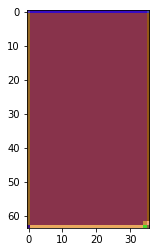

In [30]:
example =   netG(get_fake_image()).data.cpu()
utils.make_grid(example)
im = example / 2 +0.5
im = im.numpy()
plt.imshow(np.transpose(im[2], (1,2,0)))

In [32]:
#save_model()

In [31]:
k_t = train(500, k_t, 0.00001)

  0%|          | 0/500 [00:00<?, ?it/s]

step: 0 / 61 (epoch: 0); loss_generator: 28.865102767944336; loss_discriminator:  0.7179364562034607


  0%|          | 1/500 [00:52<7:19:53, 52.89s/it]

step: 0 / 61 (epoch: 1); loss_generator: 29.107301712036133; loss_discriminator:  0.5228884220123291


  0%|          | 2/500 [01:45<7:19:22, 52.94s/it]

step: 0 / 61 (epoch: 2); loss_generator: 28.742721557617188; loss_discriminator:  0.6018617153167725


  1%|          | 3/500 [02:38<7:18:28, 52.93s/it]

step: 0 / 61 (epoch: 3); loss_generator: 28.968690872192383; loss_discriminator:  0.6428470015525818


  1%|          | 4/500 [03:31<7:17:29, 52.92s/it]

step: 0 / 61 (epoch: 4); loss_generator: 28.795793533325195; loss_discriminator:  0.6653018593788147


  1%|          | 5/500 [04:24<7:16:39, 52.93s/it]

step: 0 / 61 (epoch: 5); loss_generator: 28.575918197631836; loss_discriminator:  0.6600269079208374


  1%|          | 6/500 [05:17<7:15:42, 52.92s/it]

step: 0 / 61 (epoch: 6); loss_generator: 28.90119743347168; loss_discriminator:  0.5192102789878845


  1%|▏         | 7/500 [06:10<7:14:53, 52.93s/it]

step: 0 / 61 (epoch: 7); loss_generator: 28.27418327331543; loss_discriminator:  0.5442614555358887


  2%|▏         | 8/500 [07:03<7:13:54, 52.91s/it]

step: 0 / 61 (epoch: 8); loss_generator: 28.957481384277344; loss_discriminator:  0.6261932849884033


  2%|▏         | 9/500 [07:56<7:13:06, 52.93s/it]

step: 0 / 61 (epoch: 9); loss_generator: 28.66822624206543; loss_discriminator:  0.822948694229126


  2%|▏         | 10/500 [08:49<7:12:13, 52.92s/it]

step: 0 / 61 (epoch: 10); loss_generator: 28.78700065612793; loss_discriminator:  0.49060770869255066


  2%|▏         | 11/500 [09:42<7:11:19, 52.92s/it]

step: 0 / 61 (epoch: 11); loss_generator: 28.40745735168457; loss_discriminator:  0.7594307065010071


  2%|▏         | 12/500 [10:34<7:10:23, 52.92s/it]

step: 0 / 61 (epoch: 12); loss_generator: 28.541820526123047; loss_discriminator:  0.5771575570106506


  3%|▎         | 13/500 [11:28<7:09:34, 52.93s/it]

step: 0 / 61 (epoch: 13); loss_generator: 28.936378479003906; loss_discriminator:  0.8647902011871338


  3%|▎         | 14/500 [12:21<7:08:43, 52.93s/it]

step: 0 / 61 (epoch: 14); loss_generator: 28.679931640625; loss_discriminator:  0.7307361960411072


  3%|▎         | 15/500 [13:13<7:07:51, 52.93s/it]

step: 0 / 61 (epoch: 15); loss_generator: 29.057729721069336; loss_discriminator:  1.044458270072937


  3%|▎         | 16/500 [14:06<7:07:00, 52.93s/it]

step: 0 / 61 (epoch: 16); loss_generator: 28.505680084228516; loss_discriminator:  0.8523383140563965


  3%|▎         | 17/500 [14:59<7:06:10, 52.94s/it]

step: 0 / 61 (epoch: 17); loss_generator: 28.383358001708984; loss_discriminator:  0.6080323457717896


  4%|▎         | 18/500 [15:52<7:05:19, 52.94s/it]

step: 0 / 61 (epoch: 18); loss_generator: 28.755361557006836; loss_discriminator:  0.8422102928161621


  4%|▍         | 19/500 [16:45<7:04:25, 52.94s/it]

step: 0 / 61 (epoch: 19); loss_generator: 29.013479232788086; loss_discriminator:  0.6832142472267151


  4%|▍         | 20/500 [17:38<7:03:35, 52.95s/it]

step: 0 / 61 (epoch: 20); loss_generator: 28.65000343322754; loss_discriminator:  0.7614969611167908


  4%|▍         | 21/500 [18:31<7:02:43, 52.95s/it]

step: 0 / 61 (epoch: 21); loss_generator: 28.754711151123047; loss_discriminator:  0.900879979133606


  4%|▍         | 22/500 [19:24<7:01:51, 52.95s/it]

step: 0 / 61 (epoch: 22); loss_generator: 28.817150115966797; loss_discriminator:  0.677301824092865


  5%|▍         | 23/500 [20:17<7:00:58, 52.95s/it]

step: 0 / 61 (epoch: 23); loss_generator: 28.983203887939453; loss_discriminator:  0.7679193019866943


  5%|▍         | 24/500 [21:10<7:00:04, 52.95s/it]

step: 0 / 61 (epoch: 24); loss_generator: 28.68022346496582; loss_discriminator:  0.6809734106063843


  5%|▌         | 25/500 [22:03<6:59:11, 52.95s/it]

step: 0 / 61 (epoch: 25); loss_generator: 29.053884506225586; loss_discriminator:  0.6545223593711853


  5%|▌         | 26/500 [22:56<6:58:18, 52.95s/it]

step: 0 / 61 (epoch: 26); loss_generator: 28.420209884643555; loss_discriminator:  0.44820350408554077


  5%|▌         | 27/500 [23:49<6:57:25, 52.95s/it]

step: 0 / 61 (epoch: 27); loss_generator: 28.824886322021484; loss_discriminator:  0.43064001202583313


  6%|▌         | 28/500 [24:42<6:56:30, 52.95s/it]

step: 0 / 61 (epoch: 28); loss_generator: 28.98990821838379; loss_discriminator:  0.6534690260887146


  6%|▌         | 29/500 [25:35<6:55:37, 52.95s/it]

step: 0 / 61 (epoch: 29); loss_generator: 28.274721145629883; loss_discriminator:  0.5657677054405212


  6%|▌         | 30/500 [26:28<6:54:44, 52.95s/it]

step: 0 / 61 (epoch: 30); loss_generator: 28.543092727661133; loss_discriminator:  0.7358096837997437


  6%|▌         | 31/500 [27:21<6:53:52, 52.95s/it]

step: 0 / 61 (epoch: 31); loss_generator: 28.99212646484375; loss_discriminator:  0.5874995589256287


  6%|▋         | 32/500 [28:14<6:52:57, 52.94s/it]

step: 0 / 61 (epoch: 32); loss_generator: 28.747697830200195; loss_discriminator:  0.6796918511390686


  7%|▋         | 33/500 [29:07<6:52:04, 52.94s/it]

step: 0 / 61 (epoch: 33); loss_generator: 28.980724334716797; loss_discriminator:  0.7566531896591187


  7%|▋         | 34/500 [29:59<6:51:09, 52.94s/it]

step: 0 / 61 (epoch: 34); loss_generator: 28.82349395751953; loss_discriminator:  0.5975769758224487


  7%|▋         | 35/500 [30:52<6:50:16, 52.94s/it]

step: 0 / 61 (epoch: 35); loss_generator: 28.77753448486328; loss_discriminator:  0.7236332297325134


  7%|▋         | 36/500 [31:45<6:49:23, 52.94s/it]

step: 0 / 61 (epoch: 36); loss_generator: 28.888578414916992; loss_discriminator:  0.5051917433738708


  7%|▋         | 37/500 [32:38<6:48:30, 52.94s/it]

step: 0 / 61 (epoch: 37); loss_generator: 28.72180938720703; loss_discriminator:  0.7494185566902161


  8%|▊         | 38/500 [33:31<6:47:37, 52.94s/it]

step: 0 / 61 (epoch: 38); loss_generator: 28.507888793945312; loss_discriminator:  0.762610137462616


  8%|▊         | 39/500 [34:24<6:46:45, 52.94s/it]

step: 0 / 61 (epoch: 39); loss_generator: 28.710006713867188; loss_discriminator:  0.6765413880348206


  8%|▊         | 40/500 [35:17<6:45:52, 52.94s/it]

step: 0 / 61 (epoch: 40); loss_generator: 28.698091506958008; loss_discriminator:  0.6248952150344849


  8%|▊         | 41/500 [36:10<6:44:58, 52.94s/it]

step: 0 / 61 (epoch: 41); loss_generator: 28.463497161865234; loss_discriminator:  0.7249031066894531


  8%|▊         | 42/500 [37:03<6:44:05, 52.94s/it]

step: 0 / 61 (epoch: 42); loss_generator: 28.873661041259766; loss_discriminator:  0.6767754554748535


  9%|▊         | 43/500 [37:56<6:43:13, 52.94s/it]

step: 0 / 61 (epoch: 43); loss_generator: 28.76091194152832; loss_discriminator:  0.7994320392608643


  9%|▉         | 44/500 [38:49<6:42:19, 52.94s/it]

step: 0 / 61 (epoch: 44); loss_generator: 28.901662826538086; loss_discriminator:  0.7723919749259949


  9%|▉         | 45/500 [39:42<6:41:26, 52.94s/it]

step: 0 / 61 (epoch: 45); loss_generator: 28.65195655822754; loss_discriminator:  0.6569811701774597


  9%|▉         | 46/500 [40:35<6:40:32, 52.94s/it]

step: 0 / 61 (epoch: 46); loss_generator: 28.647092819213867; loss_discriminator:  0.7268221974372864


  9%|▉         | 47/500 [41:28<6:39:40, 52.94s/it]

step: 0 / 61 (epoch: 47); loss_generator: 28.97895050048828; loss_discriminator:  0.589298665523529


 10%|▉         | 48/500 [42:21<6:38:48, 52.94s/it]

step: 0 / 61 (epoch: 48); loss_generator: 28.790124893188477; loss_discriminator:  0.2876514792442322


 10%|▉         | 49/500 [43:13<6:37:54, 52.94s/it]

step: 0 / 61 (epoch: 49); loss_generator: 28.99911117553711; loss_discriminator:  0.8445433378219604


 10%|█         | 50/500 [44:06<6:37:02, 52.94s/it]

step: 0 / 61 (epoch: 50); loss_generator: 28.67341423034668; loss_discriminator:  0.5299199223518372


 10%|█         | 51/500 [44:59<6:36:10, 52.94s/it]

step: 0 / 61 (epoch: 51); loss_generator: 28.425888061523438; loss_discriminator:  0.6178836226463318


 10%|█         | 52/500 [45:52<6:35:17, 52.94s/it]

step: 0 / 61 (epoch: 52); loss_generator: 28.667848587036133; loss_discriminator:  0.831449568271637


 11%|█         | 53/500 [46:45<6:34:24, 52.94s/it]

step: 0 / 61 (epoch: 53); loss_generator: 28.596485137939453; loss_discriminator:  0.7227184176445007


 11%|█         | 54/500 [47:38<6:33:31, 52.94s/it]

step: 0 / 61 (epoch: 54); loss_generator: 29.084726333618164; loss_discriminator:  0.7262833118438721


 11%|█         | 55/500 [48:31<6:32:37, 52.94s/it]

step: 0 / 61 (epoch: 55); loss_generator: 28.83924102783203; loss_discriminator:  0.756039559841156


 11%|█         | 56/500 [49:24<6:31:44, 52.94s/it]

step: 0 / 61 (epoch: 56); loss_generator: 28.436691284179688; loss_discriminator:  0.7042806148529053


 11%|█▏        | 57/500 [50:17<6:30:51, 52.94s/it]

step: 0 / 61 (epoch: 57); loss_generator: 28.61673355102539; loss_discriminator:  0.706005871295929


 12%|█▏        | 58/500 [51:10<6:29:58, 52.94s/it]

step: 0 / 61 (epoch: 58); loss_generator: 28.703649520874023; loss_discriminator:  0.563456654548645


 12%|█▏        | 59/500 [52:03<6:29:05, 52.94s/it]

step: 0 / 61 (epoch: 59); loss_generator: 28.670034408569336; loss_discriminator:  0.5701679587364197


 12%|█▏        | 60/500 [52:56<6:28:12, 52.94s/it]

step: 0 / 61 (epoch: 60); loss_generator: 28.91241455078125; loss_discriminator:  0.5563291907310486


 12%|█▏        | 61/500 [53:49<6:27:19, 52.94s/it]

step: 0 / 61 (epoch: 61); loss_generator: 28.48806381225586; loss_discriminator:  0.5950183272361755


 12%|█▏        | 62/500 [54:42<6:26:26, 52.94s/it]

step: 0 / 61 (epoch: 62); loss_generator: 28.658830642700195; loss_discriminator:  0.7525128722190857


 13%|█▎        | 63/500 [55:35<6:25:33, 52.94s/it]

step: 0 / 61 (epoch: 63); loss_generator: 28.888776779174805; loss_discriminator:  0.6235030293464661


 13%|█▎        | 64/500 [56:27<6:24:40, 52.94s/it]

step: 0 / 61 (epoch: 64); loss_generator: 28.27011489868164; loss_discriminator:  0.8422577381134033


 13%|█▎        | 65/500 [57:20<6:23:47, 52.94s/it]

step: 0 / 61 (epoch: 65); loss_generator: 28.645002365112305; loss_discriminator:  0.46179988980293274


 13%|█▎        | 66/500 [58:13<6:22:54, 52.94s/it]

step: 0 / 61 (epoch: 66); loss_generator: 28.566286087036133; loss_discriminator:  0.8024871349334717


 13%|█▎        | 67/500 [59:06<6:22:01, 52.94s/it]

step: 0 / 61 (epoch: 67); loss_generator: 28.981287002563477; loss_discriminator:  0.5911036729812622


 14%|█▎        | 68/500 [59:59<6:21:08, 52.94s/it]

step: 0 / 61 (epoch: 68); loss_generator: 28.677114486694336; loss_discriminator:  0.5328067541122437


 14%|█▍        | 69/500 [1:00:52<6:20:15, 52.94s/it]

step: 0 / 61 (epoch: 69); loss_generator: 28.891456604003906; loss_discriminator:  0.5772891044616699


 14%|█▍        | 70/500 [1:01:45<6:19:22, 52.94s/it]

step: 0 / 61 (epoch: 70); loss_generator: 28.96096420288086; loss_discriminator:  0.9420169591903687


 14%|█▍        | 71/500 [1:02:38<6:18:28, 52.93s/it]

step: 0 / 61 (epoch: 71); loss_generator: 28.47034454345703; loss_discriminator:  0.6925541758537292


 14%|█▍        | 72/500 [1:03:31<6:17:35, 52.93s/it]

step: 0 / 61 (epoch: 72); loss_generator: 28.574033737182617; loss_discriminator:  0.7725740075111389


 15%|█▍        | 73/500 [1:04:24<6:16:42, 52.93s/it]

step: 0 / 61 (epoch: 73); loss_generator: 28.454008102416992; loss_discriminator:  0.6628415584564209


 15%|█▍        | 74/500 [1:05:17<6:15:50, 52.94s/it]

step: 0 / 61 (epoch: 74); loss_generator: 28.369625091552734; loss_discriminator:  1.1605055332183838


 15%|█▌        | 75/500 [1:06:10<6:14:57, 52.93s/it]

step: 0 / 61 (epoch: 75); loss_generator: 28.839712142944336; loss_discriminator:  0.7983548641204834


 15%|█▌        | 76/500 [1:07:03<6:14:04, 52.94s/it]

step: 0 / 61 (epoch: 76); loss_generator: 28.70481300354004; loss_discriminator:  0.8437795042991638


 15%|█▌        | 77/500 [1:07:56<6:13:12, 52.94s/it]

step: 0 / 61 (epoch: 77); loss_generator: 28.964372634887695; loss_discriminator:  0.2854560613632202


 16%|█▌        | 78/500 [1:08:49<6:12:19, 52.94s/it]

step: 0 / 61 (epoch: 78); loss_generator: 28.716407775878906; loss_discriminator:  0.8147237300872803


 16%|█▌        | 79/500 [1:09:42<6:11:26, 52.94s/it]

step: 0 / 61 (epoch: 79); loss_generator: 28.568607330322266; loss_discriminator:  0.38956329226493835


 16%|█▌        | 80/500 [1:10:35<6:10:34, 52.94s/it]

step: 0 / 61 (epoch: 80); loss_generator: 28.718164443969727; loss_discriminator:  0.5168289542198181


 16%|█▌        | 81/500 [1:11:28<6:09:41, 52.94s/it]

step: 0 / 61 (epoch: 81); loss_generator: 28.967378616333008; loss_discriminator:  0.6278533935546875


 16%|█▋        | 82/500 [1:12:21<6:08:49, 52.94s/it]

step: 0 / 61 (epoch: 82); loss_generator: 28.289209365844727; loss_discriminator:  0.5013117790222168


 17%|█▋        | 83/500 [1:13:14<6:07:56, 52.94s/it]

step: 0 / 61 (epoch: 83); loss_generator: 28.624191284179688; loss_discriminator:  0.5799582600593567


 17%|█▋        | 84/500 [1:14:07<6:07:03, 52.94s/it]

step: 0 / 61 (epoch: 84); loss_generator: 28.769521713256836; loss_discriminator:  0.6064333319664001


 17%|█▋        | 85/500 [1:15:00<6:06:10, 52.94s/it]

step: 0 / 61 (epoch: 85); loss_generator: 28.563188552856445; loss_discriminator:  0.48198604583740234


 17%|█▋        | 86/500 [1:15:53<6:05:18, 52.94s/it]

step: 0 / 61 (epoch: 86); loss_generator: 28.93213653564453; loss_discriminator:  0.5147124528884888


 17%|█▋        | 87/500 [1:16:46<6:04:25, 52.94s/it]

step: 0 / 61 (epoch: 87); loss_generator: 28.59246826171875; loss_discriminator:  0.9081024527549744


 18%|█▊        | 88/500 [1:17:39<6:03:32, 52.94s/it]

step: 0 / 61 (epoch: 88); loss_generator: 29.032981872558594; loss_discriminator:  0.8294935822486877


 18%|█▊        | 89/500 [1:18:32<6:02:40, 52.94s/it]

step: 0 / 61 (epoch: 89); loss_generator: 28.877241134643555; loss_discriminator:  0.2758956253528595


 18%|█▊        | 90/500 [1:19:25<6:01:47, 52.94s/it]

step: 0 / 61 (epoch: 90); loss_generator: 28.846115112304688; loss_discriminator:  0.6221755146980286


 18%|█▊        | 91/500 [1:20:17<6:00:54, 52.94s/it]

step: 0 / 61 (epoch: 91); loss_generator: 28.599605560302734; loss_discriminator:  0.9091475009918213


 18%|█▊        | 92/500 [1:21:11<6:00:01, 52.95s/it]

step: 0 / 61 (epoch: 92); loss_generator: 28.962804794311523; loss_discriminator:  0.678557276725769


 19%|█▊        | 93/500 [1:22:03<5:59:08, 52.95s/it]

step: 0 / 61 (epoch: 93); loss_generator: 28.399873733520508; loss_discriminator:  0.7938300967216492


 19%|█▉        | 94/500 [1:22:57<5:58:16, 52.95s/it]

step: 0 / 61 (epoch: 94); loss_generator: 28.78813362121582; loss_discriminator:  0.553673267364502


 19%|█▉        | 95/500 [1:23:50<5:57:24, 52.95s/it]

step: 0 / 61 (epoch: 95); loss_generator: 28.527196884155273; loss_discriminator:  0.7255936861038208


 19%|█▉        | 96/500 [1:24:43<5:56:31, 52.95s/it]

step: 0 / 61 (epoch: 96); loss_generator: 28.91285514831543; loss_discriminator:  0.6756359338760376


 19%|█▉        | 97/500 [1:25:36<5:55:38, 52.95s/it]

step: 0 / 61 (epoch: 97); loss_generator: 28.445959091186523; loss_discriminator:  0.9163169860839844


 20%|█▉        | 98/500 [1:26:29<5:54:46, 52.95s/it]

step: 0 / 61 (epoch: 98); loss_generator: 28.90995979309082; loss_discriminator:  0.2692984640598297


 20%|█▉        | 99/500 [1:27:22<5:53:53, 52.95s/it]

step: 0 / 61 (epoch: 99); loss_generator: 28.912986755371094; loss_discriminator:  0.879063069820404


 20%|██        | 100/500 [1:28:15<5:53:00, 52.95s/it]

step: 0 / 61 (epoch: 100); loss_generator: 28.75704002380371; loss_discriminator:  0.8423459529876709


 20%|██        | 101/500 [1:29:08<5:52:07, 52.95s/it]

step: 0 / 61 (epoch: 101); loss_generator: 28.78179931640625; loss_discriminator:  1.0030465126037598


 20%|██        | 102/500 [1:30:00<5:51:14, 52.95s/it]

step: 0 / 61 (epoch: 102); loss_generator: 28.652320861816406; loss_discriminator:  0.7959144115447998


 21%|██        | 103/500 [1:30:53<5:50:21, 52.95s/it]

step: 0 / 61 (epoch: 103); loss_generator: 28.484102249145508; loss_discriminator:  0.785958468914032


 21%|██        | 104/500 [1:31:46<5:49:28, 52.95s/it]

step: 0 / 61 (epoch: 104); loss_generator: 28.734285354614258; loss_discriminator:  0.43690216541290283


 21%|██        | 105/500 [1:32:39<5:48:35, 52.95s/it]

step: 0 / 61 (epoch: 105); loss_generator: 28.594783782958984; loss_discriminator:  0.3995680510997772


 21%|██        | 106/500 [1:33:32<5:47:42, 52.95s/it]

step: 0 / 61 (epoch: 106); loss_generator: 29.206239700317383; loss_discriminator:  0.686738908290863


 21%|██▏       | 107/500 [1:34:25<5:46:49, 52.95s/it]

step: 0 / 61 (epoch: 107); loss_generator: 28.52911376953125; loss_discriminator:  0.5495283603668213


 22%|██▏       | 108/500 [1:35:18<5:45:56, 52.95s/it]

step: 0 / 61 (epoch: 108); loss_generator: 28.488330841064453; loss_discriminator:  0.7655038237571716


 22%|██▏       | 109/500 [1:36:11<5:45:03, 52.95s/it]

step: 0 / 61 (epoch: 109); loss_generator: 28.805864334106445; loss_discriminator:  0.5438899993896484


 22%|██▏       | 110/500 [1:37:04<5:44:10, 52.95s/it]

step: 0 / 61 (epoch: 110); loss_generator: 28.498510360717773; loss_discriminator:  0.6281397938728333


 22%|██▏       | 111/500 [1:37:57<5:43:17, 52.95s/it]

step: 0 / 61 (epoch: 111); loss_generator: 28.704647064208984; loss_discriminator:  1.1096479892730713


 22%|██▏       | 112/500 [1:38:50<5:42:25, 52.95s/it]

step: 0 / 61 (epoch: 112); loss_generator: 28.551847457885742; loss_discriminator:  0.5619431138038635


 23%|██▎       | 113/500 [1:39:43<5:41:32, 52.95s/it]

step: 0 / 61 (epoch: 113); loss_generator: 28.735464096069336; loss_discriminator:  0.6738305687904358


 23%|██▎       | 114/500 [1:40:36<5:40:39, 52.95s/it]

step: 0 / 61 (epoch: 114); loss_generator: 28.940481185913086; loss_discriminator:  0.9805943369865417


 23%|██▎       | 115/500 [1:41:29<5:39:46, 52.95s/it]

step: 0 / 61 (epoch: 115); loss_generator: 29.02425765991211; loss_discriminator:  0.46321460604667664


 23%|██▎       | 116/500 [1:42:22<5:38:53, 52.95s/it]

step: 0 / 61 (epoch: 116); loss_generator: 28.732223510742188; loss_discriminator:  0.8275222182273865


 23%|██▎       | 117/500 [1:43:15<5:38:00, 52.95s/it]

step: 0 / 61 (epoch: 117); loss_generator: 29.00424575805664; loss_discriminator:  0.6890151500701904


 24%|██▎       | 118/500 [1:44:08<5:37:07, 52.95s/it]

step: 0 / 61 (epoch: 118); loss_generator: 28.715242385864258; loss_discriminator:  0.23455692827701569


 24%|██▍       | 119/500 [1:45:01<5:36:14, 52.95s/it]

step: 0 / 61 (epoch: 119); loss_generator: 28.853944778442383; loss_discriminator:  1.0690851211547852


 24%|██▍       | 120/500 [1:45:54<5:35:21, 52.95s/it]

step: 0 / 61 (epoch: 120); loss_generator: 28.834123611450195; loss_discriminator:  0.543058454990387


 24%|██▍       | 121/500 [1:46:47<5:34:28, 52.95s/it]

step: 0 / 61 (epoch: 121); loss_generator: 28.749162673950195; loss_discriminator:  0.37258991599082947


 24%|██▍       | 122/500 [1:47:40<5:33:35, 52.95s/it]

step: 0 / 61 (epoch: 122); loss_generator: 28.694887161254883; loss_discriminator:  0.6213074326515198


 25%|██▍       | 123/500 [1:48:32<5:32:42, 52.95s/it]

step: 0 / 61 (epoch: 123); loss_generator: 28.631763458251953; loss_discriminator:  0.663801908493042


 25%|██▍       | 124/500 [1:49:25<5:31:49, 52.95s/it]

step: 0 / 61 (epoch: 124); loss_generator: 29.120458602905273; loss_discriminator:  0.4550324082374573


 25%|██▌       | 125/500 [1:50:18<5:30:56, 52.95s/it]

step: 0 / 61 (epoch: 125); loss_generator: 28.783906936645508; loss_discriminator:  1.1213929653167725


 25%|██▌       | 126/500 [1:51:11<5:30:03, 52.95s/it]

step: 0 / 61 (epoch: 126); loss_generator: 29.104333877563477; loss_discriminator:  0.4327104985713959


 25%|██▌       | 127/500 [1:52:04<5:29:10, 52.95s/it]

step: 0 / 61 (epoch: 127); loss_generator: 28.307510375976562; loss_discriminator:  0.6233778595924377


 26%|██▌       | 128/500 [1:52:57<5:28:17, 52.95s/it]

step: 0 / 61 (epoch: 128); loss_generator: 28.639766693115234; loss_discriminator:  0.8899418711662292


 26%|██▌       | 129/500 [1:53:50<5:27:24, 52.95s/it]

step: 0 / 61 (epoch: 129); loss_generator: 28.57137680053711; loss_discriminator:  0.6964131593704224


 26%|██▌       | 130/500 [1:54:43<5:26:31, 52.95s/it]

step: 0 / 61 (epoch: 130); loss_generator: 29.10964584350586; loss_discriminator:  0.7214523553848267


 26%|██▌       | 131/500 [1:55:36<5:25:38, 52.95s/it]

step: 0 / 61 (epoch: 131); loss_generator: 29.00375747680664; loss_discriminator:  0.2936698794364929


 26%|██▋       | 132/500 [1:56:29<5:24:45, 52.95s/it]

step: 0 / 61 (epoch: 132); loss_generator: 28.985939025878906; loss_discriminator:  0.7848543524742126


 27%|██▋       | 133/500 [1:57:22<5:23:52, 52.95s/it]

step: 0 / 61 (epoch: 133); loss_generator: 28.881521224975586; loss_discriminator:  0.7535693049430847


 27%|██▋       | 134/500 [1:58:15<5:22:59, 52.95s/it]

step: 0 / 61 (epoch: 134); loss_generator: 29.230749130249023; loss_discriminator:  0.5955294966697693


 27%|██▋       | 135/500 [1:59:08<5:22:06, 52.95s/it]

step: 0 / 61 (epoch: 135); loss_generator: 29.02434539794922; loss_discriminator:  0.6073153018951416


 27%|██▋       | 136/500 [2:00:01<5:21:13, 52.95s/it]

step: 0 / 61 (epoch: 136); loss_generator: 28.61328887939453; loss_discriminator:  1.09708833694458


 27%|██▋       | 137/500 [2:00:54<5:20:21, 52.95s/it]

step: 0 / 61 (epoch: 137); loss_generator: 28.759138107299805; loss_discriminator:  1.0058977603912354


 28%|██▊       | 138/500 [2:01:47<5:19:28, 52.95s/it]

step: 0 / 61 (epoch: 138); loss_generator: 28.84348487854004; loss_discriminator:  0.47170576453208923


 28%|██▊       | 139/500 [2:02:40<5:18:35, 52.95s/it]

step: 0 / 61 (epoch: 139); loss_generator: 29.136960983276367; loss_discriminator:  0.4622807204723358


 28%|██▊       | 140/500 [2:03:33<5:17:43, 52.95s/it]

step: 0 / 61 (epoch: 140); loss_generator: 29.17169952392578; loss_discriminator:  0.7212223410606384


 28%|██▊       | 141/500 [2:04:26<5:16:50, 52.95s/it]

step: 0 / 61 (epoch: 141); loss_generator: 28.753185272216797; loss_discriminator:  0.4215792119503021


 28%|██▊       | 142/500 [2:05:19<5:15:57, 52.95s/it]

step: 0 / 61 (epoch: 142); loss_generator: 28.861295700073242; loss_discriminator:  0.5322328209877014


 29%|██▊       | 143/500 [2:06:12<5:15:04, 52.95s/it]

step: 0 / 61 (epoch: 143); loss_generator: 28.863094329833984; loss_discriminator:  0.7188894748687744


 29%|██▉       | 144/500 [2:07:05<5:14:11, 52.95s/it]

step: 0 / 61 (epoch: 144); loss_generator: 28.612165451049805; loss_discriminator:  0.7181040644645691


 29%|██▉       | 145/500 [2:07:58<5:13:18, 52.95s/it]

step: 0 / 61 (epoch: 145); loss_generator: 28.64967918395996; loss_discriminator:  0.37618526816368103


 29%|██▉       | 146/500 [2:08:51<5:12:25, 52.95s/it]

step: 0 / 61 (epoch: 146); loss_generator: 28.869291305541992; loss_discriminator:  0.6844115257263184


 29%|██▉       | 147/500 [2:09:44<5:11:32, 52.95s/it]

step: 0 / 61 (epoch: 147); loss_generator: 29.015335083007812; loss_discriminator:  0.7721458673477173


 30%|██▉       | 148/500 [2:10:37<5:10:39, 52.95s/it]

step: 0 / 61 (epoch: 148); loss_generator: 28.794918060302734; loss_discriminator:  0.655655026435852


 30%|██▉       | 149/500 [2:11:30<5:09:46, 52.95s/it]

step: 0 / 61 (epoch: 149); loss_generator: 28.985998153686523; loss_discriminator:  0.6350942254066467


 30%|███       | 150/500 [2:12:22<5:08:53, 52.95s/it]

step: 0 / 61 (epoch: 150); loss_generator: 28.70989227294922; loss_discriminator:  0.6083351969718933


 30%|███       | 151/500 [2:13:15<5:08:00, 52.95s/it]

step: 0 / 61 (epoch: 151); loss_generator: 28.589916229248047; loss_discriminator:  0.761795163154602


 30%|███       | 152/500 [2:14:08<5:07:07, 52.95s/it]

step: 0 / 61 (epoch: 152); loss_generator: 28.67355728149414; loss_discriminator:  0.7717142701148987


 31%|███       | 153/500 [2:15:01<5:06:14, 52.95s/it]

step: 0 / 61 (epoch: 153); loss_generator: 28.716163635253906; loss_discriminator:  0.5575230717658997


 31%|███       | 154/500 [2:15:54<5:05:21, 52.95s/it]

step: 0 / 61 (epoch: 154); loss_generator: 28.97643280029297; loss_discriminator:  0.673481822013855


 31%|███       | 155/500 [2:16:47<5:04:28, 52.95s/it]

step: 0 / 61 (epoch: 155); loss_generator: 29.193025588989258; loss_discriminator:  0.6278013586997986


 31%|███       | 156/500 [2:17:40<5:03:35, 52.95s/it]

step: 0 / 61 (epoch: 156); loss_generator: 28.97467041015625; loss_discriminator:  0.47448742389678955


 31%|███▏      | 157/500 [2:18:33<5:02:42, 52.95s/it]

step: 0 / 61 (epoch: 157); loss_generator: 28.809675216674805; loss_discriminator:  0.5612987279891968


 32%|███▏      | 158/500 [2:19:26<5:01:49, 52.95s/it]

step: 0 / 61 (epoch: 158); loss_generator: 28.79864501953125; loss_discriminator:  0.48176559805870056


 32%|███▏      | 159/500 [2:20:19<5:00:56, 52.95s/it]

step: 0 / 61 (epoch: 159); loss_generator: 28.861433029174805; loss_discriminator:  0.6933701038360596


 32%|███▏      | 160/500 [2:21:12<5:00:03, 52.95s/it]

step: 0 / 61 (epoch: 160); loss_generator: 28.49874496459961; loss_discriminator:  0.4732144773006439


 32%|███▏      | 161/500 [2:22:05<4:59:10, 52.95s/it]

step: 0 / 61 (epoch: 161); loss_generator: 28.765100479125977; loss_discriminator:  0.68111252784729


 32%|███▏      | 162/500 [2:22:58<4:58:17, 52.95s/it]

step: 0 / 61 (epoch: 162); loss_generator: 28.74270248413086; loss_discriminator:  0.6596752405166626


 33%|███▎      | 163/500 [2:23:51<4:57:25, 52.95s/it]

step: 0 / 61 (epoch: 163); loss_generator: 28.58478546142578; loss_discriminator:  0.7883289456367493


 33%|███▎      | 164/500 [2:24:44<4:56:32, 52.95s/it]

step: 0 / 61 (epoch: 164); loss_generator: 29.137399673461914; loss_discriminator:  0.6352490186691284


 33%|███▎      | 165/500 [2:25:37<4:55:39, 52.95s/it]

step: 0 / 61 (epoch: 165); loss_generator: 28.864213943481445; loss_discriminator:  0.7045693397521973


 33%|███▎      | 166/500 [2:26:30<4:54:46, 52.95s/it]

step: 0 / 61 (epoch: 166); loss_generator: 29.00385856628418; loss_discriminator:  0.6770382523536682


 33%|███▎      | 167/500 [2:27:23<4:53:53, 52.95s/it]

step: 0 / 61 (epoch: 167); loss_generator: 28.930591583251953; loss_discriminator:  0.6705305576324463


 34%|███▎      | 168/500 [2:28:16<4:53:00, 52.95s/it]

step: 0 / 61 (epoch: 168); loss_generator: 28.552017211914062; loss_discriminator:  0.8112227320671082


 34%|███▍      | 169/500 [2:29:08<4:52:07, 52.95s/it]

step: 0 / 61 (epoch: 169); loss_generator: 28.78999137878418; loss_discriminator:  0.6149027943611145


 34%|███▍      | 170/500 [2:30:01<4:51:14, 52.95s/it]

step: 0 / 61 (epoch: 170); loss_generator: 28.71407127380371; loss_discriminator:  0.8480861186981201


 34%|███▍      | 171/500 [2:30:54<4:50:21, 52.95s/it]

step: 0 / 61 (epoch: 171); loss_generator: 28.949960708618164; loss_discriminator:  0.5986934304237366


 34%|███▍      | 172/500 [2:31:47<4:49:28, 52.95s/it]

step: 0 / 61 (epoch: 172); loss_generator: 29.14347267150879; loss_discriminator:  0.6474406123161316


 35%|███▍      | 173/500 [2:32:40<4:48:35, 52.95s/it]

step: 0 / 61 (epoch: 173); loss_generator: 28.80720329284668; loss_discriminator:  0.46537500619888306


 35%|███▍      | 174/500 [2:33:33<4:47:42, 52.95s/it]

step: 0 / 61 (epoch: 174); loss_generator: 28.76870346069336; loss_discriminator:  0.73100745677948


 35%|███▌      | 175/500 [2:34:26<4:46:49, 52.95s/it]

step: 0 / 61 (epoch: 175); loss_generator: 28.986509323120117; loss_discriminator:  0.3984091579914093


 35%|███▌      | 176/500 [2:35:19<4:45:56, 52.95s/it]

step: 0 / 61 (epoch: 176); loss_generator: 28.97967529296875; loss_discriminator:  0.4624592959880829


 35%|███▌      | 177/500 [2:36:12<4:45:03, 52.95s/it]

step: 0 / 61 (epoch: 177); loss_generator: 28.594995498657227; loss_discriminator:  0.779595136642456


 36%|███▌      | 178/500 [2:37:05<4:44:10, 52.95s/it]

step: 0 / 61 (epoch: 178); loss_generator: 28.229625701904297; loss_discriminator:  0.9308554530143738


 36%|███▌      | 179/500 [2:37:58<4:43:17, 52.95s/it]

step: 0 / 61 (epoch: 179); loss_generator: 28.576074600219727; loss_discriminator:  0.8354858160018921


 36%|███▌      | 180/500 [2:38:51<4:42:24, 52.95s/it]

step: 0 / 61 (epoch: 180); loss_generator: 28.968772888183594; loss_discriminator:  0.6684699654579163


 36%|███▌      | 181/500 [2:39:44<4:41:31, 52.95s/it]

step: 0 / 61 (epoch: 181); loss_generator: 28.460805892944336; loss_discriminator:  0.7661654949188232


 36%|███▋      | 182/500 [2:40:37<4:40:38, 52.95s/it]

step: 0 / 61 (epoch: 182); loss_generator: 28.695444107055664; loss_discriminator:  0.5367050170898438


 37%|███▋      | 183/500 [2:41:30<4:39:45, 52.95s/it]

step: 0 / 61 (epoch: 183); loss_generator: 28.658891677856445; loss_discriminator:  0.8201121091842651


 37%|███▋      | 184/500 [2:42:23<4:38:52, 52.95s/it]

step: 0 / 61 (epoch: 184); loss_generator: 28.744367599487305; loss_discriminator:  1.1226866245269775


 37%|███▋      | 185/500 [2:43:16<4:37:59, 52.95s/it]

step: 0 / 61 (epoch: 185); loss_generator: 28.844486236572266; loss_discriminator:  0.665940523147583


 37%|███▋      | 186/500 [2:44:09<4:37:06, 52.95s/it]

step: 0 / 61 (epoch: 186); loss_generator: 28.536645889282227; loss_discriminator:  0.8532431125640869


 37%|███▋      | 187/500 [2:45:02<4:36:14, 52.95s/it]

step: 0 / 61 (epoch: 187); loss_generator: 29.11898422241211; loss_discriminator:  0.8675870299339294


 38%|███▊      | 188/500 [2:45:55<4:35:21, 52.95s/it]

step: 0 / 61 (epoch: 188); loss_generator: 28.684452056884766; loss_discriminator:  0.7895229458808899


 38%|███▊      | 189/500 [2:46:48<4:34:28, 52.95s/it]

step: 0 / 61 (epoch: 189); loss_generator: 28.91622543334961; loss_discriminator:  0.6859908103942871


 38%|███▊      | 190/500 [2:47:40<4:33:35, 52.95s/it]

step: 0 / 61 (epoch: 190); loss_generator: 28.990888595581055; loss_discriminator:  0.8515686392784119


 38%|███▊      | 191/500 [2:48:33<4:32:42, 52.95s/it]

step: 0 / 61 (epoch: 191); loss_generator: 28.843929290771484; loss_discriminator:  0.8190673589706421


 38%|███▊      | 192/500 [2:49:26<4:31:49, 52.95s/it]

step: 0 / 61 (epoch: 192); loss_generator: 28.35214614868164; loss_discriminator:  0.6751139163970947


 39%|███▊      | 193/500 [2:50:19<4:30:56, 52.95s/it]

step: 0 / 61 (epoch: 193); loss_generator: 28.955760955810547; loss_discriminator:  0.5404107570648193


 39%|███▉      | 194/500 [2:51:12<4:30:03, 52.95s/it]

step: 0 / 61 (epoch: 194); loss_generator: 28.811433792114258; loss_discriminator:  0.695009171962738


 39%|███▉      | 195/500 [2:52:05<4:29:10, 52.95s/it]

step: 0 / 61 (epoch: 195); loss_generator: 28.76174545288086; loss_discriminator:  0.5144126415252686


 39%|███▉      | 196/500 [2:52:58<4:28:17, 52.95s/it]

step: 0 / 61 (epoch: 196); loss_generator: 28.627012252807617; loss_discriminator:  0.6288602352142334


 39%|███▉      | 197/500 [2:53:51<4:27:25, 52.95s/it]

step: 0 / 61 (epoch: 197); loss_generator: 29.09239959716797; loss_discriminator:  0.6126769781112671


 40%|███▉      | 198/500 [2:54:44<4:26:32, 52.95s/it]

step: 0 / 61 (epoch: 198); loss_generator: 29.121849060058594; loss_discriminator:  0.6653978824615479


 40%|███▉      | 199/500 [2:55:37<4:25:38, 52.95s/it]

step: 0 / 61 (epoch: 199); loss_generator: 28.696516036987305; loss_discriminator:  0.6580306887626648


 40%|████      | 200/500 [2:56:30<4:24:45, 52.95s/it]

step: 0 / 61 (epoch: 200); loss_generator: 28.93971061706543; loss_discriminator:  0.5801188945770264


 40%|████      | 201/500 [2:57:23<4:23:53, 52.95s/it]

step: 0 / 61 (epoch: 201); loss_generator: 28.843591690063477; loss_discriminator:  0.46226006746292114


 40%|████      | 202/500 [2:58:16<4:23:00, 52.95s/it]

step: 0 / 61 (epoch: 202); loss_generator: 29.010297775268555; loss_discriminator:  0.42733970284461975


 41%|████      | 203/500 [2:59:09<4:22:07, 52.95s/it]

step: 0 / 61 (epoch: 203); loss_generator: 29.067073822021484; loss_discriminator:  0.6850269436836243


 41%|████      | 204/500 [3:00:02<4:21:14, 52.95s/it]

step: 0 / 61 (epoch: 204); loss_generator: 28.73348045349121; loss_discriminator:  0.590595543384552


 41%|████      | 205/500 [3:00:55<4:20:21, 52.95s/it]

step: 0 / 61 (epoch: 205); loss_generator: 28.59365463256836; loss_discriminator:  0.7683072686195374


 41%|████      | 206/500 [3:01:48<4:19:28, 52.95s/it]

step: 0 / 61 (epoch: 206); loss_generator: 29.135652542114258; loss_discriminator:  0.7433381676673889


 41%|████▏     | 207/500 [3:02:41<4:18:35, 52.95s/it]

step: 0 / 61 (epoch: 207); loss_generator: 28.991209030151367; loss_discriminator:  0.398053914308548


 42%|████▏     | 208/500 [3:03:34<4:17:42, 52.95s/it]

step: 0 / 61 (epoch: 208); loss_generator: 28.630552291870117; loss_discriminator:  1.143193244934082


 42%|████▏     | 209/500 [3:04:27<4:16:49, 52.95s/it]

step: 0 / 61 (epoch: 209); loss_generator: 29.194398880004883; loss_discriminator:  1.0759114027023315


 42%|████▏     | 210/500 [3:05:20<4:15:56, 52.95s/it]

step: 0 / 61 (epoch: 210); loss_generator: 28.88294792175293; loss_discriminator:  0.7039116621017456


 42%|████▏     | 211/500 [3:06:13<4:15:03, 52.95s/it]

step: 0 / 61 (epoch: 211); loss_generator: 28.851961135864258; loss_discriminator:  0.4538496434688568


 42%|████▏     | 212/500 [3:07:06<4:14:10, 52.95s/it]

step: 0 / 61 (epoch: 212); loss_generator: 28.920719146728516; loss_discriminator:  0.7136854529380798


 43%|████▎     | 213/500 [3:07:59<4:13:17, 52.95s/it]

step: 0 / 61 (epoch: 213); loss_generator: 29.115856170654297; loss_discriminator:  0.417886883020401


 43%|████▎     | 214/500 [3:08:51<4:12:24, 52.95s/it]

step: 0 / 61 (epoch: 214); loss_generator: 28.595972061157227; loss_discriminator:  0.81485915184021


 43%|████▎     | 215/500 [3:09:44<4:11:31, 52.95s/it]

step: 0 / 61 (epoch: 215); loss_generator: 28.914710998535156; loss_discriminator:  0.6497334241867065


 43%|████▎     | 216/500 [3:10:37<4:10:38, 52.95s/it]

step: 0 / 61 (epoch: 216); loss_generator: 29.047286987304688; loss_discriminator:  0.4879823327064514


 43%|████▎     | 217/500 [3:11:30<4:09:45, 52.95s/it]

step: 0 / 61 (epoch: 217); loss_generator: 28.947145462036133; loss_discriminator:  0.6579274535179138


 44%|████▎     | 218/500 [3:12:23<4:08:52, 52.95s/it]

step: 0 / 61 (epoch: 218); loss_generator: 28.921070098876953; loss_discriminator:  0.7692760229110718


 44%|████▍     | 219/500 [3:13:16<4:07:59, 52.95s/it]

step: 0 / 61 (epoch: 219); loss_generator: 28.92713737487793; loss_discriminator:  0.7743666172027588


 44%|████▍     | 220/500 [3:14:09<4:07:06, 52.95s/it]

step: 0 / 61 (epoch: 220); loss_generator: 28.94402313232422; loss_discriminator:  0.9871518015861511


 44%|████▍     | 221/500 [3:15:02<4:06:14, 52.95s/it]

step: 0 / 61 (epoch: 221); loss_generator: 29.090726852416992; loss_discriminator:  0.4666416645050049


 44%|████▍     | 222/500 [3:15:55<4:05:21, 52.95s/it]

step: 0 / 61 (epoch: 222); loss_generator: 28.82731056213379; loss_discriminator:  0.5995678901672363


 45%|████▍     | 223/500 [3:16:48<4:04:28, 52.95s/it]

step: 0 / 61 (epoch: 223); loss_generator: 28.875368118286133; loss_discriminator:  0.8446311354637146


 45%|████▍     | 224/500 [3:17:41<4:03:35, 52.95s/it]

step: 0 / 61 (epoch: 224); loss_generator: 28.79106903076172; loss_discriminator:  0.7456551790237427


 45%|████▌     | 225/500 [3:18:34<4:02:42, 52.95s/it]

step: 0 / 61 (epoch: 225); loss_generator: 28.749876022338867; loss_discriminator:  0.5693146586418152


 45%|████▌     | 226/500 [3:19:27<4:01:49, 52.95s/it]

step: 0 / 61 (epoch: 226); loss_generator: 29.111190795898438; loss_discriminator:  0.7163479924201965


 45%|████▌     | 227/500 [3:20:20<4:00:56, 52.95s/it]

step: 0 / 61 (epoch: 227); loss_generator: 28.854568481445312; loss_discriminator:  0.8461835384368896


 46%|████▌     | 228/500 [3:21:13<4:00:03, 52.95s/it]

step: 0 / 61 (epoch: 228); loss_generator: 28.825790405273438; loss_discriminator:  0.38475921750068665


 46%|████▌     | 229/500 [3:22:06<3:59:10, 52.95s/it]

step: 0 / 61 (epoch: 229); loss_generator: 29.144298553466797; loss_discriminator:  0.9902203679084778


 46%|████▌     | 230/500 [3:22:59<3:58:17, 52.95s/it]

step: 0 / 61 (epoch: 230); loss_generator: 28.785463333129883; loss_discriminator:  0.33894094824790955


 46%|████▌     | 231/500 [3:23:52<3:57:24, 52.95s/it]

step: 0 / 61 (epoch: 231); loss_generator: 28.904985427856445; loss_discriminator:  0.7446092963218689


 46%|████▋     | 232/500 [3:24:45<3:56:31, 52.95s/it]

step: 0 / 61 (epoch: 232); loss_generator: 29.09225082397461; loss_discriminator:  0.3661902844905853


 47%|████▋     | 233/500 [3:25:38<3:55:38, 52.95s/it]

step: 0 / 61 (epoch: 233); loss_generator: 29.167163848876953; loss_discriminator:  0.5657222270965576


 47%|████▋     | 234/500 [3:26:31<3:54:45, 52.95s/it]

step: 0 / 61 (epoch: 234); loss_generator: 28.520774841308594; loss_discriminator:  0.7334330677986145


 47%|████▋     | 235/500 [3:27:24<3:53:52, 52.95s/it]

step: 0 / 61 (epoch: 235); loss_generator: 29.11290168762207; loss_discriminator:  0.7122756242752075


 47%|████▋     | 236/500 [3:28:17<3:52:59, 52.95s/it]

step: 0 / 61 (epoch: 236); loss_generator: 29.148405075073242; loss_discriminator:  1.040359616279602


 47%|████▋     | 237/500 [3:29:10<3:52:07, 52.95s/it]

step: 0 / 61 (epoch: 237); loss_generator: 28.78898811340332; loss_discriminator:  0.7520013451576233


 48%|████▊     | 238/500 [3:30:03<3:51:14, 52.95s/it]

step: 0 / 61 (epoch: 238); loss_generator: 28.992948532104492; loss_discriminator:  0.595391571521759


 48%|████▊     | 239/500 [3:30:56<3:50:21, 52.95s/it]

step: 0 / 61 (epoch: 239); loss_generator: 28.674070358276367; loss_discriminator:  0.6453185677528381


 48%|████▊     | 240/500 [3:31:49<3:49:28, 52.95s/it]

step: 0 / 61 (epoch: 240); loss_generator: 28.93020248413086; loss_discriminator:  1.1464898586273193


 48%|████▊     | 241/500 [3:32:42<3:48:35, 52.95s/it]

step: 0 / 61 (epoch: 241); loss_generator: 28.936426162719727; loss_discriminator:  0.471876859664917


 48%|████▊     | 242/500 [3:33:35<3:47:42, 52.95s/it]

step: 0 / 61 (epoch: 242); loss_generator: 29.158979415893555; loss_discriminator:  0.5710184574127197


 49%|████▊     | 243/500 [3:34:28<3:46:49, 52.96s/it]

step: 0 / 61 (epoch: 243); loss_generator: 29.020112991333008; loss_discriminator:  0.8952397108078003


 49%|████▉     | 244/500 [3:35:21<3:45:56, 52.96s/it]

step: 0 / 61 (epoch: 244); loss_generator: 28.696781158447266; loss_discriminator:  0.7087821364402771


 49%|████▉     | 245/500 [3:36:14<3:45:03, 52.96s/it]

step: 0 / 61 (epoch: 245); loss_generator: 29.164419174194336; loss_discriminator:  0.5051247477531433


 49%|████▉     | 246/500 [3:37:07<3:44:10, 52.96s/it]

step: 0 / 61 (epoch: 246); loss_generator: 28.494857788085938; loss_discriminator:  0.4554670453071594


 49%|████▉     | 247/500 [3:38:00<3:43:17, 52.96s/it]

step: 0 / 61 (epoch: 247); loss_generator: 29.31822395324707; loss_discriminator:  0.6651108860969543


 50%|████▉     | 248/500 [3:38:53<3:42:24, 52.96s/it]

step: 0 / 61 (epoch: 248); loss_generator: 28.950424194335938; loss_discriminator:  0.8201542496681213


 50%|████▉     | 249/500 [3:39:46<3:41:32, 52.96s/it]

step: 0 / 61 (epoch: 249); loss_generator: 29.030868530273438; loss_discriminator:  0.8691627979278564


 50%|█████     | 250/500 [3:40:39<3:40:39, 52.96s/it]

step: 0 / 61 (epoch: 250); loss_generator: 28.80024528503418; loss_discriminator:  0.8625144958496094


 50%|█████     | 251/500 [3:41:32<3:39:46, 52.96s/it]

step: 0 / 61 (epoch: 251); loss_generator: 29.05640411376953; loss_discriminator:  0.4691810607910156


 50%|█████     | 252/500 [3:42:25<3:38:53, 52.96s/it]

step: 0 / 61 (epoch: 252); loss_generator: 29.057458877563477; loss_discriminator:  0.5659302473068237


 51%|█████     | 253/500 [3:43:18<3:38:00, 52.96s/it]

step: 0 / 61 (epoch: 253); loss_generator: 29.018184661865234; loss_discriminator:  0.8522112965583801


 51%|█████     | 254/500 [3:44:11<3:37:07, 52.96s/it]

step: 0 / 61 (epoch: 254); loss_generator: 29.055044174194336; loss_discriminator:  0.5776200294494629


 51%|█████     | 255/500 [3:45:03<3:36:14, 52.96s/it]

step: 0 / 61 (epoch: 255); loss_generator: 29.06093978881836; loss_discriminator:  0.5228559374809265


 51%|█████     | 256/500 [3:45:56<3:35:21, 52.96s/it]

step: 0 / 61 (epoch: 256); loss_generator: 29.046287536621094; loss_discriminator:  0.8504998087882996


 51%|█████▏    | 257/500 [3:46:49<3:34:28, 52.96s/it]

step: 0 / 61 (epoch: 257); loss_generator: 28.984668731689453; loss_discriminator:  0.7896868586540222


 52%|█████▏    | 258/500 [3:47:42<3:33:35, 52.96s/it]

step: 0 / 61 (epoch: 258); loss_generator: 29.486303329467773; loss_discriminator:  0.8929363489151001


 52%|█████▏    | 259/500 [3:48:35<3:32:42, 52.96s/it]

step: 0 / 61 (epoch: 259); loss_generator: 28.950334548950195; loss_discriminator:  0.7923336625099182


 52%|█████▏    | 260/500 [3:49:28<3:31:49, 52.96s/it]

step: 0 / 61 (epoch: 260); loss_generator: 29.171762466430664; loss_discriminator:  0.5528501868247986


 52%|█████▏    | 261/500 [3:50:21<3:30:56, 52.96s/it]

step: 0 / 61 (epoch: 261); loss_generator: 29.018558502197266; loss_discriminator:  0.6169707179069519


 52%|█████▏    | 262/500 [3:51:14<3:30:03, 52.96s/it]

step: 0 / 61 (epoch: 262); loss_generator: 28.86557388305664; loss_discriminator:  0.8156405687332153


 53%|█████▎    | 263/500 [3:52:07<3:29:10, 52.96s/it]

step: 0 / 61 (epoch: 263); loss_generator: 28.734750747680664; loss_discriminator:  0.7273073792457581


 53%|█████▎    | 264/500 [3:53:00<3:28:17, 52.96s/it]

step: 0 / 61 (epoch: 264); loss_generator: 29.050086975097656; loss_discriminator:  0.39019742608070374


 53%|█████▎    | 265/500 [3:53:53<3:27:24, 52.96s/it]

step: 0 / 61 (epoch: 265); loss_generator: 28.763216018676758; loss_discriminator:  0.727425754070282


 53%|█████▎    | 266/500 [3:54:46<3:26:31, 52.96s/it]

step: 0 / 61 (epoch: 266); loss_generator: 28.988853454589844; loss_discriminator:  0.5283448100090027


 53%|█████▎    | 267/500 [3:55:39<3:25:38, 52.96s/it]

step: 0 / 61 (epoch: 267); loss_generator: 29.162582397460938; loss_discriminator:  0.4892866611480713


 54%|█████▎    | 268/500 [3:56:32<3:24:45, 52.96s/it]

step: 0 / 61 (epoch: 268); loss_generator: 29.18973159790039; loss_discriminator:  0.6669372320175171


 54%|█████▍    | 269/500 [3:57:25<3:23:52, 52.96s/it]

step: 0 / 61 (epoch: 269); loss_generator: 29.482975006103516; loss_discriminator:  0.5749954581260681


 54%|█████▍    | 270/500 [3:58:18<3:23:00, 52.96s/it]

step: 0 / 61 (epoch: 270); loss_generator: 29.07872200012207; loss_discriminator:  0.5782806277275085


 54%|█████▍    | 271/500 [3:59:11<3:22:07, 52.96s/it]

step: 0 / 61 (epoch: 271); loss_generator: 28.999082565307617; loss_discriminator:  1.20021653175354


 54%|█████▍    | 272/500 [4:00:04<3:21:14, 52.96s/it]

step: 0 / 61 (epoch: 272); loss_generator: 29.171371459960938; loss_discriminator:  0.30007991194725037


 55%|█████▍    | 273/500 [4:00:57<3:20:21, 52.96s/it]

step: 0 / 61 (epoch: 273); loss_generator: 28.970077514648438; loss_discriminator:  0.5377703309059143


 55%|█████▍    | 274/500 [4:01:49<3:19:28, 52.96s/it]

step: 0 / 61 (epoch: 274); loss_generator: 28.871566772460938; loss_discriminator:  0.6622757315635681


 55%|█████▌    | 275/500 [4:02:42<3:18:35, 52.96s/it]

step: 0 / 61 (epoch: 275); loss_generator: 28.80193328857422; loss_discriminator:  0.6849668025970459


 55%|█████▌    | 276/500 [4:03:35<3:17:42, 52.96s/it]

step: 0 / 61 (epoch: 276); loss_generator: 29.27870750427246; loss_discriminator:  0.5027927756309509


 55%|█████▌    | 277/500 [4:04:28<3:16:49, 52.96s/it]

step: 0 / 61 (epoch: 277); loss_generator: 29.172426223754883; loss_discriminator:  0.8110467195510864


 56%|█████▌    | 278/500 [4:05:21<3:15:56, 52.96s/it]

step: 0 / 61 (epoch: 278); loss_generator: 29.371700286865234; loss_discriminator:  0.5104764699935913


 56%|█████▌    | 279/500 [4:06:14<3:15:03, 52.96s/it]

step: 0 / 61 (epoch: 279); loss_generator: 29.206331253051758; loss_discriminator:  1.5446679592132568


 56%|█████▌    | 280/500 [4:07:07<3:14:10, 52.96s/it]

step: 0 / 61 (epoch: 280); loss_generator: 28.84773826599121; loss_discriminator:  0.719241738319397


 56%|█████▌    | 281/500 [4:08:00<3:13:17, 52.96s/it]

step: 0 / 61 (epoch: 281); loss_generator: 29.03877830505371; loss_discriminator:  0.6022492051124573


 56%|█████▋    | 282/500 [4:08:53<3:12:24, 52.96s/it]

step: 0 / 61 (epoch: 282); loss_generator: 29.09975814819336; loss_discriminator:  0.4844835102558136


 57%|█████▋    | 283/500 [4:09:46<3:11:31, 52.96s/it]

step: 0 / 61 (epoch: 283); loss_generator: 28.866735458374023; loss_discriminator:  0.5104002952575684


 57%|█████▋    | 284/500 [4:10:39<3:10:38, 52.96s/it]

step: 0 / 61 (epoch: 284); loss_generator: 29.218828201293945; loss_discriminator:  0.9402002692222595


 57%|█████▋    | 285/500 [4:11:32<3:09:45, 52.96s/it]

step: 0 / 61 (epoch: 285); loss_generator: 29.018991470336914; loss_discriminator:  0.8158819675445557


 57%|█████▋    | 286/500 [4:12:25<3:08:52, 52.96s/it]

step: 0 / 61 (epoch: 286); loss_generator: 28.978225708007812; loss_discriminator:  0.5719338655471802


 57%|█████▋    | 287/500 [4:13:18<3:07:59, 52.95s/it]

step: 0 / 61 (epoch: 287); loss_generator: 29.24837875366211; loss_discriminator:  0.4865269958972931


 58%|█████▊    | 288/500 [4:14:10<3:07:06, 52.95s/it]

step: 0 / 61 (epoch: 288); loss_generator: 28.790651321411133; loss_discriminator:  0.7263695001602173


 58%|█████▊    | 289/500 [4:15:03<3:06:13, 52.95s/it]

step: 0 / 61 (epoch: 289); loss_generator: 29.36257553100586; loss_discriminator:  0.6660977602005005


 58%|█████▊    | 290/500 [4:15:56<3:05:20, 52.96s/it]

step: 0 / 61 (epoch: 290); loss_generator: 29.13054084777832; loss_discriminator:  0.9626972079277039


 58%|█████▊    | 291/500 [4:16:49<3:04:27, 52.96s/it]

step: 0 / 61 (epoch: 291); loss_generator: 29.279041290283203; loss_discriminator:  0.9465476274490356


 58%|█████▊    | 292/500 [4:17:42<3:03:34, 52.96s/it]

step: 0 / 61 (epoch: 292); loss_generator: 28.929988861083984; loss_discriminator:  0.9343984127044678


 59%|█████▊    | 293/500 [4:18:35<3:02:41, 52.96s/it]

step: 0 / 61 (epoch: 293); loss_generator: 28.896522521972656; loss_discriminator:  0.7821795344352722


 59%|█████▉    | 294/500 [4:19:28<3:01:48, 52.95s/it]

step: 0 / 61 (epoch: 294); loss_generator: 29.196271896362305; loss_discriminator:  0.2655448019504547


 59%|█████▉    | 295/500 [4:20:21<3:00:55, 52.95s/it]

step: 0 / 61 (epoch: 295); loss_generator: 28.958513259887695; loss_discriminator:  0.8312987089157104


 59%|█████▉    | 296/500 [4:21:14<3:00:02, 52.95s/it]

step: 0 / 61 (epoch: 296); loss_generator: 29.147279739379883; loss_discriminator:  0.7026985883712769


 59%|█████▉    | 297/500 [4:22:07<2:59:09, 52.95s/it]

step: 0 / 61 (epoch: 297); loss_generator: 28.903993606567383; loss_discriminator:  0.465756356716156


 60%|█████▉    | 298/500 [4:23:00<2:58:16, 52.95s/it]

step: 0 / 61 (epoch: 298); loss_generator: 29.020109176635742; loss_discriminator:  0.6384040117263794


 60%|█████▉    | 299/500 [4:23:53<2:57:23, 52.95s/it]

step: 0 / 61 (epoch: 299); loss_generator: 29.02583122253418; loss_discriminator:  0.5389893054962158


 60%|██████    | 300/500 [4:24:46<2:56:30, 52.95s/it]

step: 0 / 61 (epoch: 300); loss_generator: 29.366025924682617; loss_discriminator:  0.5310301184654236


 60%|██████    | 301/500 [4:25:39<2:55:37, 52.95s/it]

step: 0 / 61 (epoch: 301); loss_generator: 29.083131790161133; loss_discriminator:  0.7112305760383606


 60%|██████    | 302/500 [4:26:32<2:54:44, 52.95s/it]

step: 0 / 61 (epoch: 302); loss_generator: 29.07535743713379; loss_discriminator:  0.61236572265625


 61%|██████    | 303/500 [4:27:25<2:53:51, 52.95s/it]

step: 0 / 61 (epoch: 303); loss_generator: 29.132535934448242; loss_discriminator:  0.6940662264823914


 61%|██████    | 304/500 [4:28:17<2:52:58, 52.95s/it]

step: 0 / 61 (epoch: 304); loss_generator: 29.286678314208984; loss_discriminator:  0.8973419070243835


 61%|██████    | 305/500 [4:29:10<2:52:05, 52.95s/it]

step: 0 / 61 (epoch: 305); loss_generator: 29.242237091064453; loss_discriminator:  0.5080628991127014


 61%|██████    | 306/500 [4:30:03<2:51:13, 52.95s/it]

step: 0 / 61 (epoch: 306); loss_generator: 29.28793716430664; loss_discriminator:  0.7977092862129211


 61%|██████▏   | 307/500 [4:30:56<2:50:20, 52.95s/it]

step: 0 / 61 (epoch: 307); loss_generator: 28.96409034729004; loss_discriminator:  0.6438088417053223


 62%|██████▏   | 308/500 [4:31:49<2:49:27, 52.95s/it]

step: 0 / 61 (epoch: 308); loss_generator: 28.948274612426758; loss_discriminator:  0.5642040371894836


 62%|██████▏   | 309/500 [4:32:42<2:48:34, 52.95s/it]

step: 0 / 61 (epoch: 309); loss_generator: 29.242067337036133; loss_discriminator:  0.369228720664978


 62%|██████▏   | 310/500 [4:33:35<2:47:41, 52.95s/it]

step: 0 / 61 (epoch: 310); loss_generator: 29.005043029785156; loss_discriminator:  0.766931414604187


 62%|██████▏   | 311/500 [4:34:28<2:46:48, 52.95s/it]

step: 0 / 61 (epoch: 311); loss_generator: 28.93136978149414; loss_discriminator:  0.6088656187057495


 62%|██████▏   | 312/500 [4:35:21<2:45:55, 52.95s/it]

step: 0 / 61 (epoch: 312); loss_generator: 29.11705780029297; loss_discriminator:  0.3581966459751129


 63%|██████▎   | 313/500 [4:36:14<2:45:02, 52.95s/it]

step: 0 / 61 (epoch: 313); loss_generator: 29.06732177734375; loss_discriminator:  0.594851016998291


 63%|██████▎   | 314/500 [4:37:07<2:44:09, 52.95s/it]

step: 0 / 61 (epoch: 314); loss_generator: 29.182899475097656; loss_discriminator:  0.5573618412017822


 63%|██████▎   | 315/500 [4:38:00<2:43:16, 52.95s/it]

step: 0 / 61 (epoch: 315); loss_generator: 29.126436233520508; loss_discriminator:  0.5910378694534302


 63%|██████▎   | 316/500 [4:38:53<2:42:23, 52.96s/it]

step: 0 / 61 (epoch: 316); loss_generator: 29.20728874206543; loss_discriminator:  0.6398346424102783


 63%|██████▎   | 317/500 [4:39:46<2:41:30, 52.96s/it]

step: 0 / 61 (epoch: 317); loss_generator: 29.102596282958984; loss_discriminator:  1.027194619178772


 64%|██████▎   | 318/500 [4:40:39<2:40:37, 52.95s/it]

step: 0 / 61 (epoch: 318); loss_generator: 29.09355926513672; loss_discriminator:  0.9334569573402405


 64%|██████▍   | 319/500 [4:41:32<2:39:44, 52.95s/it]

step: 0 / 61 (epoch: 319); loss_generator: 29.114757537841797; loss_discriminator:  0.5762113332748413


 64%|██████▍   | 320/500 [4:42:25<2:38:51, 52.95s/it]

step: 0 / 61 (epoch: 320); loss_generator: 29.23741340637207; loss_discriminator:  0.4174236059188843


 64%|██████▍   | 321/500 [4:43:18<2:37:58, 52.95s/it]

step: 0 / 61 (epoch: 321); loss_generator: 29.095155715942383; loss_discriminator:  0.41609615087509155


 64%|██████▍   | 322/500 [4:44:11<2:37:05, 52.96s/it]

step: 0 / 61 (epoch: 322); loss_generator: 29.202877044677734; loss_discriminator:  0.37389519810676575


 65%|██████▍   | 323/500 [4:45:04<2:36:13, 52.96s/it]

step: 0 / 61 (epoch: 323); loss_generator: 29.25322723388672; loss_discriminator:  0.6649802327156067


 65%|██████▍   | 324/500 [4:45:57<2:35:20, 52.96s/it]

step: 0 / 61 (epoch: 324); loss_generator: 29.077571868896484; loss_discriminator:  0.5366132259368896


 65%|██████▌   | 325/500 [4:46:50<2:34:27, 52.96s/it]

step: 0 / 61 (epoch: 325); loss_generator: 28.985212326049805; loss_discriminator:  1.0008504390716553


 65%|██████▌   | 326/500 [4:47:43<2:33:34, 52.96s/it]

step: 0 / 61 (epoch: 326); loss_generator: 29.112804412841797; loss_discriminator:  0.7360416650772095


 65%|██████▌   | 327/500 [4:48:36<2:32:41, 52.96s/it]

step: 0 / 61 (epoch: 327); loss_generator: 28.95926856994629; loss_discriminator:  0.9899768233299255


 66%|██████▌   | 328/500 [4:49:29<2:31:48, 52.96s/it]

step: 0 / 61 (epoch: 328); loss_generator: 29.200719833374023; loss_discriminator:  0.5515096187591553


 66%|██████▌   | 329/500 [4:50:22<2:30:55, 52.96s/it]

step: 0 / 61 (epoch: 329); loss_generator: 29.05991554260254; loss_discriminator:  0.849459707736969


 66%|██████▌   | 330/500 [4:51:15<2:30:02, 52.96s/it]

step: 0 / 61 (epoch: 330); loss_generator: 29.051681518554688; loss_discriminator:  0.662382960319519


 66%|██████▌   | 331/500 [4:52:08<2:29:09, 52.96s/it]

step: 0 / 61 (epoch: 331); loss_generator: 29.385778427124023; loss_discriminator:  0.6743496656417847


 66%|██████▋   | 332/500 [4:53:01<2:28:16, 52.96s/it]

step: 0 / 61 (epoch: 332); loss_generator: 28.728492736816406; loss_discriminator:  1.161463737487793


 67%|██████▋   | 333/500 [4:53:54<2:27:23, 52.96s/it]

step: 0 / 61 (epoch: 333); loss_generator: 29.163818359375; loss_discriminator:  0.7766563892364502


 67%|██████▋   | 334/500 [4:54:47<2:26:30, 52.96s/it]

step: 0 / 61 (epoch: 334); loss_generator: 29.139612197875977; loss_discriminator:  0.945513904094696


 67%|██████▋   | 335/500 [4:55:40<2:25:37, 52.96s/it]

step: 0 / 61 (epoch: 335); loss_generator: 29.185522079467773; loss_discriminator:  0.48113760352134705


 67%|██████▋   | 336/500 [4:56:33<2:24:44, 52.96s/it]

step: 0 / 61 (epoch: 336); loss_generator: 28.943050384521484; loss_discriminator:  0.6362477540969849


 67%|██████▋   | 337/500 [4:57:26<2:23:51, 52.96s/it]

step: 0 / 61 (epoch: 337); loss_generator: 29.139392852783203; loss_discriminator:  0.29878610372543335


 68%|██████▊   | 338/500 [4:58:19<2:22:58, 52.96s/it]

step: 0 / 61 (epoch: 338); loss_generator: 28.766050338745117; loss_discriminator:  1.097102165222168


 68%|██████▊   | 339/500 [4:59:12<2:22:06, 52.96s/it]

step: 0 / 61 (epoch: 339); loss_generator: 29.004072189331055; loss_discriminator:  0.5763341784477234


 68%|██████▊   | 340/500 [5:00:05<2:21:13, 52.96s/it]

step: 0 / 61 (epoch: 340); loss_generator: 29.289627075195312; loss_discriminator:  0.9999290704727173


 68%|██████▊   | 341/500 [5:00:58<2:20:20, 52.96s/it]

step: 0 / 61 (epoch: 341); loss_generator: 28.962512969970703; loss_discriminator:  0.5963863730430603


 68%|██████▊   | 342/500 [5:01:51<2:19:27, 52.96s/it]

step: 0 / 61 (epoch: 342); loss_generator: 29.044139862060547; loss_discriminator:  0.6924195885658264


 69%|██████▊   | 343/500 [5:02:44<2:18:34, 52.96s/it]

step: 0 / 61 (epoch: 343); loss_generator: 29.316898345947266; loss_discriminator:  0.44210085272789


 69%|██████▉   | 344/500 [5:03:37<2:17:41, 52.96s/it]

step: 0 / 61 (epoch: 344); loss_generator: 29.207035064697266; loss_discriminator:  0.8072047829627991


 69%|██████▉   | 345/500 [5:04:30<2:16:48, 52.96s/it]

step: 0 / 61 (epoch: 345); loss_generator: 29.15079116821289; loss_discriminator:  1.0080853700637817


 69%|██████▉   | 346/500 [5:05:23<2:15:55, 52.96s/it]

step: 0 / 61 (epoch: 346); loss_generator: 29.370311737060547; loss_discriminator:  1.1469842195510864


 69%|██████▉   | 347/500 [5:06:16<2:15:02, 52.96s/it]

step: 0 / 61 (epoch: 347); loss_generator: 29.369626998901367; loss_discriminator:  0.7468796372413635


 70%|██████▉   | 348/500 [5:07:09<2:14:09, 52.96s/it]

step: 0 / 61 (epoch: 348); loss_generator: 29.359167098999023; loss_discriminator:  1.4942338466644287


 70%|██████▉   | 349/500 [5:08:02<2:13:16, 52.96s/it]

step: 0 / 61 (epoch: 349); loss_generator: 29.241024017333984; loss_discriminator:  0.6671461462974548


 70%|███████   | 350/500 [5:08:55<2:12:23, 52.96s/it]

step: 0 / 61 (epoch: 350); loss_generator: 29.093358993530273; loss_discriminator:  0.516105592250824


 70%|███████   | 351/500 [5:09:47<2:11:30, 52.96s/it]

step: 0 / 61 (epoch: 351); loss_generator: 29.076791763305664; loss_discriminator:  0.96296626329422


 70%|███████   | 352/500 [5:10:40<2:10:37, 52.96s/it]

step: 0 / 61 (epoch: 352); loss_generator: 29.11819839477539; loss_discriminator:  0.6698459386825562


 71%|███████   | 353/500 [5:11:33<2:09:44, 52.96s/it]

step: 0 / 61 (epoch: 353); loss_generator: 29.094772338867188; loss_discriminator:  0.6656935214996338


 71%|███████   | 354/500 [5:12:26<2:08:51, 52.96s/it]

step: 0 / 61 (epoch: 354); loss_generator: 29.173721313476562; loss_discriminator:  0.6412601470947266


 71%|███████   | 355/500 [5:13:19<2:07:58, 52.96s/it]

step: 0 / 61 (epoch: 355); loss_generator: 29.087831497192383; loss_discriminator:  0.5616379380226135


 71%|███████   | 356/500 [5:14:12<2:07:05, 52.96s/it]

step: 0 / 61 (epoch: 356); loss_generator: 29.217199325561523; loss_discriminator:  0.786757230758667


 71%|███████▏  | 357/500 [5:15:05<2:06:12, 52.96s/it]

step: 0 / 61 (epoch: 357); loss_generator: 29.34065055847168; loss_discriminator:  0.6200456023216248


 72%|███████▏  | 358/500 [5:15:58<2:05:19, 52.96s/it]

step: 0 / 61 (epoch: 358); loss_generator: 28.930879592895508; loss_discriminator:  0.6952974796295166


 72%|███████▏  | 359/500 [5:16:51<2:04:26, 52.96s/it]

step: 0 / 61 (epoch: 359); loss_generator: 29.26413917541504; loss_discriminator:  0.6996734142303467


 72%|███████▏  | 360/500 [5:17:44<2:03:33, 52.96s/it]

step: 0 / 61 (epoch: 360); loss_generator: 29.03615379333496; loss_discriminator:  0.6341723203659058


 72%|███████▏  | 361/500 [5:18:37<2:02:40, 52.96s/it]

step: 0 / 61 (epoch: 361); loss_generator: 28.88570213317871; loss_discriminator:  0.6626263856887817


 72%|███████▏  | 362/500 [5:19:30<2:01:48, 52.96s/it]

step: 0 / 61 (epoch: 362); loss_generator: 28.75343132019043; loss_discriminator:  1.1937185525894165


 73%|███████▎  | 363/500 [5:20:23<2:00:55, 52.96s/it]

step: 0 / 61 (epoch: 363); loss_generator: 29.12261962890625; loss_discriminator:  0.6625325083732605


 73%|███████▎  | 364/500 [5:21:16<2:00:02, 52.96s/it]

step: 0 / 61 (epoch: 364); loss_generator: 29.13903045654297; loss_discriminator:  0.5159635543823242


 73%|███████▎  | 365/500 [5:22:09<1:59:09, 52.96s/it]

step: 0 / 61 (epoch: 365); loss_generator: 29.25096321105957; loss_discriminator:  0.36269164085388184


 73%|███████▎  | 366/500 [5:23:02<1:58:16, 52.96s/it]

step: 0 / 61 (epoch: 366); loss_generator: 29.359235763549805; loss_discriminator:  0.730074942111969


 73%|███████▎  | 367/500 [5:23:55<1:57:23, 52.96s/it]

step: 0 / 61 (epoch: 367); loss_generator: 29.28298568725586; loss_discriminator:  0.5184031128883362


 74%|███████▎  | 368/500 [5:24:48<1:56:30, 52.96s/it]

step: 0 / 61 (epoch: 368); loss_generator: 28.843278884887695; loss_discriminator:  0.510304868221283


 74%|███████▍  | 369/500 [5:25:40<1:55:37, 52.96s/it]

step: 0 / 61 (epoch: 369); loss_generator: 29.200254440307617; loss_discriminator:  0.7134522199630737


 74%|███████▍  | 370/500 [5:26:34<1:54:44, 52.96s/it]

step: 0 / 61 (epoch: 370); loss_generator: 29.01781463623047; loss_discriminator:  0.341142863035202


 74%|███████▍  | 371/500 [5:27:26<1:53:51, 52.96s/it]

step: 0 / 61 (epoch: 371); loss_generator: 29.026229858398438; loss_discriminator:  0.7151902318000793


 74%|███████▍  | 372/500 [5:28:19<1:52:58, 52.96s/it]

step: 0 / 61 (epoch: 372); loss_generator: 28.88636016845703; loss_discriminator:  0.7172591686248779


 75%|███████▍  | 373/500 [5:29:12<1:52:05, 52.96s/it]

step: 0 / 61 (epoch: 373); loss_generator: 29.100879669189453; loss_discriminator:  0.4846896827220917


 75%|███████▍  | 374/500 [5:30:05<1:51:12, 52.96s/it]

step: 0 / 61 (epoch: 374); loss_generator: 29.25441551208496; loss_discriminator:  0.5937202572822571


 75%|███████▌  | 375/500 [5:30:58<1:50:19, 52.96s/it]

step: 0 / 61 (epoch: 375); loss_generator: 29.075435638427734; loss_discriminator:  0.830231785774231


 75%|███████▌  | 376/500 [5:31:51<1:49:26, 52.96s/it]

step: 0 / 61 (epoch: 376); loss_generator: 28.951732635498047; loss_discriminator:  0.513665497303009


 75%|███████▌  | 377/500 [5:32:44<1:48:33, 52.96s/it]

step: 0 / 61 (epoch: 377); loss_generator: 28.545238494873047; loss_discriminator:  0.820501983165741


 76%|███████▌  | 378/500 [5:33:37<1:47:40, 52.96s/it]

step: 0 / 61 (epoch: 378); loss_generator: 29.174888610839844; loss_discriminator:  0.7885300517082214


 76%|███████▌  | 379/500 [5:34:30<1:46:47, 52.96s/it]

step: 0 / 61 (epoch: 379); loss_generator: 29.14528465270996; loss_discriminator:  0.7460613250732422


 76%|███████▌  | 380/500 [5:35:23<1:45:54, 52.96s/it]

step: 0 / 61 (epoch: 380); loss_generator: 29.056262969970703; loss_discriminator:  0.6736904382705688


 76%|███████▌  | 381/500 [5:36:16<1:45:01, 52.96s/it]

step: 0 / 61 (epoch: 381); loss_generator: 29.244672775268555; loss_discriminator:  0.6187527179718018


 76%|███████▋  | 382/500 [5:37:09<1:44:08, 52.96s/it]

step: 0 / 61 (epoch: 382); loss_generator: 29.221370697021484; loss_discriminator:  0.9404510259628296


 77%|███████▋  | 383/500 [5:38:02<1:43:15, 52.96s/it]

step: 0 / 61 (epoch: 383); loss_generator: 28.966224670410156; loss_discriminator:  0.6808533668518066


 77%|███████▋  | 384/500 [5:38:55<1:42:22, 52.96s/it]

step: 0 / 61 (epoch: 384); loss_generator: 29.036666870117188; loss_discriminator:  0.6154325008392334


 77%|███████▋  | 385/500 [5:39:48<1:41:29, 52.96s/it]

step: 0 / 61 (epoch: 385); loss_generator: 28.97252655029297; loss_discriminator:  0.5973660945892334


 77%|███████▋  | 386/500 [5:40:41<1:40:37, 52.96s/it]

step: 0 / 61 (epoch: 386); loss_generator: 29.100051879882812; loss_discriminator:  0.41428878903388977


 77%|███████▋  | 387/500 [5:41:34<1:39:44, 52.96s/it]

step: 0 / 61 (epoch: 387); loss_generator: 29.198537826538086; loss_discriminator:  0.8223496079444885


 78%|███████▊  | 388/500 [5:42:27<1:38:51, 52.96s/it]

step: 0 / 61 (epoch: 388); loss_generator: 29.114070892333984; loss_discriminator:  0.5196690559387207


 78%|███████▊  | 389/500 [5:43:20<1:37:58, 52.96s/it]

step: 0 / 61 (epoch: 389); loss_generator: 29.351354598999023; loss_discriminator:  0.7087134718894958


 78%|███████▊  | 390/500 [5:44:13<1:37:05, 52.96s/it]

step: 0 / 61 (epoch: 390); loss_generator: 29.396928787231445; loss_discriminator:  0.5073590278625488


 78%|███████▊  | 391/500 [5:45:06<1:36:12, 52.96s/it]

step: 0 / 61 (epoch: 391); loss_generator: 29.263593673706055; loss_discriminator:  0.6587851047515869


 78%|███████▊  | 392/500 [5:45:59<1:35:19, 52.96s/it]

step: 0 / 61 (epoch: 392); loss_generator: 28.867610931396484; loss_discriminator:  0.7023748755455017


 79%|███████▊  | 393/500 [5:46:52<1:34:26, 52.96s/it]

step: 0 / 61 (epoch: 393); loss_generator: 29.11489486694336; loss_discriminator:  0.8063578009605408


 79%|███████▉  | 394/500 [5:47:45<1:33:33, 52.96s/it]

step: 0 / 61 (epoch: 394); loss_generator: 29.15139389038086; loss_discriminator:  0.5057222843170166


 79%|███████▉  | 395/500 [5:48:38<1:32:40, 52.96s/it]

step: 0 / 61 (epoch: 395); loss_generator: 29.206199645996094; loss_discriminator:  0.766895592212677


 79%|███████▉  | 396/500 [5:49:30<1:31:47, 52.96s/it]

step: 0 / 61 (epoch: 396); loss_generator: 29.134279251098633; loss_discriminator:  0.5031086802482605


 79%|███████▉  | 397/500 [5:50:23<1:30:54, 52.96s/it]

step: 0 / 61 (epoch: 397); loss_generator: 29.224393844604492; loss_discriminator:  0.9783739447593689


 80%|███████▉  | 398/500 [5:51:16<1:30:01, 52.96s/it]

step: 0 / 61 (epoch: 398); loss_generator: 28.845664978027344; loss_discriminator:  0.7206318974494934


 80%|███████▉  | 399/500 [5:52:09<1:29:08, 52.96s/it]

step: 0 / 61 (epoch: 399); loss_generator: 28.906633377075195; loss_discriminator:  0.9980853796005249


 80%|████████  | 400/500 [5:53:02<1:28:15, 52.96s/it]

step: 0 / 61 (epoch: 400); loss_generator: 29.146495819091797; loss_discriminator:  0.8023520708084106


 80%|████████  | 401/500 [5:53:55<1:27:22, 52.96s/it]

step: 0 / 61 (epoch: 401); loss_generator: 29.11306381225586; loss_discriminator:  1.2095307111740112


 80%|████████  | 402/500 [5:54:48<1:26:29, 52.96s/it]

step: 0 / 61 (epoch: 402); loss_generator: 29.373720169067383; loss_discriminator:  0.6367483735084534


 81%|████████  | 403/500 [5:55:41<1:25:36, 52.96s/it]

step: 0 / 61 (epoch: 403); loss_generator: 29.29792022705078; loss_discriminator:  0.5279228687286377


 81%|████████  | 404/500 [5:56:34<1:24:43, 52.96s/it]

step: 0 / 61 (epoch: 404); loss_generator: 29.142372131347656; loss_discriminator:  0.7885289788246155


 81%|████████  | 405/500 [5:57:27<1:23:50, 52.96s/it]

step: 0 / 61 (epoch: 405); loss_generator: 29.30008316040039; loss_discriminator:  0.5012645125389099


 81%|████████  | 406/500 [5:58:20<1:22:57, 52.96s/it]

step: 0 / 61 (epoch: 406); loss_generator: 29.071863174438477; loss_discriminator:  0.7409374117851257


 81%|████████▏ | 407/500 [5:59:13<1:22:04, 52.96s/it]

step: 0 / 61 (epoch: 407); loss_generator: 29.037099838256836; loss_discriminator:  0.23202432692050934


 82%|████████▏ | 408/500 [6:00:05<1:21:11, 52.96s/it]

step: 0 / 61 (epoch: 408); loss_generator: 29.056535720825195; loss_discriminator:  0.664152979850769


 82%|████████▏ | 409/500 [6:00:59<1:20:19, 52.96s/it]

step: 0 / 61 (epoch: 409); loss_generator: 29.12285041809082; loss_discriminator:  0.859562337398529


 82%|████████▏ | 410/500 [6:01:51<1:19:26, 52.96s/it]

step: 0 / 61 (epoch: 410); loss_generator: 29.304683685302734; loss_discriminator:  1.0379180908203125


 82%|████████▏ | 411/500 [6:02:44<1:18:33, 52.96s/it]

step: 0 / 61 (epoch: 411); loss_generator: 28.836620330810547; loss_discriminator:  0.5201030969619751


 82%|████████▏ | 412/500 [6:03:37<1:17:40, 52.96s/it]

step: 0 / 61 (epoch: 412); loss_generator: 29.10371208190918; loss_discriminator:  0.559819757938385


 83%|████████▎ | 413/500 [6:04:30<1:16:47, 52.96s/it]

step: 0 / 61 (epoch: 413); loss_generator: 29.232606887817383; loss_discriminator:  0.7615838646888733


 83%|████████▎ | 414/500 [6:05:23<1:15:54, 52.96s/it]

step: 0 / 61 (epoch: 414); loss_generator: 29.05640983581543; loss_discriminator:  0.7661898732185364


 83%|████████▎ | 415/500 [6:06:16<1:15:01, 52.96s/it]

step: 0 / 61 (epoch: 415); loss_generator: 29.233922958374023; loss_discriminator:  0.46823355555534363


 83%|████████▎ | 416/500 [6:07:09<1:14:08, 52.96s/it]

step: 0 / 61 (epoch: 416); loss_generator: 28.842939376831055; loss_discriminator:  0.7414654493331909


 83%|████████▎ | 417/500 [6:08:02<1:13:15, 52.96s/it]

step: 0 / 61 (epoch: 417); loss_generator: 29.060861587524414; loss_discriminator:  0.7927718758583069


 84%|████████▎ | 418/500 [6:08:55<1:12:22, 52.96s/it]

step: 0 / 61 (epoch: 418); loss_generator: 29.164751052856445; loss_discriminator:  0.35723230242729187


 84%|████████▍ | 419/500 [6:09:48<1:11:29, 52.96s/it]

step: 0 / 61 (epoch: 419); loss_generator: 29.223804473876953; loss_discriminator:  0.33865034580230713


 84%|████████▍ | 420/500 [6:10:41<1:10:36, 52.96s/it]

step: 0 / 61 (epoch: 420); loss_generator: 28.963184356689453; loss_discriminator:  0.79146808385849


 84%|████████▍ | 421/500 [6:11:34<1:09:43, 52.96s/it]

step: 0 / 61 (epoch: 421); loss_generator: 29.188386917114258; loss_discriminator:  0.38423362374305725


 84%|████████▍ | 422/500 [6:12:27<1:08:50, 52.96s/it]

step: 0 / 61 (epoch: 422); loss_generator: 28.99721336364746; loss_discriminator:  0.5477125644683838


 85%|████████▍ | 423/500 [6:13:20<1:07:57, 52.96s/it]

step: 0 / 61 (epoch: 423); loss_generator: 28.981725692749023; loss_discriminator:  0.7182254791259766


 85%|████████▍ | 424/500 [6:14:13<1:07:04, 52.96s/it]

step: 0 / 61 (epoch: 424); loss_generator: 29.215970993041992; loss_discriminator:  0.5103588700294495


 85%|████████▌ | 425/500 [6:15:06<1:06:11, 52.96s/it]

step: 0 / 61 (epoch: 425); loss_generator: 28.983118057250977; loss_discriminator:  0.7246107459068298


 85%|████████▌ | 426/500 [6:15:59<1:05:18, 52.96s/it]

step: 0 / 61 (epoch: 426); loss_generator: 29.3253173828125; loss_discriminator:  0.65056312084198


 85%|████████▌ | 427/500 [6:16:52<1:04:25, 52.96s/it]

step: 0 / 61 (epoch: 427); loss_generator: 28.937021255493164; loss_discriminator:  0.7632653713226318


 86%|████████▌ | 428/500 [6:17:45<1:03:32, 52.96s/it]

step: 0 / 61 (epoch: 428); loss_generator: 29.300432205200195; loss_discriminator:  0.923439085483551


 86%|████████▌ | 429/500 [6:18:38<1:02:39, 52.96s/it]

step: 0 / 61 (epoch: 429); loss_generator: 29.25823974609375; loss_discriminator:  0.615906298160553


 86%|████████▌ | 430/500 [6:19:31<1:01:46, 52.96s/it]

step: 0 / 61 (epoch: 430); loss_generator: 28.932735443115234; loss_discriminator:  1.1323987245559692


 86%|████████▌ | 431/500 [6:20:24<1:00:53, 52.96s/it]

step: 0 / 61 (epoch: 431); loss_generator: 28.96177101135254; loss_discriminator:  0.935336172580719


 86%|████████▋ | 432/500 [6:21:17<1:00:01, 52.96s/it]

step: 0 / 61 (epoch: 432); loss_generator: 28.816823959350586; loss_discriminator:  0.8801624178886414


 87%|████████▋ | 433/500 [6:22:10<59:08, 52.96s/it]  

step: 0 / 61 (epoch: 433); loss_generator: 29.216800689697266; loss_discriminator:  0.9435991644859314


 87%|████████▋ | 434/500 [6:23:03<58:15, 52.96s/it]

step: 0 / 61 (epoch: 434); loss_generator: 29.44756317138672; loss_discriminator:  0.43163543939590454


 87%|████████▋ | 435/500 [6:23:56<57:22, 52.96s/it]

step: 0 / 61 (epoch: 435); loss_generator: 28.925064086914062; loss_discriminator:  0.5012458562850952


 87%|████████▋ | 436/500 [6:24:48<56:29, 52.96s/it]

step: 0 / 61 (epoch: 436); loss_generator: 29.295320510864258; loss_discriminator:  0.8139018416404724


 87%|████████▋ | 437/500 [6:25:41<55:36, 52.96s/it]

step: 0 / 61 (epoch: 437); loss_generator: 29.048667907714844; loss_discriminator:  0.7450847029685974


 88%|████████▊ | 438/500 [6:26:34<54:43, 52.96s/it]

step: 0 / 61 (epoch: 438); loss_generator: 29.31534194946289; loss_discriminator:  1.0916355848312378


 88%|████████▊ | 439/500 [6:27:27<53:50, 52.96s/it]

step: 0 / 61 (epoch: 439); loss_generator: 29.237157821655273; loss_discriminator:  0.5852179527282715


 88%|████████▊ | 440/500 [6:28:20<52:57, 52.96s/it]

step: 0 / 61 (epoch: 440); loss_generator: 28.86363410949707; loss_discriminator:  0.8537547588348389


 88%|████████▊ | 441/500 [6:29:13<52:04, 52.96s/it]

step: 0 / 61 (epoch: 441); loss_generator: 29.071033477783203; loss_discriminator:  0.8122940063476562


 88%|████████▊ | 442/500 [6:30:06<51:11, 52.96s/it]

step: 0 / 61 (epoch: 442); loss_generator: 28.94835662841797; loss_discriminator:  1.1342436075210571


 89%|████████▊ | 443/500 [6:30:59<50:18, 52.96s/it]

step: 0 / 61 (epoch: 443); loss_generator: 29.082921981811523; loss_discriminator:  0.6268261671066284


 89%|████████▉ | 444/500 [6:31:52<49:25, 52.96s/it]

step: 0 / 61 (epoch: 444); loss_generator: 29.300033569335938; loss_discriminator:  0.9589539766311646


 89%|████████▉ | 445/500 [6:32:45<48:32, 52.96s/it]

step: 0 / 61 (epoch: 445); loss_generator: 28.890037536621094; loss_discriminator:  1.1535835266113281


 89%|████████▉ | 446/500 [6:33:38<47:39, 52.96s/it]

step: 0 / 61 (epoch: 446); loss_generator: 28.99726676940918; loss_discriminator:  0.8103852272033691


 89%|████████▉ | 447/500 [6:34:31<46:46, 52.96s/it]

step: 0 / 61 (epoch: 447); loss_generator: 28.85127830505371; loss_discriminator:  0.719586193561554


 90%|████████▉ | 448/500 [6:35:24<45:53, 52.96s/it]

step: 0 / 61 (epoch: 448); loss_generator: 29.30711555480957; loss_discriminator:  0.8045027852058411


 90%|████████▉ | 449/500 [6:36:16<45:00, 52.96s/it]

step: 0 / 61 (epoch: 449); loss_generator: 28.87357521057129; loss_discriminator:  0.7881055474281311


 90%|█████████ | 450/500 [6:37:09<44:07, 52.96s/it]

step: 0 / 61 (epoch: 450); loss_generator: 28.682146072387695; loss_discriminator:  0.7013155817985535


 90%|█████████ | 451/500 [6:38:02<43:14, 52.96s/it]

step: 0 / 61 (epoch: 451); loss_generator: 29.099130630493164; loss_discriminator:  0.23781879246234894


 90%|█████████ | 452/500 [6:38:55<42:21, 52.96s/it]

step: 0 / 61 (epoch: 452); loss_generator: 29.25474739074707; loss_discriminator:  0.4942771792411804


 91%|█████████ | 453/500 [6:39:48<41:28, 52.96s/it]

step: 0 / 61 (epoch: 453); loss_generator: 28.827436447143555; loss_discriminator:  0.6735129356384277


 91%|█████████ | 454/500 [6:40:41<40:35, 52.96s/it]

step: 0 / 61 (epoch: 454); loss_generator: 28.91034698486328; loss_discriminator:  0.6985439658164978


 91%|█████████ | 455/500 [6:41:34<39:42, 52.96s/it]

step: 0 / 61 (epoch: 455); loss_generator: 28.941627502441406; loss_discriminator:  0.7690370082855225


 91%|█████████ | 456/500 [6:42:27<38:50, 52.96s/it]

step: 0 / 61 (epoch: 456); loss_generator: 29.040895462036133; loss_discriminator:  0.7124068140983582


 91%|█████████▏| 457/500 [6:43:20<37:57, 52.96s/it]

step: 0 / 61 (epoch: 457); loss_generator: 29.080156326293945; loss_discriminator:  0.8059774041175842


 92%|█████████▏| 458/500 [6:44:13<37:04, 52.95s/it]

step: 0 / 61 (epoch: 458); loss_generator: 29.164567947387695; loss_discriminator:  0.6549855470657349


 92%|█████████▏| 459/500 [6:45:06<36:11, 52.95s/it]

step: 0 / 61 (epoch: 459); loss_generator: 28.889585494995117; loss_discriminator:  0.7843829989433289


 92%|█████████▏| 460/500 [6:45:59<35:18, 52.95s/it]

step: 0 / 61 (epoch: 460); loss_generator: 28.894725799560547; loss_discriminator:  0.5707817673683167


 92%|█████████▏| 461/500 [6:46:52<34:25, 52.95s/it]

step: 0 / 61 (epoch: 461); loss_generator: 29.063175201416016; loss_discriminator:  0.4871389865875244


 92%|█████████▏| 462/500 [6:47:45<33:32, 52.95s/it]

step: 0 / 61 (epoch: 462); loss_generator: 29.040189743041992; loss_discriminator:  0.6947948336601257


 93%|█████████▎| 463/500 [6:48:38<32:39, 52.95s/it]

step: 0 / 61 (epoch: 463); loss_generator: 29.364648818969727; loss_discriminator:  0.644169270992279


 93%|█████████▎| 464/500 [6:49:30<31:46, 52.95s/it]

step: 0 / 61 (epoch: 464); loss_generator: 29.10094451904297; loss_discriminator:  0.5778999328613281


 93%|█████████▎| 465/500 [6:50:23<30:53, 52.95s/it]

step: 0 / 61 (epoch: 465); loss_generator: 28.977066040039062; loss_discriminator:  0.341645210981369


 93%|█████████▎| 466/500 [6:51:16<30:00, 52.95s/it]

step: 0 / 61 (epoch: 466); loss_generator: 29.150129318237305; loss_discriminator:  0.8483920097351074


 93%|█████████▎| 467/500 [6:52:09<29:07, 52.95s/it]

step: 0 / 61 (epoch: 467); loss_generator: 28.979516983032227; loss_discriminator:  1.0781527757644653


 94%|█████████▎| 468/500 [6:53:02<28:14, 52.95s/it]

step: 0 / 61 (epoch: 468); loss_generator: 29.03673553466797; loss_discriminator:  0.6705066561698914


 94%|█████████▍| 469/500 [6:53:55<27:21, 52.95s/it]

step: 0 / 61 (epoch: 469); loss_generator: 29.004772186279297; loss_discriminator:  0.5963396430015564


 94%|█████████▍| 470/500 [6:54:48<26:28, 52.95s/it]

step: 0 / 61 (epoch: 470); loss_generator: 29.060026168823242; loss_discriminator:  0.6743543148040771


 94%|█████████▍| 471/500 [6:55:41<25:35, 52.95s/it]

step: 0 / 61 (epoch: 471); loss_generator: 29.170242309570312; loss_discriminator:  0.4443775415420532


 94%|█████████▍| 472/500 [6:56:34<24:42, 52.95s/it]

step: 0 / 61 (epoch: 472); loss_generator: 28.9554443359375; loss_discriminator:  0.9834046959877014


 95%|█████████▍| 473/500 [6:57:27<23:49, 52.95s/it]

step: 0 / 61 (epoch: 473); loss_generator: 28.702287673950195; loss_discriminator:  0.7322368025779724


 95%|█████████▍| 474/500 [6:58:20<22:56, 52.95s/it]

step: 0 / 61 (epoch: 474); loss_generator: 29.064847946166992; loss_discriminator:  0.655059278011322


 95%|█████████▌| 475/500 [6:59:13<22:03, 52.95s/it]

step: 0 / 61 (epoch: 475); loss_generator: 28.87444305419922; loss_discriminator:  0.9367513060569763


 95%|█████████▌| 476/500 [7:00:06<21:10, 52.95s/it]

step: 0 / 61 (epoch: 476); loss_generator: 29.232967376708984; loss_discriminator:  0.3908771276473999


 95%|█████████▌| 477/500 [7:00:59<20:17, 52.95s/it]

step: 0 / 61 (epoch: 477); loss_generator: 29.00709342956543; loss_discriminator:  0.6653178334236145


 96%|█████████▌| 478/500 [7:01:52<19:24, 52.95s/it]

step: 0 / 61 (epoch: 478); loss_generator: 28.986427307128906; loss_discriminator:  0.6669856309890747


 96%|█████████▌| 479/500 [7:02:44<18:32, 52.95s/it]

step: 0 / 61 (epoch: 479); loss_generator: 29.149118423461914; loss_discriminator:  0.6972132325172424


 96%|█████████▌| 480/500 [7:03:37<17:39, 52.95s/it]

step: 0 / 61 (epoch: 480); loss_generator: 29.160884857177734; loss_discriminator:  0.7924712300300598


 96%|█████████▌| 481/500 [7:04:30<16:46, 52.95s/it]

step: 0 / 61 (epoch: 481); loss_generator: 29.17082977294922; loss_discriminator:  0.8235110640525818


 96%|█████████▋| 482/500 [7:05:23<15:53, 52.95s/it]

step: 0 / 61 (epoch: 482); loss_generator: 29.16830062866211; loss_discriminator:  0.9803325533866882


 97%|█████████▋| 483/500 [7:06:16<15:00, 52.95s/it]

step: 0 / 61 (epoch: 483); loss_generator: 29.071239471435547; loss_discriminator:  0.48622927069664


 97%|█████████▋| 484/500 [7:07:09<14:07, 52.95s/it]

step: 0 / 61 (epoch: 484); loss_generator: 28.860246658325195; loss_discriminator:  0.6623392701148987


 97%|█████████▋| 485/500 [7:08:02<13:14, 52.95s/it]

step: 0 / 61 (epoch: 485); loss_generator: 28.75674819946289; loss_discriminator:  0.7129960656166077


 97%|█████████▋| 486/500 [7:08:55<12:21, 52.95s/it]

step: 0 / 61 (epoch: 486); loss_generator: 28.94929313659668; loss_discriminator:  1.016990065574646


 97%|█████████▋| 487/500 [7:09:48<11:28, 52.95s/it]

step: 0 / 61 (epoch: 487); loss_generator: 28.993009567260742; loss_discriminator:  0.8126704096794128


 98%|█████████▊| 488/500 [7:10:41<10:35, 52.95s/it]

step: 0 / 61 (epoch: 488); loss_generator: 28.782508850097656; loss_discriminator:  0.7986999154090881


 98%|█████████▊| 489/500 [7:11:34<09:42, 52.95s/it]

step: 0 / 61 (epoch: 489); loss_generator: 29.032405853271484; loss_discriminator:  0.7068499326705933


 98%|█████████▊| 490/500 [7:12:27<08:49, 52.95s/it]

step: 0 / 61 (epoch: 490); loss_generator: 29.057693481445312; loss_discriminator:  1.076538324356079


 98%|█████████▊| 491/500 [7:13:19<07:56, 52.95s/it]

step: 0 / 61 (epoch: 491); loss_generator: 28.54902458190918; loss_discriminator:  0.6359424591064453


 98%|█████████▊| 492/500 [7:14:12<07:03, 52.95s/it]

step: 0 / 61 (epoch: 492); loss_generator: 28.786344528198242; loss_discriminator:  0.6571834087371826


 99%|█████████▊| 493/500 [7:15:05<06:10, 52.95s/it]

step: 0 / 61 (epoch: 493); loss_generator: 29.037256240844727; loss_discriminator:  0.945187509059906


 99%|█████████▉| 494/500 [7:15:58<05:17, 52.95s/it]

step: 0 / 61 (epoch: 494); loss_generator: 28.88319969177246; loss_discriminator:  0.8651766180992126


 99%|█████████▉| 495/500 [7:16:51<04:24, 52.95s/it]

step: 0 / 61 (epoch: 495); loss_generator: 28.878137588500977; loss_discriminator:  0.768435001373291


 99%|█████████▉| 496/500 [7:17:44<03:31, 52.95s/it]

step: 0 / 61 (epoch: 496); loss_generator: 28.861024856567383; loss_discriminator:  1.0277730226516724


 99%|█████████▉| 497/500 [7:18:37<02:38, 52.95s/it]

step: 0 / 61 (epoch: 497); loss_generator: 29.17991065979004; loss_discriminator:  0.7845291495323181


100%|█████████▉| 498/500 [7:19:30<01:45, 52.95s/it]

step: 0 / 61 (epoch: 498); loss_generator: 28.730337142944336; loss_discriminator:  0.7741148471832275


100%|█████████▉| 499/500 [7:20:23<00:52, 52.95s/it]

step: 0 / 61 (epoch: 499); loss_generator: 28.63774299621582; loss_discriminator:  0.5633973479270935


100%|██████████| 500/500 [7:21:16<00:00, 52.95s/it]


In [32]:
k_t = train(500, k_t, 0.000001)

  0%|          | 0/500 [00:00<?, ?it/s]

step: 0 / 61 (epoch: 0); loss_generator: 28.953956604003906; loss_discriminator:  0.7162213325500488


  0%|          | 1/500 [00:52<7:20:18, 52.94s/it]

step: 0 / 61 (epoch: 1); loss_generator: 29.01934814453125; loss_discriminator:  0.4715864956378937


  0%|          | 2/500 [01:45<7:19:25, 52.94s/it]

step: 0 / 61 (epoch: 2); loss_generator: 28.669261932373047; loss_discriminator:  0.6015956997871399


  1%|          | 3/500 [02:38<7:18:28, 52.93s/it]

step: 0 / 61 (epoch: 3); loss_generator: 28.99412727355957; loss_discriminator:  0.5823664665222168


  1%|          | 4/500 [03:31<7:17:39, 52.94s/it]

step: 0 / 61 (epoch: 4); loss_generator: 28.844865798950195; loss_discriminator:  0.5892090797424316


  1%|          | 5/500 [04:24<7:16:40, 52.93s/it]

step: 0 / 61 (epoch: 5); loss_generator: 28.978443145751953; loss_discriminator:  1.244138479232788


  1%|          | 6/500 [05:17<7:15:43, 52.92s/it]

step: 0 / 61 (epoch: 6); loss_generator: 28.737085342407227; loss_discriminator:  0.7091730833053589


  1%|▏         | 7/500 [06:10<7:14:55, 52.93s/it]

step: 0 / 61 (epoch: 7); loss_generator: 28.836084365844727; loss_discriminator:  0.7545944452285767


  2%|▏         | 8/500 [07:03<7:13:59, 52.93s/it]

step: 0 / 61 (epoch: 8); loss_generator: 28.742170333862305; loss_discriminator:  0.7042276859283447


  2%|▏         | 9/500 [07:56<7:13:08, 52.93s/it]

step: 0 / 61 (epoch: 9); loss_generator: 28.765573501586914; loss_discriminator:  0.6301682591438293


  2%|▏         | 10/500 [08:49<7:12:19, 52.94s/it]

step: 0 / 61 (epoch: 10); loss_generator: 28.68789291381836; loss_discriminator:  0.8342293500900269


  2%|▏         | 11/500 [09:42<7:11:34, 52.95s/it]

step: 0 / 61 (epoch: 11); loss_generator: 28.47885513305664; loss_discriminator:  0.8290256857872009


  2%|▏         | 12/500 [10:35<7:10:42, 52.96s/it]

step: 0 / 61 (epoch: 12); loss_generator: 29.02114486694336; loss_discriminator:  0.8117961883544922


  3%|▎         | 13/500 [11:28<7:09:50, 52.96s/it]

step: 0 / 61 (epoch: 13); loss_generator: 28.84973907470703; loss_discriminator:  0.49367690086364746


  3%|▎         | 14/500 [12:21<7:08:59, 52.96s/it]

step: 0 / 61 (epoch: 14); loss_generator: 28.758468627929688; loss_discriminator:  0.8193360567092896


  3%|▎         | 15/500 [13:14<7:08:06, 52.96s/it]

step: 0 / 61 (epoch: 15); loss_generator: 28.61570930480957; loss_discriminator:  0.7779293656349182


  3%|▎         | 16/500 [14:07<7:07:14, 52.96s/it]

step: 0 / 61 (epoch: 16); loss_generator: 28.81995391845703; loss_discriminator:  0.7145226001739502


  3%|▎         | 17/500 [15:00<7:06:18, 52.96s/it]

step: 0 / 61 (epoch: 17); loss_generator: 28.892444610595703; loss_discriminator:  0.7595250010490417


  4%|▎         | 18/500 [15:53<7:05:23, 52.95s/it]

step: 0 / 61 (epoch: 18); loss_generator: 28.52886199951172; loss_discriminator:  1.2928167581558228


  4%|▍         | 19/500 [16:46<7:04:31, 52.96s/it]

step: 0 / 61 (epoch: 19); loss_generator: 28.633604049682617; loss_discriminator:  0.787085771560669


  4%|▍         | 20/500 [17:39<7:03:39, 52.96s/it]

step: 0 / 61 (epoch: 20); loss_generator: 28.708003997802734; loss_discriminator:  0.5612900853157043


  4%|▍         | 21/500 [18:32<7:02:45, 52.96s/it]

step: 0 / 61 (epoch: 21); loss_generator: 28.51414680480957; loss_discriminator:  0.6159164905548096


  4%|▍         | 22/500 [19:25<7:01:53, 52.96s/it]

step: 0 / 61 (epoch: 22); loss_generator: 28.670591354370117; loss_discriminator:  0.7515303492546082


  5%|▍         | 23/500 [20:17<7:01:00, 52.96s/it]

step: 0 / 61 (epoch: 23); loss_generator: 28.58187484741211; loss_discriminator:  0.7437390685081482


  5%|▍         | 24/500 [21:10<7:00:07, 52.96s/it]

step: 0 / 61 (epoch: 24); loss_generator: 28.541196823120117; loss_discriminator:  0.7333205938339233


  5%|▌         | 25/500 [22:03<6:59:14, 52.96s/it]

step: 0 / 61 (epoch: 25); loss_generator: 28.62905502319336; loss_discriminator:  0.442544162273407


  5%|▌         | 26/500 [22:56<6:58:20, 52.95s/it]

step: 0 / 61 (epoch: 26); loss_generator: 28.582351684570312; loss_discriminator:  0.7486897110939026


  5%|▌         | 27/500 [23:49<6:57:27, 52.95s/it]

step: 0 / 61 (epoch: 27); loss_generator: 28.76839828491211; loss_discriminator:  0.6425151228904724


  6%|▌         | 28/500 [24:42<6:56:34, 52.95s/it]

step: 0 / 61 (epoch: 28); loss_generator: 28.697935104370117; loss_discriminator:  0.6643450856208801


  6%|▌         | 29/500 [25:35<6:55:41, 52.95s/it]

step: 0 / 61 (epoch: 29); loss_generator: 28.38358497619629; loss_discriminator:  0.700279951095581


  6%|▌         | 30/500 [26:28<6:54:48, 52.96s/it]

step: 0 / 61 (epoch: 30); loss_generator: 28.524988174438477; loss_discriminator:  0.6081164479255676


  6%|▌         | 31/500 [27:21<6:53:55, 52.95s/it]

step: 0 / 61 (epoch: 31); loss_generator: 28.699068069458008; loss_discriminator:  0.6119274497032166


  6%|▋         | 32/500 [28:14<6:53:01, 52.95s/it]

step: 0 / 61 (epoch: 32); loss_generator: 28.27384376525879; loss_discriminator:  0.7388123869895935


  7%|▋         | 33/500 [29:07<6:52:10, 52.96s/it]

step: 0 / 61 (epoch: 33); loss_generator: 28.06973648071289; loss_discriminator:  0.5477654933929443


  7%|▋         | 34/500 [30:00<6:51:17, 52.96s/it]

step: 0 / 61 (epoch: 34); loss_generator: 28.748170852661133; loss_discriminator:  0.34609904885292053


  7%|▋         | 35/500 [30:53<6:50:25, 52.96s/it]

step: 0 / 61 (epoch: 35); loss_generator: 28.316049575805664; loss_discriminator:  0.6466275453567505


  7%|▋         | 36/500 [31:46<6:49:31, 52.96s/it]

step: 0 / 61 (epoch: 36); loss_generator: 28.30238914489746; loss_discriminator:  0.7092891335487366


  7%|▋         | 37/500 [32:39<6:48:38, 52.96s/it]

step: 0 / 61 (epoch: 37); loss_generator: 28.546463012695312; loss_discriminator:  0.6100835204124451


  8%|▊         | 38/500 [33:32<6:47:45, 52.96s/it]

step: 0 / 61 (epoch: 38); loss_generator: 28.22674560546875; loss_discriminator:  0.9700532555580139


  8%|▊         | 39/500 [34:25<6:46:52, 52.95s/it]

step: 0 / 61 (epoch: 39); loss_generator: 28.61337661743164; loss_discriminator:  0.4516999423503876


  8%|▊         | 40/500 [35:18<6:45:59, 52.95s/it]

step: 0 / 61 (epoch: 40); loss_generator: 28.19991683959961; loss_discriminator:  0.5666409730911255


  8%|▊         | 41/500 [36:11<6:45:05, 52.95s/it]

step: 0 / 61 (epoch: 41); loss_generator: 28.525434494018555; loss_discriminator:  0.710709810256958


  8%|▊         | 42/500 [37:03<6:44:11, 52.95s/it]

step: 0 / 61 (epoch: 42); loss_generator: 28.44930076599121; loss_discriminator:  0.6823202967643738


  9%|▊         | 43/500 [37:56<6:43:18, 52.95s/it]

step: 0 / 61 (epoch: 43); loss_generator: 28.19178581237793; loss_discriminator:  0.9426504969596863


  9%|▉         | 44/500 [38:49<6:42:26, 52.95s/it]

step: 0 / 61 (epoch: 44); loss_generator: 28.150230407714844; loss_discriminator:  0.9265990257263184


  9%|▉         | 45/500 [39:42<6:41:33, 52.95s/it]

step: 0 / 61 (epoch: 45); loss_generator: 28.184280395507812; loss_discriminator:  0.6828743815422058


  9%|▉         | 46/500 [40:35<6:40:41, 52.95s/it]

step: 0 / 61 (epoch: 46); loss_generator: 27.87621307373047; loss_discriminator:  0.7841876745223999


  9%|▉         | 47/500 [41:28<6:39:47, 52.95s/it]

step: 0 / 61 (epoch: 47); loss_generator: 27.96726417541504; loss_discriminator:  0.7962636351585388


 10%|▉         | 48/500 [42:21<6:38:53, 52.95s/it]

step: 0 / 61 (epoch: 48); loss_generator: 28.30698585510254; loss_discriminator:  0.608401358127594


 10%|▉         | 49/500 [43:14<6:38:00, 52.95s/it]

step: 0 / 61 (epoch: 49); loss_generator: 27.705793380737305; loss_discriminator:  0.9468135237693787


 10%|█         | 50/500 [44:07<6:37:06, 52.95s/it]

step: 0 / 61 (epoch: 50); loss_generator: 28.12726593017578; loss_discriminator:  0.8102352023124695


 10%|█         | 51/500 [45:00<6:36:13, 52.95s/it]

step: 0 / 61 (epoch: 51); loss_generator: 28.211910247802734; loss_discriminator:  0.7630683183670044


 10%|█         | 52/500 [45:53<6:35:20, 52.95s/it]

step: 0 / 61 (epoch: 52); loss_generator: 28.30386734008789; loss_discriminator:  1.121989130973816


 11%|█         | 53/500 [46:46<6:34:27, 52.95s/it]

step: 0 / 61 (epoch: 53); loss_generator: 27.97588348388672; loss_discriminator:  0.6688395142555237


 11%|█         | 54/500 [47:39<6:33:35, 52.95s/it]

step: 0 / 61 (epoch: 54); loss_generator: 27.835630416870117; loss_discriminator:  0.5784862041473389


 11%|█         | 55/500 [48:32<6:32:42, 52.95s/it]

step: 0 / 61 (epoch: 55); loss_generator: 27.860713958740234; loss_discriminator:  1.481136441230774


 11%|█         | 56/500 [49:25<6:31:50, 52.95s/it]

step: 0 / 61 (epoch: 56); loss_generator: 27.907297134399414; loss_discriminator:  0.4593934714794159


 11%|█▏        | 57/500 [50:18<6:30:58, 52.95s/it]

step: 0 / 61 (epoch: 57); loss_generator: 27.885005950927734; loss_discriminator:  0.6437996029853821


 12%|█▏        | 58/500 [51:11<6:30:05, 52.95s/it]

step: 0 / 61 (epoch: 58); loss_generator: 27.962181091308594; loss_discriminator:  0.693496584892273


 12%|█▏        | 59/500 [52:04<6:29:12, 52.95s/it]

step: 0 / 61 (epoch: 59); loss_generator: 27.838773727416992; loss_discriminator:  0.4242812693119049


 12%|█▏        | 60/500 [52:57<6:28:19, 52.95s/it]

step: 0 / 61 (epoch: 60); loss_generator: 27.89989471435547; loss_discriminator:  0.671232283115387


 12%|█▏        | 61/500 [53:50<6:27:26, 52.95s/it]

step: 0 / 61 (epoch: 61); loss_generator: 27.926530838012695; loss_discriminator:  0.6368542313575745


 12%|█▏        | 62/500 [54:43<6:26:32, 52.95s/it]

step: 0 / 61 (epoch: 62); loss_generator: 27.413305282592773; loss_discriminator:  0.6548927426338196


 13%|█▎        | 63/500 [55:35<6:25:39, 52.95s/it]

step: 0 / 61 (epoch: 63); loss_generator: 27.623476028442383; loss_discriminator:  0.7549957036972046


 13%|█▎        | 64/500 [56:28<6:24:46, 52.95s/it]

step: 0 / 61 (epoch: 64); loss_generator: 27.47633171081543; loss_discriminator:  0.4154450595378876


 13%|█▎        | 65/500 [57:21<6:23:53, 52.95s/it]

step: 0 / 61 (epoch: 65); loss_generator: 27.602779388427734; loss_discriminator:  0.5710580348968506


 13%|█▎        | 66/500 [58:14<6:23:00, 52.95s/it]

step: 0 / 61 (epoch: 66); loss_generator: 27.577478408813477; loss_discriminator:  0.44169461727142334


 13%|█▎        | 67/500 [59:07<6:22:08, 52.95s/it]

step: 0 / 61 (epoch: 67); loss_generator: 27.265844345092773; loss_discriminator:  1.0261855125427246


 14%|█▎        | 68/500 [1:00:00<6:21:16, 52.95s/it]

step: 0 / 61 (epoch: 68); loss_generator: 27.337730407714844; loss_discriminator:  0.6318228244781494


 14%|█▍        | 69/500 [1:00:53<6:20:23, 52.96s/it]

step: 0 / 61 (epoch: 69); loss_generator: 27.09119415283203; loss_discriminator:  0.5416157841682434


 14%|█▍        | 70/500 [1:01:46<6:19:30, 52.96s/it]

step: 0 / 61 (epoch: 70); loss_generator: 27.252344131469727; loss_discriminator:  0.6666821837425232


 14%|█▍        | 71/500 [1:02:39<6:18:38, 52.96s/it]

step: 0 / 61 (epoch: 71); loss_generator: 27.102622985839844; loss_discriminator:  0.636641800403595


 14%|█▍        | 72/500 [1:03:32<6:17:45, 52.96s/it]

step: 0 / 61 (epoch: 72); loss_generator: 27.040515899658203; loss_discriminator:  0.517692506313324


 15%|█▍        | 73/500 [1:04:25<6:16:51, 52.96s/it]

step: 0 / 61 (epoch: 73); loss_generator: 27.07975959777832; loss_discriminator:  0.6397563815116882


 15%|█▍        | 74/500 [1:05:18<6:15:58, 52.96s/it]

step: 0 / 61 (epoch: 74); loss_generator: 26.952898025512695; loss_discriminator:  0.7264039516448975


 15%|█▌        | 75/500 [1:06:11<6:15:05, 52.95s/it]

step: 0 / 61 (epoch: 75); loss_generator: 26.662281036376953; loss_discriminator:  0.7069903612136841


 15%|█▌        | 76/500 [1:07:04<6:14:12, 52.95s/it]

step: 0 / 61 (epoch: 76); loss_generator: 26.856212615966797; loss_discriminator:  0.8843618035316467


 15%|█▌        | 77/500 [1:07:57<6:13:19, 52.95s/it]

step: 0 / 61 (epoch: 77); loss_generator: 26.47517204284668; loss_discriminator:  0.5303121209144592


 16%|█▌        | 78/500 [1:08:50<6:12:26, 52.95s/it]

step: 0 / 61 (epoch: 78); loss_generator: 26.526424407958984; loss_discriminator:  0.5507469773292542


 16%|█▌        | 79/500 [1:09:43<6:11:34, 52.96s/it]

step: 0 / 61 (epoch: 79); loss_generator: 26.562789916992188; loss_discriminator:  0.5246796011924744


 16%|█▌        | 80/500 [1:10:36<6:10:41, 52.96s/it]

step: 0 / 61 (epoch: 80); loss_generator: 26.758901596069336; loss_discriminator:  0.8556503057479858


 16%|█▌        | 81/500 [1:11:29<6:09:48, 52.96s/it]

step: 0 / 61 (epoch: 81); loss_generator: 26.949169158935547; loss_discriminator:  1.3009164333343506


 16%|█▋        | 82/500 [1:12:22<6:08:56, 52.96s/it]

step: 0 / 61 (epoch: 82); loss_generator: 26.578474044799805; loss_discriminator:  0.5614475011825562


 17%|█▋        | 83/500 [1:13:15<6:08:03, 52.96s/it]

step: 0 / 61 (epoch: 83); loss_generator: 26.095067977905273; loss_discriminator:  0.6568699479103088


 17%|█▋        | 84/500 [1:14:08<6:07:10, 52.96s/it]

step: 0 / 61 (epoch: 84); loss_generator: 25.82776641845703; loss_discriminator:  0.784583568572998


 17%|█▋        | 85/500 [1:15:01<6:06:17, 52.96s/it]

step: 0 / 61 (epoch: 85); loss_generator: 26.183629989624023; loss_discriminator:  0.5247073769569397


 17%|█▋        | 86/500 [1:15:54<6:05:24, 52.96s/it]

step: 0 / 61 (epoch: 86); loss_generator: 25.61162567138672; loss_discriminator:  1.3981850147247314


 17%|█▋        | 87/500 [1:16:47<6:04:31, 52.96s/it]

step: 0 / 61 (epoch: 87); loss_generator: 25.70265007019043; loss_discriminator:  0.566986620426178


 18%|█▊        | 88/500 [1:17:40<6:03:39, 52.96s/it]

step: 0 / 61 (epoch: 88); loss_generator: 25.861352920532227; loss_discriminator:  0.8060784935951233


 18%|█▊        | 89/500 [1:18:33<6:02:45, 52.96s/it]

step: 0 / 61 (epoch: 89); loss_generator: 25.952255249023438; loss_discriminator:  0.8304840922355652


 18%|█▊        | 90/500 [1:19:26<6:01:52, 52.96s/it]

step: 0 / 61 (epoch: 90); loss_generator: 25.710609436035156; loss_discriminator:  0.6266162991523743


 18%|█▊        | 91/500 [1:20:19<6:00:59, 52.96s/it]

step: 0 / 61 (epoch: 91); loss_generator: 25.623313903808594; loss_discriminator:  0.6284816265106201


 18%|█▊        | 92/500 [1:21:12<6:00:06, 52.96s/it]

step: 0 / 61 (epoch: 92); loss_generator: 25.624526977539062; loss_discriminator:  0.7799351811408997


 19%|█▊        | 93/500 [1:22:04<5:59:13, 52.96s/it]

step: 0 / 61 (epoch: 93); loss_generator: 25.338823318481445; loss_discriminator:  0.7698842287063599


 19%|█▉        | 94/500 [1:22:57<5:58:20, 52.96s/it]

step: 0 / 61 (epoch: 94); loss_generator: 24.881240844726562; loss_discriminator:  0.9103330969810486


 19%|█▉        | 95/500 [1:23:50<5:57:27, 52.96s/it]

step: 0 / 61 (epoch: 95); loss_generator: 24.766679763793945; loss_discriminator:  0.736804187297821


 19%|█▉        | 96/500 [1:24:43<5:56:34, 52.96s/it]

step: 0 / 61 (epoch: 96); loss_generator: 25.04883575439453; loss_discriminator:  0.4588734805583954


 19%|█▉        | 97/500 [1:25:36<5:55:41, 52.96s/it]

step: 0 / 61 (epoch: 97); loss_generator: 25.04426383972168; loss_discriminator:  0.7550902366638184


 20%|█▉        | 98/500 [1:26:29<5:54:48, 52.96s/it]

step: 0 / 61 (epoch: 98); loss_generator: 24.64240837097168; loss_discriminator:  0.3728361427783966


 20%|█▉        | 99/500 [1:27:22<5:53:54, 52.96s/it]

step: 0 / 61 (epoch: 99); loss_generator: 24.14239501953125; loss_discriminator:  0.8236751556396484


 20%|██        | 100/500 [1:28:15<5:53:01, 52.95s/it]

step: 0 / 61 (epoch: 100); loss_generator: 24.316043853759766; loss_discriminator:  0.7265000939369202


 20%|██        | 101/500 [1:29:08<5:52:08, 52.95s/it]

step: 0 / 61 (epoch: 101); loss_generator: 24.35456657409668; loss_discriminator:  0.9138575792312622


 20%|██        | 102/500 [1:30:01<5:51:15, 52.95s/it]

step: 0 / 61 (epoch: 102); loss_generator: 24.241188049316406; loss_discriminator:  1.0474764108657837


 21%|██        | 103/500 [1:30:54<5:50:22, 52.95s/it]

step: 0 / 61 (epoch: 103); loss_generator: 23.676164627075195; loss_discriminator:  0.6744404435157776


 21%|██        | 104/500 [1:31:47<5:49:29, 52.95s/it]

step: 0 / 61 (epoch: 104); loss_generator: 23.614171981811523; loss_discriminator:  0.717234194278717


 21%|██        | 105/500 [1:32:40<5:48:36, 52.95s/it]

step: 0 / 61 (epoch: 105); loss_generator: 23.690580368041992; loss_discriminator:  0.741642415523529


 21%|██        | 106/500 [1:33:33<5:47:43, 52.95s/it]

step: 0 / 61 (epoch: 106); loss_generator: 23.275196075439453; loss_discriminator:  0.7594271898269653


 21%|██▏       | 107/500 [1:34:26<5:46:50, 52.95s/it]

step: 0 / 61 (epoch: 107); loss_generator: 23.18067741394043; loss_discriminator:  0.601372480392456


 22%|██▏       | 108/500 [1:35:18<5:45:57, 52.95s/it]

step: 0 / 61 (epoch: 108); loss_generator: 23.10148811340332; loss_discriminator:  0.4207702577114105


 22%|██▏       | 109/500 [1:36:11<5:45:04, 52.95s/it]

step: 0 / 61 (epoch: 109); loss_generator: 22.94782257080078; loss_discriminator:  0.5950290560722351


 22%|██▏       | 110/500 [1:37:04<5:44:11, 52.95s/it]

step: 0 / 61 (epoch: 110); loss_generator: 22.476350784301758; loss_discriminator:  0.7610049843788147


 22%|██▏       | 111/500 [1:37:57<5:43:18, 52.95s/it]

step: 0 / 61 (epoch: 111); loss_generator: 22.150625228881836; loss_discriminator:  0.7321917414665222


 22%|██▏       | 112/500 [1:38:50<5:42:25, 52.95s/it]

step: 0 / 61 (epoch: 112); loss_generator: 22.06353759765625; loss_discriminator:  0.3906029462814331


 23%|██▎       | 113/500 [1:39:43<5:41:32, 52.95s/it]

step: 0 / 61 (epoch: 113); loss_generator: 21.768123626708984; loss_discriminator:  0.8076729774475098


 23%|██▎       | 114/500 [1:40:36<5:40:39, 52.95s/it]

step: 0 / 61 (epoch: 114); loss_generator: 21.747663497924805; loss_discriminator:  0.8217902779579163


 23%|██▎       | 115/500 [1:41:29<5:39:46, 52.95s/it]

step: 0 / 61 (epoch: 115); loss_generator: 21.584978103637695; loss_discriminator:  0.9991046190261841


 23%|██▎       | 116/500 [1:42:22<5:38:53, 52.95s/it]

step: 0 / 61 (epoch: 116); loss_generator: 21.177249908447266; loss_discriminator:  1.0576128959655762


 23%|██▎       | 117/500 [1:43:15<5:38:00, 52.95s/it]

step: 0 / 61 (epoch: 117); loss_generator: 21.110610961914062; loss_discriminator:  0.6388262510299683


 24%|██▎       | 118/500 [1:44:08<5:37:07, 52.95s/it]

step: 0 / 61 (epoch: 118); loss_generator: 20.745615005493164; loss_discriminator:  0.7931856513023376


 24%|██▍       | 119/500 [1:45:01<5:36:14, 52.95s/it]

step: 0 / 61 (epoch: 119); loss_generator: 20.498058319091797; loss_discriminator:  0.9383773803710938


 24%|██▍       | 120/500 [1:45:54<5:35:21, 52.95s/it]

step: 0 / 61 (epoch: 120); loss_generator: 20.207910537719727; loss_discriminator:  0.8167392015457153


 24%|██▍       | 121/500 [1:46:47<5:34:28, 52.95s/it]

step: 0 / 61 (epoch: 121); loss_generator: 19.920801162719727; loss_discriminator:  1.0420626401901245


 24%|██▍       | 122/500 [1:47:40<5:33:35, 52.95s/it]

step: 0 / 61 (epoch: 122); loss_generator: 19.670228958129883; loss_discriminator:  0.884474515914917


 25%|██▍       | 123/500 [1:48:33<5:32:43, 52.95s/it]

step: 0 / 61 (epoch: 123); loss_generator: 19.131614685058594; loss_discriminator:  0.7985020875930786


 25%|██▍       | 124/500 [1:49:26<5:31:50, 52.95s/it]

step: 0 / 61 (epoch: 124); loss_generator: 19.04976463317871; loss_discriminator:  0.8750148415565491


 25%|██▌       | 125/500 [1:50:19<5:30:57, 52.95s/it]

step: 0 / 61 (epoch: 125); loss_generator: 18.859405517578125; loss_discriminator:  1.0154141187667847


 25%|██▌       | 126/500 [1:51:12<5:30:05, 52.95s/it]

step: 0 / 61 (epoch: 126); loss_generator: 18.38613510131836; loss_discriminator:  0.7877398729324341


 25%|██▌       | 127/500 [1:52:05<5:29:12, 52.96s/it]

step: 0 / 61 (epoch: 127); loss_generator: 18.081743240356445; loss_discriminator:  0.7287287712097168


 26%|██▌       | 128/500 [1:52:58<5:28:19, 52.95s/it]

step: 0 / 61 (epoch: 128); loss_generator: 17.84267807006836; loss_discriminator:  0.6804097294807434


 26%|██▌       | 129/500 [1:53:51<5:27:26, 52.95s/it]

step: 0 / 61 (epoch: 129); loss_generator: 17.293006896972656; loss_discriminator:  0.7745853066444397


 26%|██▌       | 130/500 [1:54:44<5:26:33, 52.96s/it]

step: 0 / 61 (epoch: 130); loss_generator: 17.102741241455078; loss_discriminator:  0.5005531907081604


 26%|██▌       | 131/500 [1:55:37<5:25:40, 52.96s/it]

step: 0 / 61 (epoch: 131); loss_generator: 16.83641815185547; loss_discriminator:  0.6244723200798035


 26%|██▋       | 132/500 [1:56:30<5:24:47, 52.96s/it]

step: 0 / 61 (epoch: 132); loss_generator: 16.457685470581055; loss_discriminator:  0.49565109610557556


 27%|██▋       | 133/500 [1:57:23<5:23:54, 52.96s/it]

step: 0 / 61 (epoch: 133); loss_generator: 16.124448776245117; loss_discriminator:  0.49820417165756226


 27%|██▋       | 134/500 [1:58:16<5:23:01, 52.96s/it]

step: 0 / 61 (epoch: 134); loss_generator: 15.675132751464844; loss_discriminator:  0.6443348526954651


 27%|██▋       | 135/500 [1:59:09<5:22:08, 52.96s/it]

step: 0 / 61 (epoch: 135); loss_generator: 15.156167030334473; loss_discriminator:  0.6460438370704651


 27%|██▋       | 136/500 [2:00:01<5:21:15, 52.96s/it]

step: 0 / 61 (epoch: 136); loss_generator: 14.652233123779297; loss_discriminator:  0.6686435341835022


 27%|██▋       | 137/500 [2:00:54<5:20:22, 52.95s/it]

step: 0 / 61 (epoch: 137); loss_generator: 14.094319343566895; loss_discriminator:  0.9183098077774048


 28%|██▊       | 138/500 [2:01:47<5:19:29, 52.95s/it]

step: 0 / 61 (epoch: 138); loss_generator: 13.472338676452637; loss_discriminator:  1.2325570583343506


 28%|██▊       | 139/500 [2:02:40<5:18:36, 52.95s/it]

step: 0 / 61 (epoch: 139); loss_generator: 13.59854793548584; loss_discriminator:  0.704629123210907


 28%|██▊       | 140/500 [2:03:33<5:17:43, 52.95s/it]

step: 0 / 61 (epoch: 140); loss_generator: 12.988770484924316; loss_discriminator:  1.2037101984024048


 28%|██▊       | 141/500 [2:04:26<5:16:50, 52.95s/it]

step: 0 / 61 (epoch: 141); loss_generator: 12.17318058013916; loss_discriminator:  0.34717223048210144


 28%|██▊       | 142/500 [2:05:19<5:15:57, 52.95s/it]

step: 0 / 61 (epoch: 142); loss_generator: 11.652033805847168; loss_discriminator:  0.6109874248504639


 29%|██▊       | 143/500 [2:06:12<5:15:04, 52.95s/it]

step: 0 / 61 (epoch: 143); loss_generator: 11.470635414123535; loss_discriminator:  0.9435263872146606


 29%|██▉       | 144/500 [2:07:05<5:14:11, 52.95s/it]

step: 0 / 61 (epoch: 144); loss_generator: 10.499067306518555; loss_discriminator:  0.733109176158905


 29%|██▉       | 145/500 [2:07:58<5:13:18, 52.95s/it]

step: 0 / 61 (epoch: 145); loss_generator: 10.11094856262207; loss_discriminator:  0.6521296501159668


 29%|██▉       | 146/500 [2:08:51<5:12:25, 52.95s/it]

step: 0 / 61 (epoch: 146); loss_generator: 9.501198768615723; loss_discriminator:  0.8460472822189331


 29%|██▉       | 147/500 [2:09:44<5:11:32, 52.95s/it]

step: 0 / 61 (epoch: 147); loss_generator: 8.872054100036621; loss_discriminator:  0.660085141658783


 30%|██▉       | 148/500 [2:10:37<5:10:40, 52.95s/it]

step: 0 / 61 (epoch: 148); loss_generator: 8.427490234375; loss_discriminator:  0.6233093738555908


 30%|██▉       | 149/500 [2:11:30<5:09:47, 52.95s/it]

step: 0 / 61 (epoch: 149); loss_generator: 7.719106197357178; loss_discriminator:  1.0781093835830688


 30%|███       | 150/500 [2:12:23<5:08:54, 52.95s/it]

step: 0 / 61 (epoch: 150); loss_generator: 7.055246353149414; loss_discriminator:  1.1541085243225098


 30%|███       | 151/500 [2:13:16<5:08:01, 52.95s/it]

step: 0 / 61 (epoch: 151); loss_generator: 6.334061145782471; loss_discriminator:  0.5772525668144226


 30%|███       | 152/500 [2:14:09<5:07:08, 52.95s/it]

step: 0 / 61 (epoch: 152); loss_generator: 5.623055934906006; loss_discriminator:  0.708260715007782


 31%|███       | 153/500 [2:15:02<5:06:15, 52.95s/it]

step: 0 / 61 (epoch: 153); loss_generator: 5.359002113342285; loss_discriminator:  0.6360753178596497


 31%|███       | 154/500 [2:15:54<5:05:22, 52.95s/it]

step: 0 / 61 (epoch: 154); loss_generator: 4.807088851928711; loss_discriminator:  1.073206901550293


 31%|███       | 155/500 [2:16:47<5:04:29, 52.95s/it]

step: 0 / 61 (epoch: 155); loss_generator: 4.027054786682129; loss_discriminator:  0.3428593873977661


 31%|███       | 156/500 [2:17:40<5:03:36, 52.95s/it]

step: 0 / 61 (epoch: 156); loss_generator: 3.445348024368286; loss_discriminator:  0.35094648599624634


 31%|███▏      | 157/500 [2:18:33<5:02:43, 52.95s/it]

step: 0 / 61 (epoch: 157); loss_generator: 2.515984058380127; loss_discriminator:  0.6044025421142578


 32%|███▏      | 158/500 [2:19:26<5:01:50, 52.95s/it]

step: 0 / 61 (epoch: 158); loss_generator: 2.0585711002349854; loss_discriminator:  0.9335224032402039


 32%|███▏      | 159/500 [2:20:19<5:00:57, 52.95s/it]

step: 0 / 61 (epoch: 159); loss_generator: 1.143858551979065; loss_discriminator:  0.45374852418899536


 32%|███▏      | 160/500 [2:21:12<5:00:04, 52.95s/it]

step: 0 / 61 (epoch: 160); loss_generator: 0.5113678574562073; loss_discriminator:  0.8658955693244934


 32%|███▏      | 161/500 [2:22:05<4:59:11, 52.95s/it]

step: 0 / 61 (epoch: 161); loss_generator: 0.11479774862527847; loss_discriminator:  0.601104736328125


 32%|███▏      | 162/500 [2:22:58<4:58:18, 52.95s/it]

step: 0 / 61 (epoch: 162); loss_generator: 0.41672924160957336; loss_discriminator:  0.5685372352600098


 33%|███▎      | 163/500 [2:23:51<4:57:25, 52.95s/it]

step: 0 / 61 (epoch: 163); loss_generator: 0.16731855273246765; loss_discriminator:  0.4320240020751953


 33%|███▎      | 164/500 [2:24:44<4:56:32, 52.95s/it]

step: 0 / 61 (epoch: 164); loss_generator: 0.26827239990234375; loss_discriminator:  0.6734983921051025


 33%|███▎      | 165/500 [2:25:37<4:55:39, 52.95s/it]

step: 0 / 61 (epoch: 165); loss_generator: 0.3198491930961609; loss_discriminator:  0.6323592066764832


 33%|███▎      | 166/500 [2:26:30<4:54:46, 52.95s/it]

step: 0 / 61 (epoch: 166); loss_generator: 0.2961456775665283; loss_discriminator:  0.3217467963695526


 33%|███▎      | 167/500 [2:27:23<4:53:53, 52.95s/it]

step: 0 / 61 (epoch: 167); loss_generator: 0.8440982699394226; loss_discriminator:  0.6430841088294983


 34%|███▎      | 168/500 [2:28:15<4:53:00, 52.95s/it]

step: 0 / 61 (epoch: 168); loss_generator: 0.8936656713485718; loss_discriminator:  0.416068434715271


 34%|███▍      | 169/500 [2:29:08<4:52:07, 52.95s/it]

step: 0 / 61 (epoch: 169); loss_generator: 0.2893381714820862; loss_discriminator:  0.6473617553710938


 34%|███▍      | 170/500 [2:30:01<4:51:14, 52.95s/it]

step: 0 / 61 (epoch: 170); loss_generator: 0.1704506278038025; loss_discriminator:  0.4653710722923279


 34%|███▍      | 171/500 [2:30:54<4:50:21, 52.95s/it]

step: 0 / 61 (epoch: 171); loss_generator: 0.10913154482841492; loss_discriminator:  0.48531708121299744


 34%|███▍      | 172/500 [2:31:47<4:49:28, 52.95s/it]

step: 0 / 61 (epoch: 172); loss_generator: 0.2501836121082306; loss_discriminator:  0.4638095796108246


 35%|███▍      | 173/500 [2:32:40<4:48:35, 52.95s/it]

step: 0 / 61 (epoch: 173); loss_generator: 0.23200176656246185; loss_discriminator:  0.5578604340553284


 35%|███▍      | 174/500 [2:33:33<4:47:42, 52.95s/it]

step: 0 / 61 (epoch: 174); loss_generator: 0.20402614772319794; loss_discriminator:  0.5901087522506714


 35%|███▌      | 175/500 [2:34:26<4:46:49, 52.95s/it]

step: 0 / 61 (epoch: 175); loss_generator: 0.20224784314632416; loss_discriminator:  0.6861546635627747


 35%|███▌      | 176/500 [2:35:19<4:45:56, 52.95s/it]

step: 0 / 61 (epoch: 176); loss_generator: 0.5745152235031128; loss_discriminator:  0.7554353475570679


 35%|███▌      | 177/500 [2:36:12<4:45:03, 52.95s/it]

step: 0 / 61 (epoch: 177); loss_generator: 0.27835553884506226; loss_discriminator:  0.7158839702606201


 36%|███▌      | 178/500 [2:37:05<4:44:10, 52.95s/it]

step: 0 / 61 (epoch: 178); loss_generator: 0.13910353183746338; loss_discriminator:  1.278672695159912


 36%|███▌      | 179/500 [2:37:58<4:43:17, 52.95s/it]

step: 0 / 61 (epoch: 179); loss_generator: 0.2265998125076294; loss_discriminator:  0.5276753306388855


 36%|███▌      | 180/500 [2:38:51<4:42:24, 52.95s/it]

step: 0 / 61 (epoch: 180); loss_generator: 0.8110382556915283; loss_discriminator:  0.862946093082428


 36%|███▌      | 181/500 [2:39:44<4:41:31, 52.95s/it]

step: 0 / 61 (epoch: 181); loss_generator: 0.3220382034778595; loss_discriminator:  0.6692666411399841


 36%|███▋      | 182/500 [2:40:37<4:40:38, 52.95s/it]

step: 0 / 61 (epoch: 182); loss_generator: 0.574267566204071; loss_discriminator:  0.867803156375885


 37%|███▋      | 183/500 [2:41:30<4:39:45, 52.95s/it]

step: 0 / 61 (epoch: 183); loss_generator: 0.5761731266975403; loss_discriminator:  0.8414965867996216


 37%|███▋      | 184/500 [2:42:23<4:38:52, 52.95s/it]

step: 0 / 61 (epoch: 184); loss_generator: 0.2214139848947525; loss_discriminator:  0.49508723616600037


 37%|███▋      | 185/500 [2:43:16<4:37:59, 52.95s/it]

step: 0 / 61 (epoch: 185); loss_generator: 0.1665087342262268; loss_discriminator:  0.6216279864311218


 37%|███▋      | 186/500 [2:44:09<4:37:07, 52.95s/it]

step: 0 / 61 (epoch: 186); loss_generator: 0.5363500118255615; loss_discriminator:  0.568639874458313


 37%|███▋      | 187/500 [2:45:02<4:36:13, 52.95s/it]

step: 0 / 61 (epoch: 187); loss_generator: 0.9254528880119324; loss_discriminator:  1.0796273946762085


 38%|███▊      | 188/500 [2:45:54<4:35:20, 52.95s/it]

step: 0 / 61 (epoch: 188); loss_generator: 0.6212387084960938; loss_discriminator:  0.5597845315933228


 38%|███▊      | 189/500 [2:46:47<4:34:27, 52.95s/it]

step: 0 / 61 (epoch: 189); loss_generator: 0.12265095859766006; loss_discriminator:  0.6440991163253784


 38%|███▊      | 190/500 [2:47:40<4:33:35, 52.95s/it]

step: 0 / 61 (epoch: 190); loss_generator: 0.6339707374572754; loss_discriminator:  0.7286779880523682


 38%|███▊      | 191/500 [2:48:33<4:32:42, 52.95s/it]

step: 0 / 61 (epoch: 191); loss_generator: 0.39315491914749146; loss_discriminator:  0.6884915828704834


 38%|███▊      | 192/500 [2:49:26<4:31:49, 52.95s/it]

step: 0 / 61 (epoch: 192); loss_generator: 0.3767784833908081; loss_discriminator:  0.48091211915016174


 39%|███▊      | 193/500 [2:50:19<4:30:56, 52.95s/it]

step: 0 / 61 (epoch: 193); loss_generator: 0.26172107458114624; loss_discriminator:  0.7950237393379211


 39%|███▉      | 194/500 [2:51:12<4:30:03, 52.95s/it]

step: 0 / 61 (epoch: 194); loss_generator: 0.1362052708864212; loss_discriminator:  0.7700725793838501


 39%|███▉      | 195/500 [2:52:05<4:29:10, 52.95s/it]

step: 0 / 61 (epoch: 195); loss_generator: 0.4415012300014496; loss_discriminator:  0.489493727684021


 39%|███▉      | 196/500 [2:52:58<4:28:17, 52.95s/it]

step: 0 / 61 (epoch: 196); loss_generator: 0.41987472772598267; loss_discriminator:  0.6903718113899231


 39%|███▉      | 197/500 [2:53:51<4:27:24, 52.95s/it]

step: 0 / 61 (epoch: 197); loss_generator: 0.23179396986961365; loss_discriminator:  0.46724382042884827


 40%|███▉      | 198/500 [2:54:44<4:26:31, 52.95s/it]

step: 0 / 61 (epoch: 198); loss_generator: 0.31437957286834717; loss_discriminator:  0.79002445936203


 40%|███▉      | 199/500 [2:55:37<4:25:38, 52.95s/it]

step: 0 / 61 (epoch: 199); loss_generator: 0.28333422541618347; loss_discriminator:  0.5286679863929749


 40%|████      | 200/500 [2:56:30<4:24:45, 52.95s/it]

step: 0 / 61 (epoch: 200); loss_generator: 0.37035056948661804; loss_discriminator:  0.6815288066864014


 40%|████      | 201/500 [2:57:23<4:23:52, 52.95s/it]

step: 0 / 61 (epoch: 201); loss_generator: 0.37955915927886963; loss_discriminator:  0.8246250152587891


 40%|████      | 202/500 [2:58:16<4:22:59, 52.95s/it]

step: 0 / 61 (epoch: 202); loss_generator: 0.23760147392749786; loss_discriminator:  0.7569546103477478


 41%|████      | 203/500 [2:59:09<4:22:07, 52.95s/it]

step: 0 / 61 (epoch: 203); loss_generator: 0.5266817212104797; loss_discriminator:  0.5079326033592224


 41%|████      | 204/500 [3:00:02<4:21:14, 52.95s/it]

step: 0 / 61 (epoch: 204); loss_generator: 0.3436413109302521; loss_discriminator:  0.669552743434906


 41%|████      | 205/500 [3:00:55<4:20:21, 52.95s/it]

step: 0 / 61 (epoch: 205); loss_generator: 0.1657194346189499; loss_discriminator:  0.4974271357059479


 41%|████      | 206/500 [3:01:48<4:19:28, 52.95s/it]

step: 0 / 61 (epoch: 206); loss_generator: 1.116795539855957; loss_discriminator:  1.1885795593261719


 41%|████▏     | 207/500 [3:02:41<4:18:35, 52.95s/it]

step: 0 / 61 (epoch: 207); loss_generator: 0.5083174109458923; loss_discriminator:  0.6822729706764221


 42%|████▏     | 208/500 [3:03:34<4:17:42, 52.95s/it]

step: 0 / 61 (epoch: 208); loss_generator: 0.5749642848968506; loss_discriminator:  0.6899192333221436


 42%|████▏     | 209/500 [3:04:27<4:16:49, 52.95s/it]

step: 0 / 61 (epoch: 209); loss_generator: 0.31536510586738586; loss_discriminator:  0.43359702825546265


 42%|████▏     | 210/500 [3:05:20<4:15:56, 52.95s/it]

step: 0 / 61 (epoch: 210); loss_generator: 0.4432031512260437; loss_discriminator:  0.5969879627227783


 42%|████▏     | 211/500 [3:06:13<4:15:03, 52.95s/it]

step: 0 / 61 (epoch: 211); loss_generator: 0.17401449382305145; loss_discriminator:  1.1469769477844238


 42%|████▏     | 212/500 [3:07:06<4:14:10, 52.95s/it]

step: 0 / 61 (epoch: 212); loss_generator: 0.33617109060287476; loss_discriminator:  0.7216988801956177


 43%|████▎     | 213/500 [3:07:58<4:13:17, 52.95s/it]

step: 0 / 61 (epoch: 213); loss_generator: 0.3561597764492035; loss_discriminator:  0.7082384824752808


 43%|████▎     | 214/500 [3:08:51<4:12:24, 52.95s/it]

step: 0 / 61 (epoch: 214); loss_generator: 0.40004464983940125; loss_discriminator:  0.6468102931976318


 43%|████▎     | 215/500 [3:09:44<4:11:31, 52.95s/it]

step: 0 / 61 (epoch: 215); loss_generator: 0.2929304540157318; loss_discriminator:  0.541828453540802


 43%|████▎     | 216/500 [3:10:37<4:10:38, 52.95s/it]

step: 0 / 61 (epoch: 216); loss_generator: 0.24136579036712646; loss_discriminator:  0.524229109287262


 43%|████▎     | 217/500 [3:11:30<4:09:45, 52.95s/it]

step: 0 / 61 (epoch: 217); loss_generator: 0.2282635122537613; loss_discriminator:  0.8267574310302734


 44%|████▎     | 218/500 [3:12:23<4:08:52, 52.95s/it]

step: 0 / 61 (epoch: 218); loss_generator: 0.17822153866291046; loss_discriminator:  0.687791645526886


 44%|████▍     | 219/500 [3:13:16<4:07:59, 52.95s/it]

step: 0 / 61 (epoch: 219); loss_generator: 0.1717190444469452; loss_discriminator:  0.7477134466171265


 44%|████▍     | 220/500 [3:14:09<4:07:06, 52.95s/it]

step: 0 / 61 (epoch: 220); loss_generator: 0.4684898853302002; loss_discriminator:  0.45826658606529236


 44%|████▍     | 221/500 [3:15:02<4:06:13, 52.95s/it]

step: 0 / 61 (epoch: 221); loss_generator: 0.7884536981582642; loss_discriminator:  0.7107595801353455


 44%|████▍     | 222/500 [3:15:55<4:05:20, 52.95s/it]

step: 0 / 61 (epoch: 222); loss_generator: 0.41679275035858154; loss_discriminator:  0.7225752472877502


 45%|████▍     | 223/500 [3:16:48<4:04:27, 52.95s/it]

step: 0 / 61 (epoch: 223); loss_generator: 0.26994389295578003; loss_discriminator:  0.9021784067153931


 45%|████▍     | 224/500 [3:17:41<4:03:35, 52.95s/it]

step: 0 / 61 (epoch: 224); loss_generator: 0.39646610617637634; loss_discriminator:  0.8579800128936768


 45%|████▌     | 225/500 [3:18:34<4:02:42, 52.95s/it]

step: 0 / 61 (epoch: 225); loss_generator: 0.4420035779476166; loss_discriminator:  1.1949479579925537


 45%|████▌     | 226/500 [3:19:27<4:01:49, 52.95s/it]

step: 0 / 61 (epoch: 226); loss_generator: 0.3696115016937256; loss_discriminator:  0.7745428681373596


 45%|████▌     | 227/500 [3:20:20<4:00:56, 52.95s/it]

step: 0 / 61 (epoch: 227); loss_generator: 0.39447975158691406; loss_discriminator:  0.6939007639884949


 46%|████▌     | 228/500 [3:21:13<4:00:03, 52.95s/it]

step: 0 / 61 (epoch: 228); loss_generator: 0.19895438849925995; loss_discriminator:  0.7180672883987427


 46%|████▌     | 229/500 [3:22:06<3:59:10, 52.95s/it]

step: 0 / 61 (epoch: 229); loss_generator: 0.3047555685043335; loss_discriminator:  0.7975997924804688


 46%|████▌     | 230/500 [3:22:59<3:58:17, 52.95s/it]

step: 0 / 61 (epoch: 230); loss_generator: 0.2685656249523163; loss_discriminator:  0.6464535593986511


 46%|████▌     | 231/500 [3:23:52<3:57:24, 52.95s/it]

step: 0 / 61 (epoch: 231); loss_generator: 0.4035886526107788; loss_discriminator:  0.6007727384567261


 46%|████▋     | 232/500 [3:24:44<3:56:31, 52.95s/it]

step: 0 / 61 (epoch: 232); loss_generator: 0.44804322719573975; loss_discriminator:  0.5376197695732117


 47%|████▋     | 233/500 [3:25:37<3:55:38, 52.95s/it]

step: 0 / 61 (epoch: 233); loss_generator: 0.27542856335639954; loss_discriminator:  0.35574355721473694


 47%|████▋     | 234/500 [3:26:30<3:54:45, 52.95s/it]

step: 0 / 61 (epoch: 234); loss_generator: 0.34879204630851746; loss_discriminator:  0.7405831813812256


 47%|████▋     | 235/500 [3:27:23<3:53:52, 52.95s/it]

step: 0 / 61 (epoch: 235); loss_generator: 0.7339428067207336; loss_discriminator:  0.9147235751152039


 47%|████▋     | 236/500 [3:28:17<3:52:59, 52.95s/it]

step: 0 / 61 (epoch: 236); loss_generator: 0.22482885420322418; loss_discriminator:  0.7858342528343201


 47%|████▋     | 237/500 [3:29:10<3:52:06, 52.95s/it]

step: 0 / 61 (epoch: 237); loss_generator: 0.20517565310001373; loss_discriminator:  0.7612817883491516


 48%|████▊     | 238/500 [3:30:02<3:51:13, 52.95s/it]

step: 0 / 61 (epoch: 238); loss_generator: 0.5408212542533875; loss_discriminator:  0.5108294486999512


 48%|████▊     | 239/500 [3:30:56<3:50:21, 52.95s/it]

step: 0 / 61 (epoch: 239); loss_generator: 0.6934167146682739; loss_discriminator:  0.6701442003250122


 48%|████▊     | 240/500 [3:31:49<3:49:28, 52.95s/it]

step: 0 / 61 (epoch: 240); loss_generator: 0.1306513100862503; loss_discriminator:  0.3710184395313263


 48%|████▊     | 241/500 [3:32:41<3:48:35, 52.95s/it]

step: 0 / 61 (epoch: 241); loss_generator: 0.11768297851085663; loss_discriminator:  0.5694292187690735


 48%|████▊     | 242/500 [3:33:34<3:47:42, 52.95s/it]

step: 0 / 61 (epoch: 242); loss_generator: 0.7265207767486572; loss_discriminator:  0.7318843603134155


 49%|████▊     | 243/500 [3:34:27<3:46:49, 52.95s/it]

step: 0 / 61 (epoch: 243); loss_generator: 0.6071838140487671; loss_discriminator:  0.8980172276496887


 49%|████▉     | 244/500 [3:35:20<3:45:56, 52.95s/it]

step: 0 / 61 (epoch: 244); loss_generator: 0.38895124197006226; loss_discriminator:  0.7284066081047058


 49%|████▉     | 245/500 [3:36:13<3:45:03, 52.95s/it]

step: 0 / 61 (epoch: 245); loss_generator: 0.6483322381973267; loss_discriminator:  0.9626283645629883


 49%|████▉     | 246/500 [3:37:06<3:44:10, 52.95s/it]

step: 0 / 61 (epoch: 246); loss_generator: 0.22444821894168854; loss_discriminator:  0.5678733587265015


 49%|████▉     | 247/500 [3:37:59<3:43:17, 52.95s/it]

step: 0 / 61 (epoch: 247); loss_generator: 0.2623586058616638; loss_discriminator:  0.5104103088378906


 50%|████▉     | 248/500 [3:38:52<3:42:24, 52.95s/it]

step: 0 / 61 (epoch: 248); loss_generator: 0.8937315344810486; loss_discriminator:  0.6458107233047485


 50%|████▉     | 249/500 [3:39:45<3:41:31, 52.95s/it]

step: 0 / 61 (epoch: 249); loss_generator: 0.6653742790222168; loss_discriminator:  0.33590081334114075


 50%|█████     | 250/500 [3:40:38<3:40:38, 52.95s/it]

step: 0 / 61 (epoch: 250); loss_generator: 0.4441850781440735; loss_discriminator:  0.8645796775817871


 50%|█████     | 251/500 [3:41:31<3:39:45, 52.95s/it]

step: 0 / 61 (epoch: 251); loss_generator: 1.161859154701233; loss_discriminator:  0.8632987141609192


 50%|█████     | 252/500 [3:42:24<3:38:52, 52.95s/it]

step: 0 / 61 (epoch: 252); loss_generator: 0.4262082278728485; loss_discriminator:  0.5291101336479187


 51%|█████     | 253/500 [3:43:17<3:37:59, 52.96s/it]

step: 0 / 61 (epoch: 253); loss_generator: 0.2436763197183609; loss_discriminator:  0.6609253287315369


 51%|█████     | 254/500 [3:44:10<3:37:06, 52.96s/it]

step: 0 / 61 (epoch: 254); loss_generator: 0.4923943877220154; loss_discriminator:  0.9367644190788269


 51%|█████     | 255/500 [3:45:03<3:36:13, 52.96s/it]

step: 0 / 61 (epoch: 255); loss_generator: 0.2958310842514038; loss_discriminator:  0.5583913922309875


 51%|█████     | 256/500 [3:45:56<3:35:20, 52.95s/it]

step: 0 / 61 (epoch: 256); loss_generator: 0.3844711184501648; loss_discriminator:  0.7485224008560181


 51%|█████▏    | 257/500 [3:46:49<3:34:28, 52.96s/it]

step: 0 / 61 (epoch: 257); loss_generator: 0.18392179906368256; loss_discriminator:  0.5579262375831604


 52%|█████▏    | 258/500 [3:47:42<3:33:35, 52.96s/it]

step: 0 / 61 (epoch: 258); loss_generator: 0.264430433511734; loss_discriminator:  1.172485589981079


 52%|█████▏    | 259/500 [3:48:35<3:32:42, 52.96s/it]

step: 0 / 61 (epoch: 259); loss_generator: 0.21107155084609985; loss_discriminator:  0.43217742443084717


 52%|█████▏    | 260/500 [3:49:28<3:31:49, 52.96s/it]

step: 0 / 61 (epoch: 260); loss_generator: 0.30194544792175293; loss_discriminator:  0.8874809741973877


 52%|█████▏    | 261/500 [3:50:21<3:30:56, 52.96s/it]

step: 0 / 61 (epoch: 261); loss_generator: 1.6227610111236572; loss_discriminator:  0.9049029350280762


 52%|█████▏    | 262/500 [3:51:14<3:30:03, 52.96s/it]

step: 0 / 61 (epoch: 262); loss_generator: 0.8540377020835876; loss_discriminator:  0.7391570210456848


 53%|█████▎    | 263/500 [3:52:07<3:29:10, 52.96s/it]

step: 0 / 61 (epoch: 263); loss_generator: 0.768211305141449; loss_discriminator:  0.8592169880867004


 53%|█████▎    | 264/500 [3:53:00<3:28:17, 52.96s/it]

step: 0 / 61 (epoch: 264); loss_generator: 0.16241802275180817; loss_discriminator:  1.0385833978652954


 53%|█████▎    | 265/500 [3:53:53<3:27:24, 52.96s/it]

step: 0 / 61 (epoch: 265); loss_generator: 0.27057233452796936; loss_discriminator:  0.6277055740356445


 53%|█████▎    | 266/500 [3:54:46<3:26:32, 52.96s/it]

step: 0 / 61 (epoch: 266); loss_generator: 0.47010618448257446; loss_discriminator:  0.5014073252677917


 53%|█████▎    | 267/500 [3:55:39<3:25:39, 52.96s/it]

step: 0 / 61 (epoch: 267); loss_generator: 1.203838586807251; loss_discriminator:  0.8521115779876709


 54%|█████▎    | 268/500 [3:56:32<3:24:46, 52.96s/it]

step: 0 / 61 (epoch: 268); loss_generator: 1.1233896017074585; loss_discriminator:  0.5699794292449951


 54%|█████▍    | 269/500 [3:57:25<3:23:53, 52.96s/it]

step: 0 / 61 (epoch: 269); loss_generator: 0.6985911726951599; loss_discriminator:  0.6127840280532837


 54%|█████▍    | 270/500 [3:58:18<3:23:00, 52.96s/it]

step: 0 / 61 (epoch: 270); loss_generator: 0.5028188228607178; loss_discriminator:  0.7177209258079529


 54%|█████▍    | 271/500 [3:59:11<3:22:07, 52.96s/it]

step: 0 / 61 (epoch: 271); loss_generator: 0.26932966709136963; loss_discriminator:  0.2942443788051605


 54%|█████▍    | 272/500 [4:00:04<3:21:14, 52.96s/it]

step: 0 / 61 (epoch: 272); loss_generator: 1.1884254217147827; loss_discriminator:  0.6203014254570007


 55%|█████▍    | 273/500 [4:00:57<3:20:21, 52.96s/it]

step: 0 / 61 (epoch: 273); loss_generator: 0.7299205660820007; loss_discriminator:  0.44802385568618774


 55%|█████▍    | 274/500 [4:01:50<3:19:28, 52.96s/it]

step: 0 / 61 (epoch: 274); loss_generator: 0.6582115292549133; loss_discriminator:  0.7482700347900391


 55%|█████▌    | 275/500 [4:02:43<3:18:35, 52.96s/it]

step: 0 / 61 (epoch: 275); loss_generator: 0.20152150094509125; loss_discriminator:  0.832372784614563


 55%|█████▌    | 276/500 [4:03:36<3:17:42, 52.96s/it]

step: 0 / 61 (epoch: 276); loss_generator: 0.47688350081443787; loss_discriminator:  0.386179655790329


 55%|█████▌    | 277/500 [4:04:29<3:16:49, 52.96s/it]

step: 0 / 61 (epoch: 277); loss_generator: 1.3696624040603638; loss_discriminator:  0.2592555582523346


 56%|█████▌    | 278/500 [4:05:22<3:15:56, 52.96s/it]

step: 0 / 61 (epoch: 278); loss_generator: 0.5055966377258301; loss_discriminator:  0.8807944655418396


 56%|█████▌    | 279/500 [4:06:15<3:15:03, 52.96s/it]

step: 0 / 61 (epoch: 279); loss_generator: 0.14615194499492645; loss_discriminator:  0.7280782461166382


 56%|█████▌    | 280/500 [4:07:08<3:14:11, 52.96s/it]

step: 0 / 61 (epoch: 280); loss_generator: 0.29920563101768494; loss_discriminator:  0.5701674818992615


 56%|█████▌    | 281/500 [4:08:01<3:13:18, 52.96s/it]

step: 0 / 61 (epoch: 281); loss_generator: 0.5832443833351135; loss_discriminator:  0.5880036950111389


 56%|█████▋    | 282/500 [4:08:54<3:12:25, 52.96s/it]

step: 0 / 61 (epoch: 282); loss_generator: 0.5027242302894592; loss_discriminator:  1.2723087072372437


 57%|█████▋    | 283/500 [4:09:47<3:11:32, 52.96s/it]

step: 0 / 61 (epoch: 283); loss_generator: 0.7379063367843628; loss_discriminator:  0.7181457281112671


 57%|█████▋    | 284/500 [4:10:40<3:10:39, 52.96s/it]

step: 0 / 61 (epoch: 284); loss_generator: 0.8501649498939514; loss_discriminator:  0.7075062394142151


 57%|█████▋    | 285/500 [4:11:33<3:09:46, 52.96s/it]

step: 0 / 61 (epoch: 285); loss_generator: 0.4910126030445099; loss_discriminator:  0.8057312965393066


 57%|█████▋    | 286/500 [4:12:26<3:08:53, 52.96s/it]

step: 0 / 61 (epoch: 286); loss_generator: 0.5193926095962524; loss_discriminator:  0.581510066986084


 57%|█████▋    | 287/500 [4:13:19<3:08:00, 52.96s/it]

step: 0 / 61 (epoch: 287); loss_generator: 0.8741688132286072; loss_discriminator:  0.9999198913574219


 58%|█████▊    | 288/500 [4:14:12<3:07:07, 52.96s/it]

step: 0 / 61 (epoch: 288); loss_generator: 0.36525025963783264; loss_discriminator:  0.4322965741157532


 58%|█████▊    | 289/500 [4:15:05<3:06:14, 52.96s/it]

step: 0 / 61 (epoch: 289); loss_generator: 0.4104820787906647; loss_discriminator:  0.8675394654273987


 58%|█████▊    | 290/500 [4:15:58<3:05:21, 52.96s/it]

step: 0 / 61 (epoch: 290); loss_generator: 0.34709516167640686; loss_discriminator:  0.45602521300315857


 58%|█████▊    | 291/500 [4:16:51<3:04:28, 52.96s/it]

step: 0 / 61 (epoch: 291); loss_generator: 0.28323307633399963; loss_discriminator:  0.695304274559021


 58%|█████▊    | 292/500 [4:17:44<3:03:35, 52.96s/it]

step: 0 / 61 (epoch: 292); loss_generator: 0.3570302426815033; loss_discriminator:  0.8356317281723022


 59%|█████▊    | 293/500 [4:18:36<3:02:42, 52.96s/it]

step: 0 / 61 (epoch: 293); loss_generator: 0.5784878730773926; loss_discriminator:  0.6940083503723145


 59%|█████▉    | 294/500 [4:19:29<3:01:49, 52.96s/it]

step: 0 / 61 (epoch: 294); loss_generator: 0.8016471266746521; loss_discriminator:  0.712891161441803


 59%|█████▉    | 295/500 [4:20:22<3:00:56, 52.96s/it]

step: 0 / 61 (epoch: 295); loss_generator: 0.4330067038536072; loss_discriminator:  0.5279011726379395


 59%|█████▉    | 296/500 [4:21:15<3:00:03, 52.96s/it]

step: 0 / 61 (epoch: 296); loss_generator: 0.359077513217926; loss_discriminator:  0.47858110070228577


 59%|█████▉    | 297/500 [4:22:08<2:59:10, 52.96s/it]

step: 0 / 61 (epoch: 297); loss_generator: 0.7533681392669678; loss_discriminator:  0.6035538911819458


 60%|█████▉    | 298/500 [4:23:01<2:58:17, 52.96s/it]

step: 0 / 61 (epoch: 298); loss_generator: 1.1357336044311523; loss_discriminator:  0.8604214191436768


 60%|█████▉    | 299/500 [4:23:54<2:57:24, 52.96s/it]

step: 0 / 61 (epoch: 299); loss_generator: 0.5173646807670593; loss_discriminator:  0.4142216742038727


 60%|██████    | 300/500 [4:24:47<2:56:31, 52.96s/it]

step: 0 / 61 (epoch: 300); loss_generator: 0.5604166388511658; loss_discriminator:  0.6466266512870789


 60%|██████    | 301/500 [4:25:40<2:55:38, 52.96s/it]

step: 0 / 61 (epoch: 301); loss_generator: 1.1184656620025635; loss_discriminator:  0.9181398153305054


 60%|██████    | 302/500 [4:26:33<2:54:45, 52.96s/it]

step: 0 / 61 (epoch: 302); loss_generator: 0.771760880947113; loss_discriminator:  0.5837363004684448


 61%|██████    | 303/500 [4:27:26<2:53:53, 52.96s/it]

step: 0 / 61 (epoch: 303); loss_generator: 0.584112286567688; loss_discriminator:  0.5321507453918457


 61%|██████    | 304/500 [4:28:19<2:53:00, 52.96s/it]

step: 0 / 61 (epoch: 304); loss_generator: 0.6104725003242493; loss_discriminator:  0.7378069162368774


 61%|██████    | 305/500 [4:29:12<2:52:07, 52.96s/it]

step: 0 / 61 (epoch: 305); loss_generator: 0.6721377968788147; loss_discriminator:  0.6028233766555786


 61%|██████    | 306/500 [4:30:05<2:51:14, 52.96s/it]

step: 0 / 61 (epoch: 306); loss_generator: 0.3313240706920624; loss_discriminator:  0.42974749207496643


 61%|██████▏   | 307/500 [4:30:58<2:50:21, 52.96s/it]

step: 0 / 61 (epoch: 307); loss_generator: 0.7464891076087952; loss_discriminator:  1.0876046419143677


 62%|██████▏   | 308/500 [4:31:51<2:49:28, 52.96s/it]

step: 0 / 61 (epoch: 308); loss_generator: 0.38837242126464844; loss_discriminator:  0.49127933382987976


 62%|██████▏   | 309/500 [4:32:44<2:48:35, 52.96s/it]

step: 0 / 61 (epoch: 309); loss_generator: 0.5541867017745972; loss_discriminator:  0.6173802018165588


 62%|██████▏   | 310/500 [4:33:38<2:47:42, 52.96s/it]

step: 0 / 61 (epoch: 310); loss_generator: 0.5300914645195007; loss_discriminator:  0.6863568425178528


 62%|██████▏   | 311/500 [4:34:31<2:46:49, 52.96s/it]

step: 0 / 61 (epoch: 311); loss_generator: 0.6391063928604126; loss_discriminator:  0.9791273474693298


 62%|██████▏   | 312/500 [4:35:24<2:45:56, 52.96s/it]

step: 0 / 61 (epoch: 312); loss_generator: 0.759768009185791; loss_discriminator:  0.5683344602584839


 63%|██████▎   | 313/500 [4:36:16<2:45:03, 52.96s/it]

step: 0 / 61 (epoch: 313); loss_generator: 0.39099863171577454; loss_discriminator:  0.7349034547805786


 63%|██████▎   | 314/500 [4:37:09<2:44:10, 52.96s/it]

step: 0 / 61 (epoch: 314); loss_generator: 0.36305367946624756; loss_discriminator:  0.7275210022926331


 63%|██████▎   | 315/500 [4:38:02<2:43:17, 52.96s/it]

step: 0 / 61 (epoch: 315); loss_generator: 0.4409109652042389; loss_discriminator:  0.6923117637634277


 63%|██████▎   | 316/500 [4:38:55<2:42:24, 52.96s/it]

step: 0 / 61 (epoch: 316); loss_generator: 0.2150333672761917; loss_discriminator:  0.5803818106651306


 63%|██████▎   | 317/500 [4:39:48<2:41:31, 52.96s/it]

step: 0 / 61 (epoch: 317); loss_generator: 0.2740125358104706; loss_discriminator:  0.35512983798980713


 64%|██████▎   | 318/500 [4:40:41<2:40:38, 52.96s/it]

step: 0 / 61 (epoch: 318); loss_generator: 0.4690174162387848; loss_discriminator:  0.6705341339111328


 64%|██████▍   | 319/500 [4:41:34<2:39:45, 52.96s/it]

step: 0 / 61 (epoch: 319); loss_generator: 0.4670328199863434; loss_discriminator:  0.7137824892997742


 64%|██████▍   | 320/500 [4:42:27<2:38:53, 52.96s/it]

step: 0 / 61 (epoch: 320); loss_generator: 0.49362143874168396; loss_discriminator:  0.6187654733657837


 64%|██████▍   | 321/500 [4:43:20<2:38:00, 52.96s/it]

step: 0 / 61 (epoch: 321); loss_generator: 0.3543512225151062; loss_discriminator:  0.8794552683830261


 64%|██████▍   | 322/500 [4:44:13<2:37:07, 52.96s/it]

step: 0 / 61 (epoch: 322); loss_generator: 1.1093873977661133; loss_discriminator:  0.5718371868133545


 65%|██████▍   | 323/500 [4:45:06<2:36:14, 52.96s/it]

step: 0 / 61 (epoch: 323); loss_generator: 0.9858037233352661; loss_discriminator:  0.6552528738975525


 65%|██████▍   | 324/500 [4:45:59<2:35:21, 52.96s/it]

step: 0 / 61 (epoch: 324); loss_generator: 1.048943042755127; loss_discriminator:  0.2324334979057312


 65%|██████▌   | 325/500 [4:46:52<2:34:28, 52.96s/it]

step: 0 / 61 (epoch: 325); loss_generator: 0.8285272121429443; loss_discriminator:  0.5377445816993713


 65%|██████▌   | 326/500 [4:47:45<2:33:35, 52.96s/it]

step: 0 / 61 (epoch: 326); loss_generator: 0.4091742932796478; loss_discriminator:  0.8195248246192932


 65%|██████▌   | 327/500 [4:48:38<2:32:42, 52.96s/it]

step: 0 / 61 (epoch: 327); loss_generator: 1.1390810012817383; loss_discriminator:  0.6046654582023621


 66%|██████▌   | 328/500 [4:49:31<2:31:49, 52.96s/it]

step: 0 / 61 (epoch: 328); loss_generator: 0.3164078891277313; loss_discriminator:  0.7163897156715393


 66%|██████▌   | 329/500 [4:50:24<2:30:56, 52.96s/it]

step: 0 / 61 (epoch: 329); loss_generator: 0.3148687481880188; loss_discriminator:  0.6594541072845459


 66%|██████▌   | 330/500 [4:51:17<2:30:03, 52.96s/it]

step: 0 / 61 (epoch: 330); loss_generator: 0.24684378504753113; loss_discriminator:  0.4471214711666107


 66%|██████▌   | 331/500 [4:52:10<2:29:10, 52.96s/it]

step: 0 / 61 (epoch: 331); loss_generator: 0.5032055974006653; loss_discriminator:  0.4593779742717743


 66%|██████▋   | 332/500 [4:53:03<2:28:17, 52.96s/it]

step: 0 / 61 (epoch: 332); loss_generator: 0.8209008574485779; loss_discriminator:  0.6831930875778198


 67%|██████▋   | 333/500 [4:53:56<2:27:24, 52.96s/it]

step: 0 / 61 (epoch: 333); loss_generator: 0.5521382689476013; loss_discriminator:  0.5678048133850098


 67%|██████▋   | 334/500 [4:54:49<2:26:31, 52.96s/it]

step: 0 / 61 (epoch: 334); loss_generator: 0.28149187564849854; loss_discriminator:  0.7639740705490112


 67%|██████▋   | 335/500 [4:55:42<2:25:38, 52.96s/it]

step: 0 / 61 (epoch: 335); loss_generator: 1.0366352796554565; loss_discriminator:  0.59639573097229


 67%|██████▋   | 336/500 [4:56:35<2:24:45, 52.96s/it]

step: 0 / 61 (epoch: 336); loss_generator: 0.7389259934425354; loss_discriminator:  0.7979046106338501


 67%|██████▋   | 337/500 [4:57:28<2:23:52, 52.96s/it]

step: 0 / 61 (epoch: 337); loss_generator: 0.592640221118927; loss_discriminator:  0.6050703525543213


 68%|██████▊   | 338/500 [4:58:21<2:22:59, 52.96s/it]

step: 0 / 61 (epoch: 338); loss_generator: 1.2290587425231934; loss_discriminator:  0.6289346218109131


 68%|██████▊   | 339/500 [4:59:14<2:22:06, 52.96s/it]

step: 0 / 61 (epoch: 339); loss_generator: 0.5658153891563416; loss_discriminator:  0.5728104710578918


 68%|██████▊   | 340/500 [5:00:07<2:21:13, 52.96s/it]

step: 0 / 61 (epoch: 340); loss_generator: 0.39779144525527954; loss_discriminator:  0.686474621295929


 68%|██████▊   | 341/500 [5:01:00<2:20:20, 52.96s/it]

step: 0 / 61 (epoch: 341); loss_generator: 0.5700579285621643; loss_discriminator:  0.7930028438568115


 68%|██████▊   | 342/500 [5:01:52<2:19:27, 52.96s/it]

step: 0 / 61 (epoch: 342); loss_generator: 1.1368378400802612; loss_discriminator:  0.758918821811676


 69%|██████▊   | 343/500 [5:02:46<2:18:35, 52.96s/it]

step: 0 / 61 (epoch: 343); loss_generator: 0.275326669216156; loss_discriminator:  0.5537987351417542


 69%|██████▉   | 344/500 [5:03:39<2:17:42, 52.96s/it]

step: 0 / 61 (epoch: 344); loss_generator: 0.1500231921672821; loss_discriminator:  0.5440828204154968


 69%|██████▉   | 345/500 [5:04:32<2:16:49, 52.96s/it]

step: 0 / 61 (epoch: 345); loss_generator: 1.1819658279418945; loss_discriminator:  0.6533055305480957


 69%|██████▉   | 346/500 [5:05:25<2:15:56, 52.96s/it]

step: 0 / 61 (epoch: 346); loss_generator: 0.5882501006126404; loss_discriminator:  0.8705762624740601


 69%|██████▉   | 347/500 [5:06:18<2:15:03, 52.96s/it]

step: 0 / 61 (epoch: 347); loss_generator: 0.3742249310016632; loss_discriminator:  1.1224300861358643


 70%|██████▉   | 348/500 [5:07:11<2:14:10, 52.96s/it]

step: 0 / 61 (epoch: 348); loss_generator: 0.21241065859794617; loss_discriminator:  0.9811119437217712


 70%|██████▉   | 349/500 [5:08:04<2:13:17, 52.96s/it]

step: 0 / 61 (epoch: 349); loss_generator: 1.6903775930404663; loss_discriminator:  0.6616142988204956


 70%|███████   | 350/500 [5:08:57<2:12:24, 52.96s/it]

step: 0 / 61 (epoch: 350); loss_generator: 0.15148888528347015; loss_discriminator:  0.6323708891868591


 70%|███████   | 351/500 [5:09:50<2:11:31, 52.96s/it]

step: 0 / 61 (epoch: 351); loss_generator: 0.7542850375175476; loss_discriminator:  0.6264488101005554


 70%|███████   | 352/500 [5:10:43<2:10:38, 52.96s/it]

step: 0 / 61 (epoch: 352); loss_generator: 0.8613216280937195; loss_discriminator:  0.6076827049255371


 71%|███████   | 353/500 [5:11:36<2:09:45, 52.96s/it]

step: 0 / 61 (epoch: 353); loss_generator: 0.15579712390899658; loss_discriminator:  0.7064578533172607


 71%|███████   | 354/500 [5:12:29<2:08:52, 52.96s/it]

step: 0 / 61 (epoch: 354); loss_generator: 1.161195993423462; loss_discriminator:  0.5040088891983032


 71%|███████   | 355/500 [5:13:22<2:07:59, 52.96s/it]

step: 0 / 61 (epoch: 355); loss_generator: 0.3391360640525818; loss_discriminator:  0.773245096206665


 71%|███████   | 356/500 [5:14:15<2:07:06, 52.96s/it]

step: 0 / 61 (epoch: 356); loss_generator: 0.7845849394798279; loss_discriminator:  0.37028324604034424


 71%|███████▏  | 357/500 [5:15:08<2:06:13, 52.96s/it]

step: 0 / 61 (epoch: 357); loss_generator: 0.2952669560909271; loss_discriminator:  1.0103461742401123


 72%|███████▏  | 358/500 [5:16:01<2:05:20, 52.96s/it]

step: 0 / 61 (epoch: 358); loss_generator: 0.9512115716934204; loss_discriminator:  0.6390663385391235


 72%|███████▏  | 359/500 [5:16:54<2:04:27, 52.96s/it]

step: 0 / 61 (epoch: 359); loss_generator: 0.2737717926502228; loss_discriminator:  0.37426236271858215


 72%|███████▏  | 360/500 [5:17:47<2:03:34, 52.96s/it]

step: 0 / 61 (epoch: 360); loss_generator: 0.34688740968704224; loss_discriminator:  0.696896493434906


 72%|███████▏  | 361/500 [5:18:40<2:02:42, 52.96s/it]

step: 0 / 61 (epoch: 361); loss_generator: 0.30878371000289917; loss_discriminator:  1.0969358682632446


 72%|███████▏  | 362/500 [5:19:32<2:01:49, 52.96s/it]

step: 0 / 61 (epoch: 362); loss_generator: 0.8487257957458496; loss_discriminator:  0.7722726464271545


 73%|███████▎  | 363/500 [5:20:25<2:00:56, 52.96s/it]

step: 0 / 61 (epoch: 363); loss_generator: 0.338559091091156; loss_discriminator:  0.6671252250671387


 73%|███████▎  | 364/500 [5:21:18<2:00:03, 52.96s/it]

step: 0 / 61 (epoch: 364); loss_generator: 0.4273195266723633; loss_discriminator:  0.6357235312461853


 73%|███████▎  | 365/500 [5:22:11<1:59:10, 52.96s/it]

step: 0 / 61 (epoch: 365); loss_generator: 0.2451668530702591; loss_discriminator:  1.0160266160964966


 73%|███████▎  | 366/500 [5:23:04<1:58:17, 52.96s/it]

step: 0 / 61 (epoch: 366); loss_generator: 0.6273787617683411; loss_discriminator:  0.40148526430130005


 73%|███████▎  | 367/500 [5:23:57<1:57:24, 52.96s/it]

step: 0 / 61 (epoch: 367); loss_generator: 0.40384185314178467; loss_discriminator:  0.6152403950691223


 74%|███████▎  | 368/500 [5:24:50<1:56:31, 52.96s/it]

step: 0 / 61 (epoch: 368); loss_generator: 0.2587265372276306; loss_discriminator:  0.45363542437553406


 74%|███████▍  | 369/500 [5:25:43<1:55:38, 52.96s/it]

step: 0 / 61 (epoch: 369); loss_generator: 0.4751020073890686; loss_discriminator:  0.599113941192627


 74%|███████▍  | 370/500 [5:26:36<1:54:45, 52.96s/it]

step: 0 / 61 (epoch: 370); loss_generator: 0.9762190580368042; loss_discriminator:  1.0276968479156494


 74%|███████▍  | 371/500 [5:27:29<1:53:52, 52.96s/it]

step: 0 / 61 (epoch: 371); loss_generator: 0.46086832880973816; loss_discriminator:  0.8328840136528015


 74%|███████▍  | 372/500 [5:28:22<1:52:59, 52.96s/it]

step: 0 / 61 (epoch: 372); loss_generator: 0.7267033457756042; loss_discriminator:  0.7764248251914978


 75%|███████▍  | 373/500 [5:29:15<1:52:06, 52.96s/it]

step: 0 / 61 (epoch: 373); loss_generator: 0.7063088417053223; loss_discriminator:  0.7371091246604919


 75%|███████▍  | 374/500 [5:30:08<1:51:13, 52.96s/it]

step: 0 / 61 (epoch: 374); loss_generator: 0.2320517897605896; loss_discriminator:  0.7288845777511597


 75%|███████▌  | 375/500 [5:31:01<1:50:20, 52.96s/it]

step: 0 / 61 (epoch: 375); loss_generator: 0.20245109498500824; loss_discriminator:  0.7021579742431641


 75%|███████▌  | 376/500 [5:31:54<1:49:27, 52.96s/it]

step: 0 / 61 (epoch: 376); loss_generator: 0.30919745564460754; loss_discriminator:  0.6085091829299927


 75%|███████▌  | 377/500 [5:32:47<1:48:34, 52.96s/it]

step: 0 / 61 (epoch: 377); loss_generator: 0.9917096495628357; loss_discriminator:  0.9957407116889954


 76%|███████▌  | 378/500 [5:33:40<1:47:41, 52.96s/it]

step: 0 / 61 (epoch: 378); loss_generator: 0.5556299686431885; loss_discriminator:  0.9343562126159668


 76%|███████▌  | 379/500 [5:34:33<1:46:48, 52.96s/it]

step: 0 / 61 (epoch: 379); loss_generator: 0.41384559869766235; loss_discriminator:  0.712355375289917


 76%|███████▌  | 380/500 [5:35:26<1:45:55, 52.96s/it]

step: 0 / 61 (epoch: 380); loss_generator: 0.6258772611618042; loss_discriminator:  0.5812932252883911


 76%|███████▌  | 381/500 [5:36:19<1:45:02, 52.96s/it]

step: 0 / 61 (epoch: 381); loss_generator: 1.3302873373031616; loss_discriminator:  0.8506014943122864


 76%|███████▋  | 382/500 [5:37:11<1:44:09, 52.96s/it]

step: 0 / 61 (epoch: 382); loss_generator: 1.1459026336669922; loss_discriminator:  0.8636379837989807


 77%|███████▋  | 383/500 [5:38:04<1:43:16, 52.96s/it]

step: 0 / 61 (epoch: 383); loss_generator: 0.8472177982330322; loss_discriminator:  0.5352493524551392


 77%|███████▋  | 384/500 [5:38:57<1:42:23, 52.96s/it]

step: 0 / 61 (epoch: 384); loss_generator: 0.5138347744941711; loss_discriminator:  0.6796714067459106


 77%|███████▋  | 385/500 [5:39:50<1:41:30, 52.96s/it]

step: 0 / 61 (epoch: 385); loss_generator: 0.993690013885498; loss_discriminator:  0.7784200310707092


 77%|███████▋  | 386/500 [5:40:43<1:40:37, 52.96s/it]

step: 0 / 61 (epoch: 386); loss_generator: 0.30056628584861755; loss_discriminator:  0.6570376753807068


 77%|███████▋  | 387/500 [5:41:36<1:39:44, 52.96s/it]

step: 0 / 61 (epoch: 387); loss_generator: 0.4309367537498474; loss_discriminator:  0.7431749701499939


 78%|███████▊  | 388/500 [5:42:29<1:38:51, 52.96s/it]

step: 0 / 61 (epoch: 388); loss_generator: 0.3149016797542572; loss_discriminator:  0.6938045024871826


 78%|███████▊  | 389/500 [5:43:22<1:37:58, 52.96s/it]

step: 0 / 61 (epoch: 389); loss_generator: 1.3031331300735474; loss_discriminator:  0.9314471483230591


 78%|███████▊  | 390/500 [5:44:15<1:37:05, 52.96s/it]

step: 0 / 61 (epoch: 390); loss_generator: 0.3811008334159851; loss_discriminator:  0.8121678829193115


 78%|███████▊  | 391/500 [5:45:08<1:36:12, 52.96s/it]

step: 0 / 61 (epoch: 391); loss_generator: 0.8300950527191162; loss_discriminator:  0.46678194403648376


 78%|███████▊  | 392/500 [5:46:01<1:35:19, 52.96s/it]

step: 0 / 61 (epoch: 392); loss_generator: 0.3923923671245575; loss_discriminator:  0.6270325779914856


 79%|███████▊  | 393/500 [5:46:53<1:34:26, 52.96s/it]

step: 0 / 61 (epoch: 393); loss_generator: 0.5018181800842285; loss_discriminator:  0.8188785314559937


 79%|███████▉  | 394/500 [5:47:46<1:33:33, 52.96s/it]

step: 0 / 61 (epoch: 394); loss_generator: 0.5967010259628296; loss_discriminator:  0.5537225008010864


 79%|███████▉  | 395/500 [5:48:40<1:32:41, 52.96s/it]

step: 0 / 61 (epoch: 395); loss_generator: 0.6533427238464355; loss_discriminator:  0.5724610090255737


 79%|███████▉  | 396/500 [5:49:32<1:31:48, 52.96s/it]

step: 0 / 61 (epoch: 396); loss_generator: 0.7542012333869934; loss_discriminator:  0.4988846778869629


 79%|███████▉  | 397/500 [5:50:25<1:30:55, 52.96s/it]

step: 0 / 61 (epoch: 397); loss_generator: 0.3076723515987396; loss_discriminator:  0.3807319402694702


 80%|███████▉  | 398/500 [5:51:18<1:30:02, 52.96s/it]

step: 0 / 61 (epoch: 398); loss_generator: 0.4149060845375061; loss_discriminator:  1.117477536201477


 80%|███████▉  | 399/500 [5:52:11<1:29:09, 52.96s/it]

step: 0 / 61 (epoch: 399); loss_generator: 0.31852155923843384; loss_discriminator:  0.520257830619812


 80%|████████  | 400/500 [5:53:04<1:28:16, 52.96s/it]

step: 0 / 61 (epoch: 400); loss_generator: 0.3065890073776245; loss_discriminator:  0.5209183096885681


 80%|████████  | 401/500 [5:53:57<1:27:23, 52.96s/it]

step: 0 / 61 (epoch: 401); loss_generator: 0.9816885590553284; loss_discriminator:  0.6673494577407837


 80%|████████  | 402/500 [5:54:50<1:26:30, 52.96s/it]

step: 0 / 61 (epoch: 402); loss_generator: 0.9883460998535156; loss_discriminator:  0.7791239619255066


 81%|████████  | 403/500 [5:55:43<1:25:37, 52.96s/it]

step: 0 / 61 (epoch: 403); loss_generator: 0.19047020375728607; loss_discriminator:  0.7697169780731201


 81%|████████  | 404/500 [5:56:36<1:24:44, 52.96s/it]

step: 0 / 61 (epoch: 404); loss_generator: 0.30145949125289917; loss_discriminator:  0.5964130759239197


 81%|████████  | 405/500 [5:57:29<1:23:51, 52.96s/it]

step: 0 / 61 (epoch: 405); loss_generator: 1.305470585823059; loss_discriminator:  0.7492390871047974


 81%|████████  | 406/500 [5:58:22<1:22:58, 52.96s/it]

step: 0 / 61 (epoch: 406); loss_generator: 0.6278731226921082; loss_discriminator:  0.6348115801811218


 81%|████████▏ | 407/500 [5:59:15<1:22:05, 52.96s/it]

step: 0 / 61 (epoch: 407); loss_generator: 1.059236764907837; loss_discriminator:  0.6318937540054321


 82%|████████▏ | 408/500 [6:00:08<1:21:12, 52.96s/it]

step: 0 / 61 (epoch: 408); loss_generator: 0.7187255024909973; loss_discriminator:  0.6620836853981018


 82%|████████▏ | 409/500 [6:01:02<1:20:19, 52.96s/it]

step: 0 / 61 (epoch: 409); loss_generator: 0.3014978766441345; loss_discriminator:  0.5763366222381592


 82%|████████▏ | 410/500 [6:01:54<1:19:26, 52.96s/it]

step: 0 / 61 (epoch: 410); loss_generator: 0.5102788805961609; loss_discriminator:  0.605055570602417


 82%|████████▏ | 411/500 [6:02:47<1:18:33, 52.96s/it]

step: 0 / 61 (epoch: 411); loss_generator: 1.6163111925125122; loss_discriminator:  0.5514566898345947


 82%|████████▏ | 412/500 [6:03:40<1:17:40, 52.96s/it]

step: 0 / 61 (epoch: 412); loss_generator: 0.548771321773529; loss_discriminator:  0.8275535106658936


 83%|████████▎ | 413/500 [6:04:33<1:16:47, 52.96s/it]

step: 0 / 61 (epoch: 413); loss_generator: 0.4314340054988861; loss_discriminator:  0.5803714394569397


 83%|████████▎ | 414/500 [6:05:26<1:15:54, 52.96s/it]

step: 0 / 61 (epoch: 414); loss_generator: 0.453939825296402; loss_discriminator:  0.9146133065223694


 83%|████████▎ | 415/500 [6:06:19<1:15:01, 52.96s/it]

step: 0 / 61 (epoch: 415); loss_generator: 0.3272966742515564; loss_discriminator:  0.8187351226806641


 83%|████████▎ | 416/500 [6:07:12<1:14:08, 52.96s/it]

step: 0 / 61 (epoch: 416); loss_generator: 0.6782673001289368; loss_discriminator:  0.6222123503684998


 83%|████████▎ | 417/500 [6:08:05<1:13:15, 52.96s/it]

step: 0 / 61 (epoch: 417); loss_generator: 0.7274254560470581; loss_discriminator:  0.26794299483299255


 84%|████████▎ | 418/500 [6:08:58<1:12:22, 52.96s/it]

step: 0 / 61 (epoch: 418); loss_generator: 0.6526313424110413; loss_discriminator:  0.7872509956359863


 84%|████████▍ | 419/500 [6:09:50<1:11:29, 52.96s/it]

step: 0 / 61 (epoch: 419); loss_generator: 1.3891891241073608; loss_discriminator:  0.7836434841156006


 84%|████████▍ | 420/500 [6:10:43<1:10:36, 52.96s/it]

step: 0 / 61 (epoch: 420); loss_generator: 0.2813679575920105; loss_discriminator:  0.6979647874832153


 84%|████████▍ | 421/500 [6:11:36<1:09:43, 52.96s/it]

step: 0 / 61 (epoch: 421); loss_generator: 0.8019400835037231; loss_discriminator:  0.8623888492584229


 84%|████████▍ | 422/500 [6:12:29<1:08:50, 52.96s/it]

step: 0 / 61 (epoch: 422); loss_generator: 0.9979915618896484; loss_discriminator:  0.9435095191001892


 85%|████████▍ | 423/500 [6:13:22<1:07:57, 52.96s/it]

step: 0 / 61 (epoch: 423); loss_generator: 0.98851078748703; loss_discriminator:  0.7949971556663513


 85%|████████▍ | 424/500 [6:14:15<1:07:05, 52.96s/it]

step: 0 / 61 (epoch: 424); loss_generator: 0.35992681980133057; loss_discriminator:  0.719823956489563


 85%|████████▌ | 425/500 [6:15:08<1:06:12, 52.96s/it]

step: 0 / 61 (epoch: 425); loss_generator: 0.3646530210971832; loss_discriminator:  0.5469621419906616


 85%|████████▌ | 426/500 [6:16:01<1:05:19, 52.96s/it]

step: 0 / 61 (epoch: 426); loss_generator: 0.43039634823799133; loss_discriminator:  0.6206109523773193


 85%|████████▌ | 427/500 [6:16:53<1:04:26, 52.96s/it]

step: 0 / 61 (epoch: 427); loss_generator: 0.9001343250274658; loss_discriminator:  0.6355708837509155


 86%|████████▌ | 428/500 [6:17:46<1:03:33, 52.96s/it]

step: 0 / 61 (epoch: 428); loss_generator: 0.971778929233551; loss_discriminator:  0.8244652152061462


 86%|████████▌ | 429/500 [6:18:39<1:02:40, 52.96s/it]

step: 0 / 61 (epoch: 429); loss_generator: 0.5424299836158752; loss_discriminator:  0.568976879119873


 86%|████████▌ | 430/500 [6:19:32<1:01:47, 52.96s/it]

step: 0 / 61 (epoch: 430); loss_generator: 0.4920431077480316; loss_discriminator:  1.0468851327896118


 86%|████████▌ | 431/500 [6:20:25<1:00:54, 52.96s/it]

step: 0 / 61 (epoch: 431); loss_generator: 1.3320566415786743; loss_discriminator:  0.9768721461296082


 86%|████████▋ | 432/500 [6:21:18<1:00:01, 52.96s/it]

step: 0 / 61 (epoch: 432); loss_generator: 1.0905840396881104; loss_discriminator:  0.7548172473907471


 87%|████████▋ | 433/500 [6:22:11<59:08, 52.96s/it]  

step: 0 / 61 (epoch: 433); loss_generator: 0.5701296329498291; loss_discriminator:  0.5538898706436157


 87%|████████▋ | 434/500 [6:23:04<58:15, 52.96s/it]

step: 0 / 61 (epoch: 434); loss_generator: 0.6683151721954346; loss_discriminator:  1.119803547859192


 87%|████████▋ | 435/500 [6:23:57<57:22, 52.96s/it]

step: 0 / 61 (epoch: 435); loss_generator: 0.6675374507904053; loss_discriminator:  0.8082102537155151


 87%|████████▋ | 436/500 [6:24:50<56:29, 52.96s/it]

step: 0 / 61 (epoch: 436); loss_generator: 0.7379534244537354; loss_discriminator:  0.6338645815849304


 87%|████████▋ | 437/500 [6:25:42<55:36, 52.96s/it]

step: 0 / 61 (epoch: 437); loss_generator: 0.425568550825119; loss_discriminator:  0.798012912273407


 88%|████████▊ | 438/500 [6:26:35<54:43, 52.96s/it]

step: 0 / 61 (epoch: 438); loss_generator: 0.29333990812301636; loss_discriminator:  0.8865882754325867


 88%|████████▊ | 439/500 [6:27:28<53:50, 52.96s/it]

step: 0 / 61 (epoch: 439); loss_generator: 0.7286425828933716; loss_discriminator:  0.7209469676017761


 88%|████████▊ | 440/500 [6:28:21<52:57, 52.96s/it]

step: 0 / 61 (epoch: 440); loss_generator: 0.2920868694782257; loss_discriminator:  0.7771514058113098


 88%|████████▊ | 441/500 [6:29:14<52:04, 52.96s/it]

step: 0 / 61 (epoch: 441); loss_generator: 1.5142649412155151; loss_discriminator:  0.7111602425575256


 88%|████████▊ | 442/500 [6:30:07<51:11, 52.96s/it]

step: 0 / 61 (epoch: 442); loss_generator: 0.2851252853870392; loss_discriminator:  0.8155634999275208


 89%|████████▊ | 443/500 [6:31:00<50:18, 52.96s/it]

step: 0 / 61 (epoch: 443); loss_generator: 0.8028109669685364; loss_discriminator:  0.8134385943412781


 89%|████████▉ | 444/500 [6:31:53<49:25, 52.96s/it]

step: 0 / 61 (epoch: 444); loss_generator: 0.49383342266082764; loss_discriminator:  0.6569004654884338


 89%|████████▉ | 445/500 [6:32:45<48:32, 52.96s/it]

step: 0 / 61 (epoch: 445); loss_generator: 0.19560043513774872; loss_discriminator:  0.6589596271514893


 89%|████████▉ | 446/500 [6:33:38<47:39, 52.96s/it]

step: 0 / 61 (epoch: 446); loss_generator: 0.5743533372879028; loss_discriminator:  0.6869218349456787


 89%|████████▉ | 447/500 [6:34:31<46:46, 52.96s/it]

step: 0 / 61 (epoch: 447); loss_generator: 1.0084670782089233; loss_discriminator:  0.6723784804344177


 90%|████████▉ | 448/500 [6:35:24<45:53, 52.96s/it]

step: 0 / 61 (epoch: 448); loss_generator: 0.20180241763591766; loss_discriminator:  0.5142802000045776


 90%|████████▉ | 449/500 [6:36:17<45:00, 52.96s/it]

step: 0 / 61 (epoch: 449); loss_generator: 0.5227620005607605; loss_discriminator:  0.43755027651786804


 90%|█████████ | 450/500 [6:37:10<44:07, 52.96s/it]

step: 0 / 61 (epoch: 450); loss_generator: 0.8853350281715393; loss_discriminator:  0.7083937525749207


 90%|█████████ | 451/500 [6:38:03<43:14, 52.96s/it]

step: 0 / 61 (epoch: 451); loss_generator: 0.4604589641094208; loss_discriminator:  0.9507241249084473


 90%|█████████ | 452/500 [6:38:56<42:21, 52.96s/it]

step: 0 / 61 (epoch: 452); loss_generator: 0.6834295988082886; loss_discriminator:  0.6672034859657288


 91%|█████████ | 453/500 [6:39:49<41:28, 52.96s/it]

step: 0 / 61 (epoch: 453); loss_generator: 1.3856191635131836; loss_discriminator:  0.7938860654830933


 91%|█████████ | 454/500 [6:40:42<40:35, 52.96s/it]

step: 0 / 61 (epoch: 454); loss_generator: 0.8892600536346436; loss_discriminator:  0.8024847507476807


 91%|█████████ | 455/500 [6:41:34<39:43, 52.96s/it]

step: 0 / 61 (epoch: 455); loss_generator: 0.708313524723053; loss_discriminator:  0.4066281020641327


 91%|█████████ | 456/500 [6:42:27<38:50, 52.96s/it]

step: 0 / 61 (epoch: 456); loss_generator: 0.5101566910743713; loss_discriminator:  0.39744889736175537


 91%|█████████▏| 457/500 [6:43:20<37:57, 52.96s/it]

step: 0 / 61 (epoch: 457); loss_generator: 1.1338326930999756; loss_discriminator:  1.060228705406189


 92%|█████████▏| 458/500 [6:44:13<37:04, 52.96s/it]

step: 0 / 61 (epoch: 458); loss_generator: 0.1889779418706894; loss_discriminator:  0.5925496220588684


 92%|█████████▏| 459/500 [6:45:06<36:11, 52.96s/it]

step: 0 / 61 (epoch: 459); loss_generator: 1.5048081874847412; loss_discriminator:  0.8690376281738281


 92%|█████████▏| 460/500 [6:45:59<35:18, 52.96s/it]

step: 0 / 61 (epoch: 460); loss_generator: 0.35004711151123047; loss_discriminator:  0.6170638799667358


 92%|█████████▏| 461/500 [6:46:52<34:25, 52.96s/it]

step: 0 / 61 (epoch: 461); loss_generator: 0.4789493680000305; loss_discriminator:  0.27999597787857056


 92%|█████████▏| 462/500 [6:47:45<33:32, 52.96s/it]

step: 0 / 61 (epoch: 462); loss_generator: 0.3420620560646057; loss_discriminator:  0.6365329623222351


 93%|█████████▎| 463/500 [6:48:38<32:39, 52.96s/it]

step: 0 / 61 (epoch: 463); loss_generator: 0.7343593835830688; loss_discriminator:  0.3945665955543518


 93%|█████████▎| 464/500 [6:49:31<31:46, 52.95s/it]

step: 0 / 61 (epoch: 464); loss_generator: 0.8345359563827515; loss_discriminator:  0.70691978931427


 93%|█████████▎| 465/500 [6:50:24<30:53, 52.96s/it]

step: 0 / 61 (epoch: 465); loss_generator: 0.49358367919921875; loss_discriminator:  0.47491687536239624


 93%|█████████▎| 466/500 [6:51:17<30:00, 52.96s/it]

step: 0 / 61 (epoch: 466); loss_generator: 0.2898227870464325; loss_discriminator:  0.6916213035583496


 93%|█████████▎| 467/500 [6:52:10<29:07, 52.96s/it]

step: 0 / 61 (epoch: 467); loss_generator: 0.3841143846511841; loss_discriminator:  0.22976407408714294


 94%|█████████▎| 468/500 [6:53:02<28:14, 52.95s/it]

step: 0 / 61 (epoch: 468); loss_generator: 0.552749514579773; loss_discriminator:  0.6159672141075134


 94%|█████████▍| 469/500 [6:53:55<27:21, 52.95s/it]

step: 0 / 61 (epoch: 469); loss_generator: 0.5291190147399902; loss_discriminator:  0.7704678177833557


 94%|█████████▍| 470/500 [6:54:48<26:28, 52.95s/it]

step: 0 / 61 (epoch: 470); loss_generator: 0.7969695329666138; loss_discriminator:  0.6401904821395874


 94%|█████████▍| 471/500 [6:55:41<25:35, 52.95s/it]

step: 0 / 61 (epoch: 471); loss_generator: 0.9618553519248962; loss_discriminator:  0.257554292678833


 94%|█████████▍| 472/500 [6:56:34<24:42, 52.95s/it]

step: 0 / 61 (epoch: 472); loss_generator: 0.43998488783836365; loss_discriminator:  0.46526598930358887


 95%|█████████▍| 473/500 [6:57:27<23:49, 52.96s/it]

step: 0 / 61 (epoch: 473); loss_generator: 1.0451639890670776; loss_discriminator:  1.1818525791168213


 95%|█████████▍| 474/500 [6:58:20<22:56, 52.95s/it]

step: 0 / 61 (epoch: 474); loss_generator: 0.5381409525871277; loss_discriminator:  0.6647617220878601


 95%|█████████▌| 475/500 [6:59:13<22:03, 52.95s/it]

step: 0 / 61 (epoch: 475); loss_generator: 1.0805121660232544; loss_discriminator:  1.026949405670166


 95%|█████████▌| 476/500 [7:00:06<21:10, 52.95s/it]

step: 0 / 61 (epoch: 476); loss_generator: 0.5389556288719177; loss_discriminator:  0.7223251461982727


 95%|█████████▌| 477/500 [7:00:59<20:17, 52.95s/it]

step: 0 / 61 (epoch: 477); loss_generator: 0.27235227823257446; loss_discriminator:  0.836482584476471


 96%|█████████▌| 478/500 [7:01:52<19:25, 52.95s/it]

step: 0 / 61 (epoch: 478); loss_generator: 1.65394926071167; loss_discriminator:  0.8065979480743408


 96%|█████████▌| 479/500 [7:02:45<18:32, 52.95s/it]

step: 0 / 61 (epoch: 479); loss_generator: 0.7737030982971191; loss_discriminator:  0.6506597399711609


 96%|█████████▌| 480/500 [7:03:38<17:39, 52.95s/it]

step: 0 / 61 (epoch: 480); loss_generator: 0.6087632775306702; loss_discriminator:  0.5905413031578064


 96%|█████████▌| 481/500 [7:04:31<16:46, 52.95s/it]

step: 0 / 61 (epoch: 481); loss_generator: 0.5087122321128845; loss_discriminator:  0.7365396022796631


 96%|█████████▋| 482/500 [7:05:23<15:53, 52.95s/it]

step: 0 / 61 (epoch: 482); loss_generator: 0.48816224932670593; loss_discriminator:  0.7901005744934082


 97%|█████████▋| 483/500 [7:06:16<15:00, 52.95s/it]

step: 0 / 61 (epoch: 483); loss_generator: 1.8537768125534058; loss_discriminator:  1.2242376804351807


 97%|█████████▋| 484/500 [7:07:09<14:07, 52.95s/it]

step: 0 / 61 (epoch: 484); loss_generator: 1.0903347730636597; loss_discriminator:  0.5384592413902283


 97%|█████████▋| 485/500 [7:08:02<13:14, 52.95s/it]

step: 0 / 61 (epoch: 485); loss_generator: 1.267566204071045; loss_discriminator:  0.9946100115776062


 97%|█████████▋| 486/500 [7:08:55<12:21, 52.95s/it]

step: 0 / 61 (epoch: 486); loss_generator: 0.7072104811668396; loss_discriminator:  0.7724953293800354


 97%|█████████▋| 487/500 [7:09:48<11:28, 52.95s/it]

step: 0 / 61 (epoch: 487); loss_generator: 0.47440096735954285; loss_discriminator:  0.6830859780311584


 98%|█████████▊| 488/500 [7:10:41<10:35, 52.95s/it]

step: 0 / 61 (epoch: 488); loss_generator: 2.2340714931488037; loss_discriminator:  0.6678391695022583


 98%|█████████▊| 489/500 [7:11:34<09:42, 52.95s/it]

step: 0 / 61 (epoch: 489); loss_generator: 0.360844224691391; loss_discriminator:  0.7484129667282104


 98%|█████████▊| 490/500 [7:12:27<08:49, 52.95s/it]

step: 0 / 61 (epoch: 490); loss_generator: 0.3445785343647003; loss_discriminator:  0.7129554748535156


 98%|█████████▊| 491/500 [7:13:20<07:56, 52.95s/it]

step: 0 / 61 (epoch: 491); loss_generator: 0.529755711555481; loss_discriminator:  0.5906739830970764


 98%|█████████▊| 492/500 [7:14:13<07:03, 52.95s/it]

step: 0 / 61 (epoch: 492); loss_generator: 0.8431597352027893; loss_discriminator:  0.79107666015625


 99%|█████████▊| 493/500 [7:15:05<06:10, 52.95s/it]

step: 0 / 61 (epoch: 493); loss_generator: 1.368333339691162; loss_discriminator:  1.15345299243927


 99%|█████████▉| 494/500 [7:15:58<05:17, 52.95s/it]

step: 0 / 61 (epoch: 494); loss_generator: 0.3468663990497589; loss_discriminator:  0.7169684767723083


 99%|█████████▉| 495/500 [7:16:51<04:24, 52.95s/it]

step: 0 / 61 (epoch: 495); loss_generator: 1.053775668144226; loss_discriminator:  0.7744412422180176


 99%|█████████▉| 496/500 [7:17:44<03:31, 52.95s/it]

step: 0 / 61 (epoch: 496); loss_generator: 1.5990327596664429; loss_discriminator:  0.7510586380958557


 99%|█████████▉| 497/500 [7:18:37<02:38, 52.95s/it]

step: 0 / 61 (epoch: 497); loss_generator: 0.5179077982902527; loss_discriminator:  0.6615793704986572


100%|█████████▉| 498/500 [7:19:30<01:45, 52.95s/it]

step: 0 / 61 (epoch: 498); loss_generator: 0.7118858098983765; loss_discriminator:  0.5241402983665466


100%|█████████▉| 499/500 [7:20:23<00:52, 52.95s/it]

step: 0 / 61 (epoch: 499); loss_generator: 0.3840005695819855; loss_discriminator:  0.6300550103187561


100%|██████████| 500/500 [7:21:16<00:00, 52.95s/it]


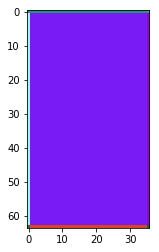

In [33]:
example =   netG(get_fake_image()).data.cpu()
utils.make_grid(example)
im = example / 2 +0.5
im = im.numpy()
plt.imshow(np.transpose(im[2], (1,2,0)))

In [ ]:
k_t = train(100, k_t, 0.000001)